# Curve lane detection
There are few open cv techniques that can be used to detect the road lanes and the curvature edges that can help the self driving cars in locating the drivable lanes

# Calibration and distortion removal
Some cameras like pinhole camera introduce distortion to the images captured , hence it's important to remove the distortion in order to retain the original shapes since the straight lines appear as curved or distored from its original shape

In [293]:
# Main imports
import numpy as np
import cv2 
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import utils; reload(utils)
from utils import *

calibration_dir = "camera_cal"
test_imgs_dir = "test_images"

Since we need some collection of images to perform the calibration , opencv comes with some images  of a chess board which we could utilise to find the patterns required for the road lanes.Since both have same pattern we can use the inbuilt images of chess board, incase of different patterns we can collect the required pattern from the images on our own and find the calibration points for the same. 

Ref: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html

# Find corners 

In [294]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

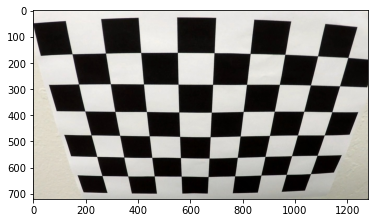

In [295]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

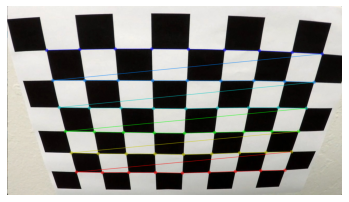

In [296]:
cx = 9
cy = 6

def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)           

def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)
    
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

# Find object and image points

In [297]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [298]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)
print(len(opts))
print(len(opts))

17
17


# Calibration matrix
Now that we have our object points and image points, we are ready to go for calibration. We can use the function, cv.calibrateCamera() which returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

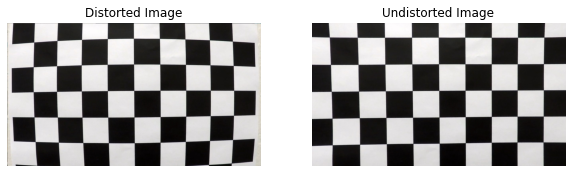

In [299]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

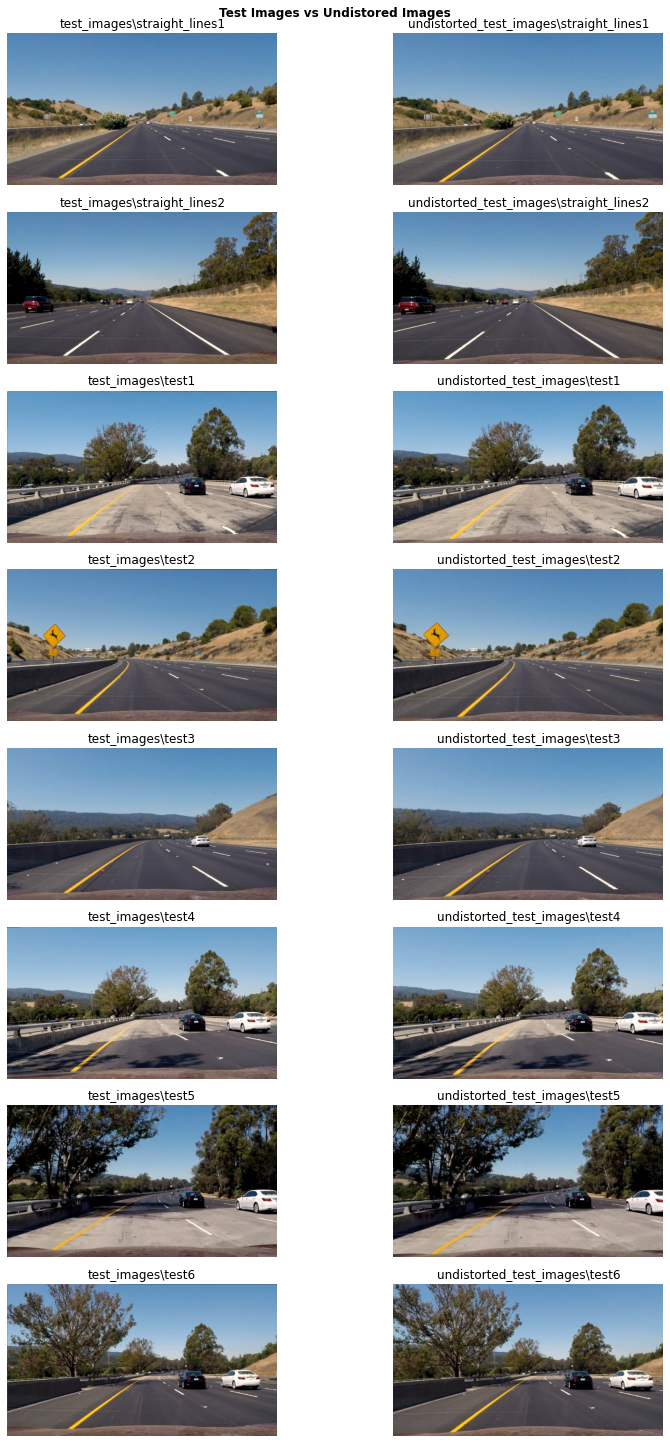

In [300]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

# Thresholding
To detect the edges that constitute the lanes of the road for better prediction

In [301]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

In [302]:
#RGB thresholding
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

#HLS thresholding
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

#HSV thresholding
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

#LAB thresholding
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

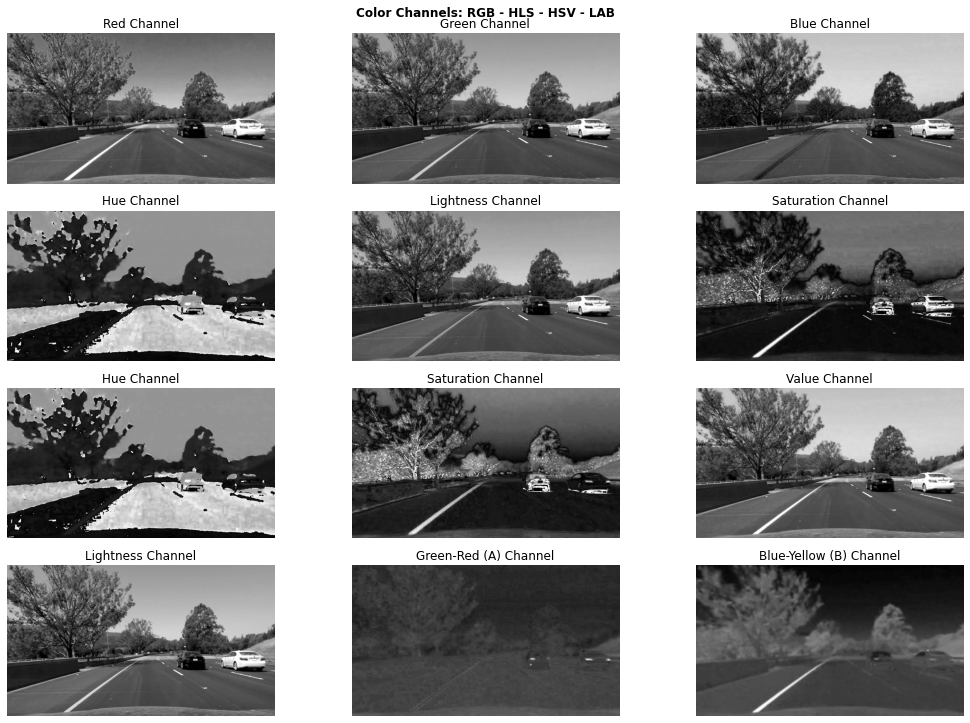

In [303]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

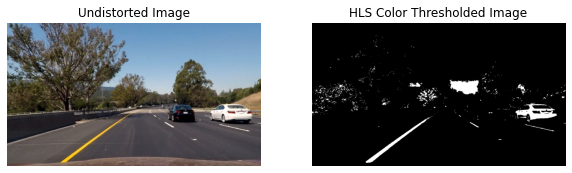

In [304]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

# Gradient thresholding using sobel

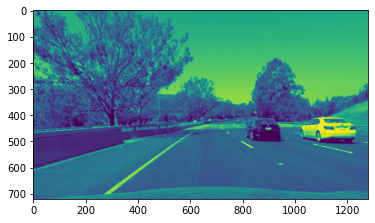

In [305]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]
plt.imshow(undist_test_img_gray)

In [306]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

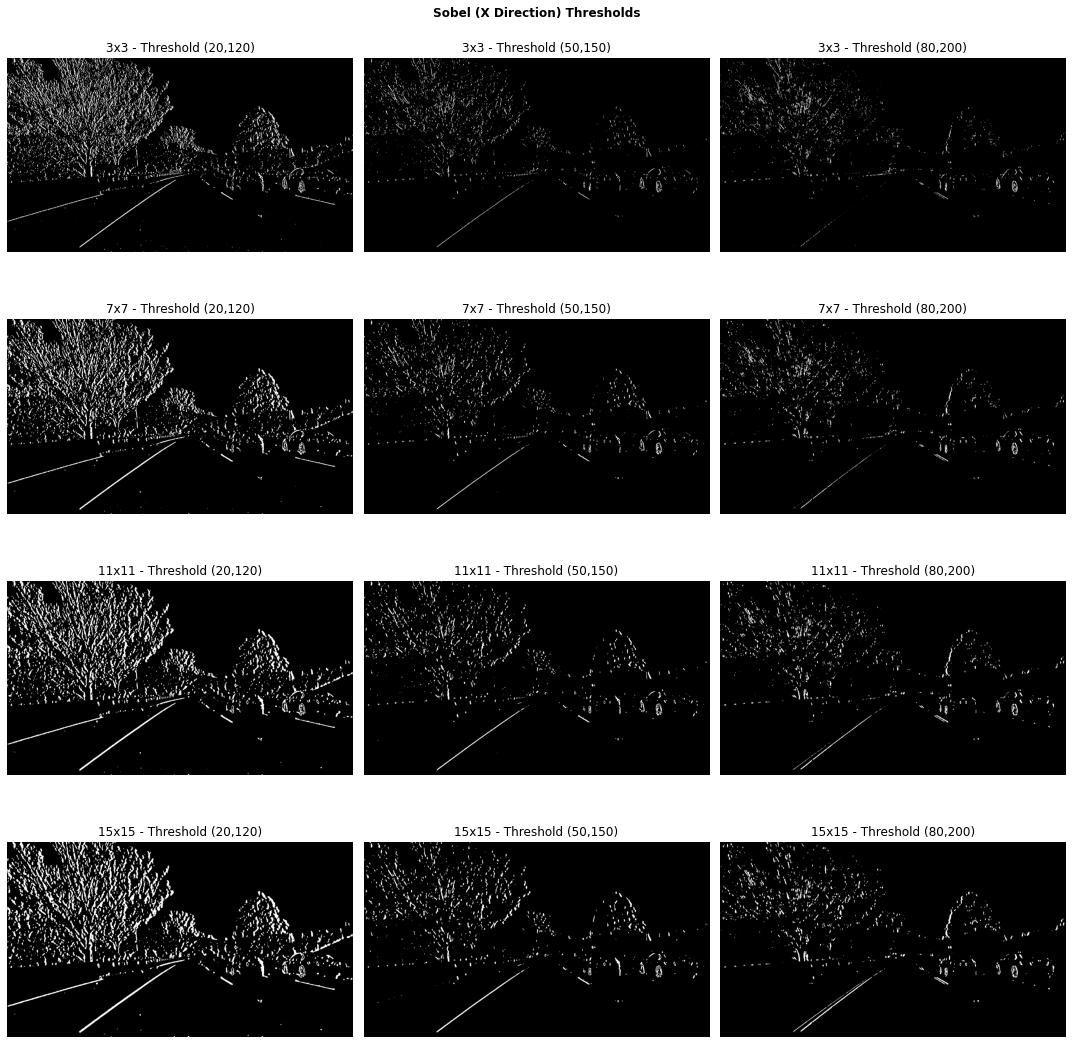

In [307]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

In [308]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

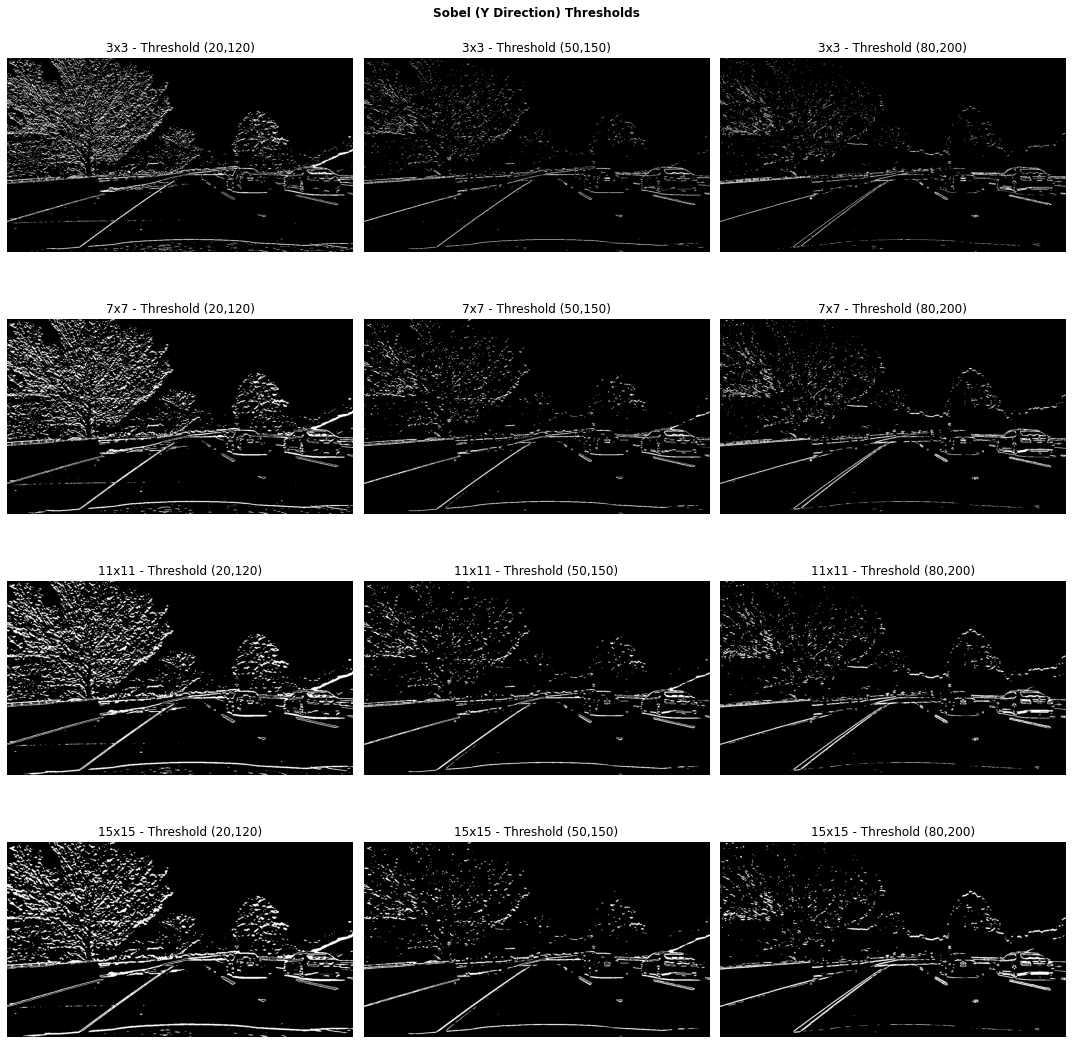

In [309]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In [310]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

In [311]:
#For both x and y direction
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

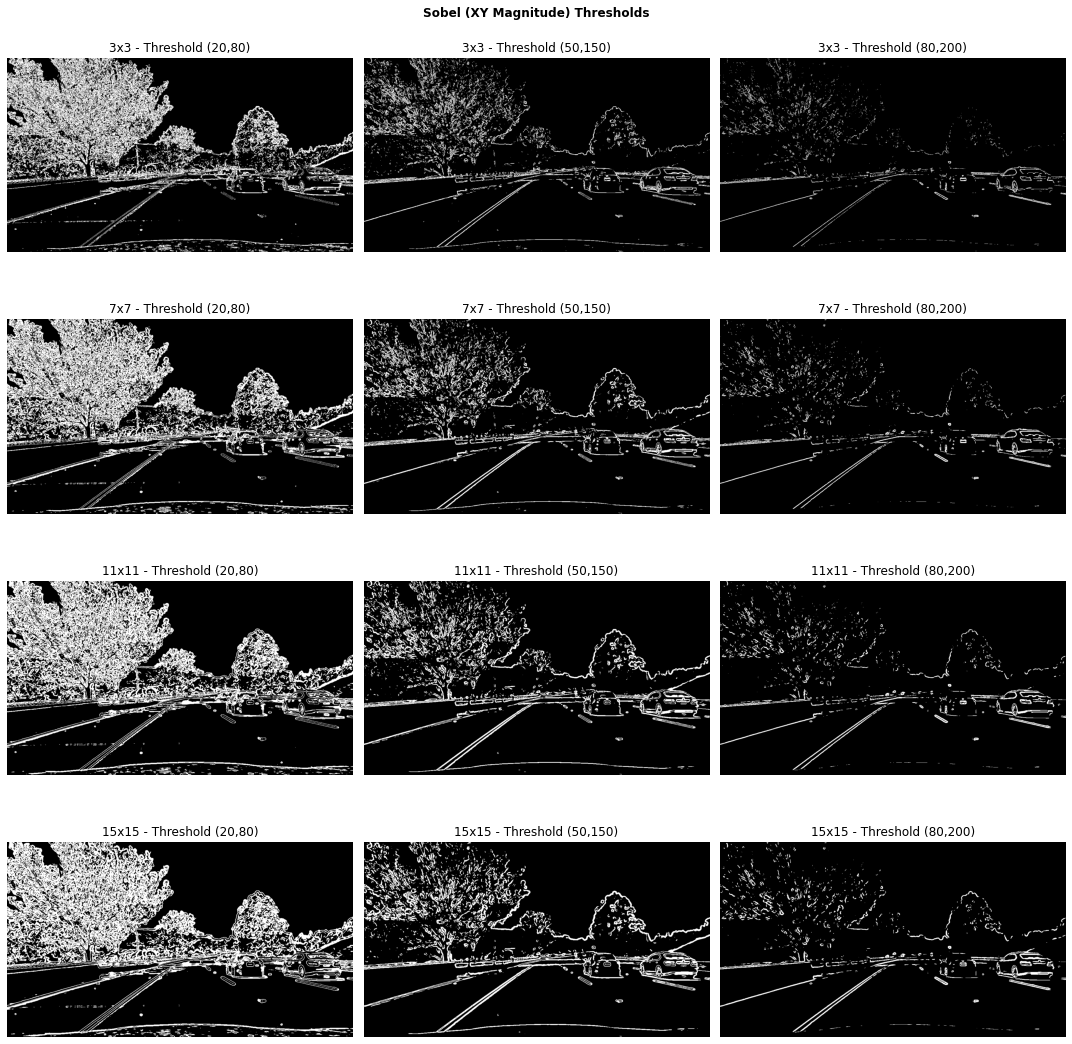

In [312]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])

sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))

show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

In [313]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

# Combined sobel

In [314]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined


In [315]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

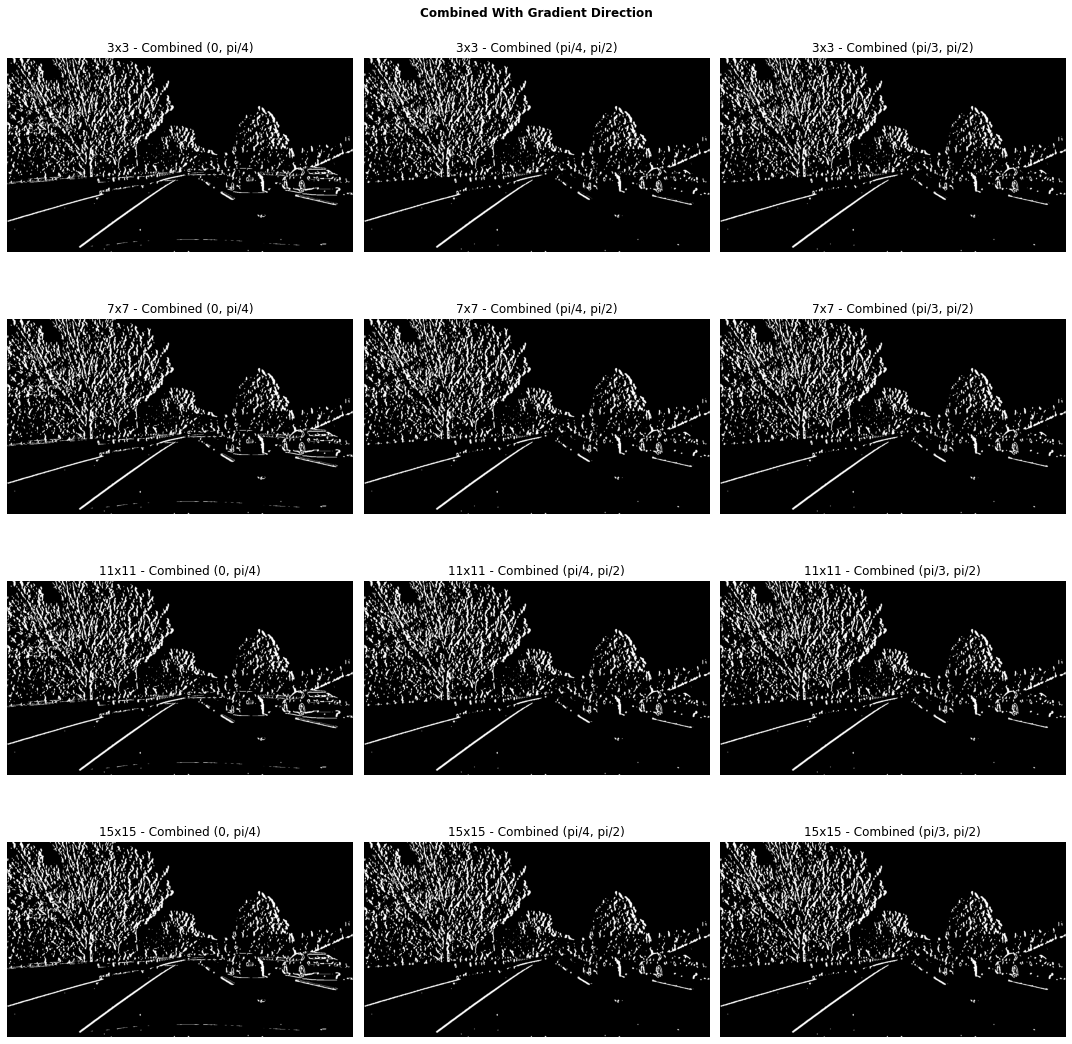

In [316]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])


sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

In [317]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

# Combining the thresholds

In [318]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

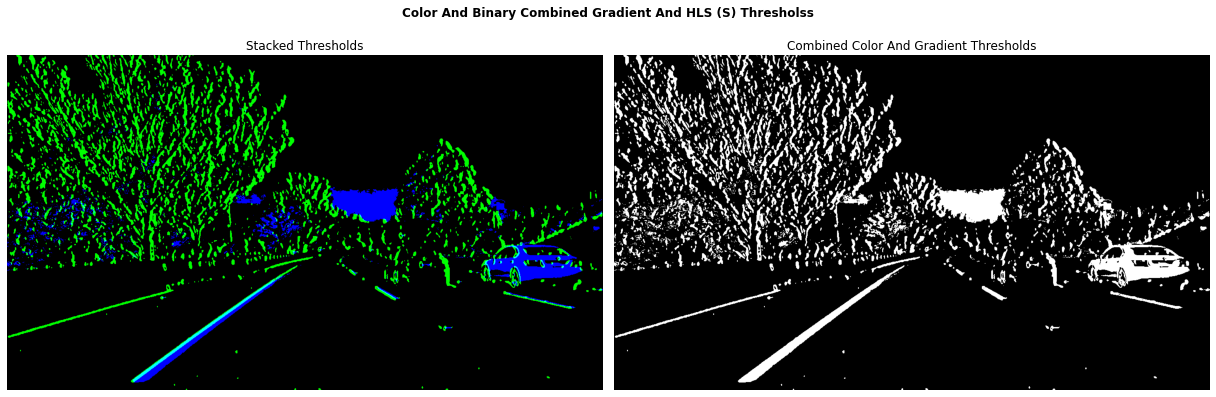

In [319]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

# Perspective transform
Bird eye view conversion to detect lanes better

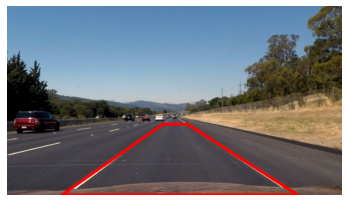

In [326]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [327]:
def compute_perspective_transform_metrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [328]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

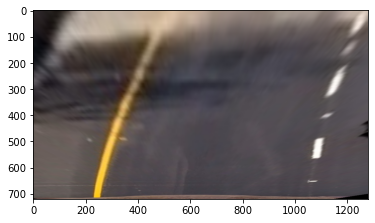

In [330]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)
plt.imshow(test_img_persp_tr)

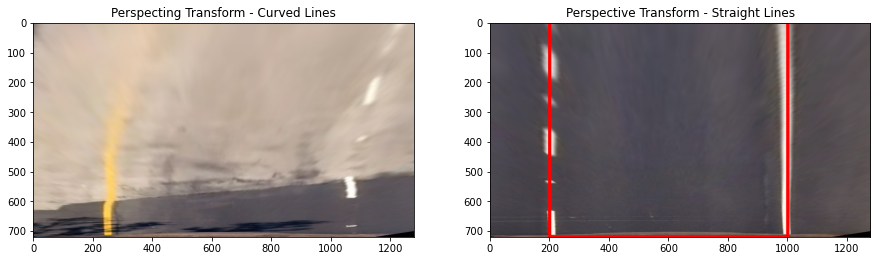

In [331]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

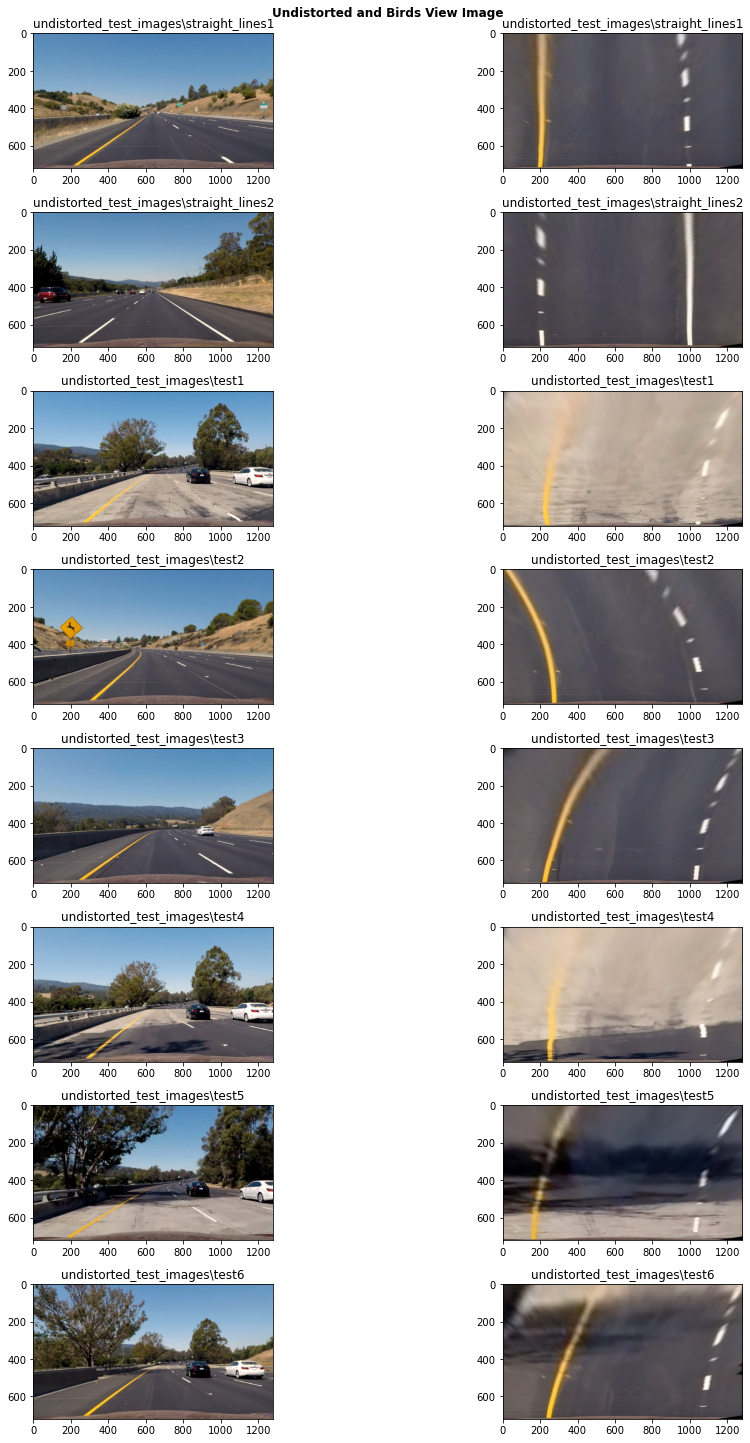

In [332]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

In [325]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [333]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))


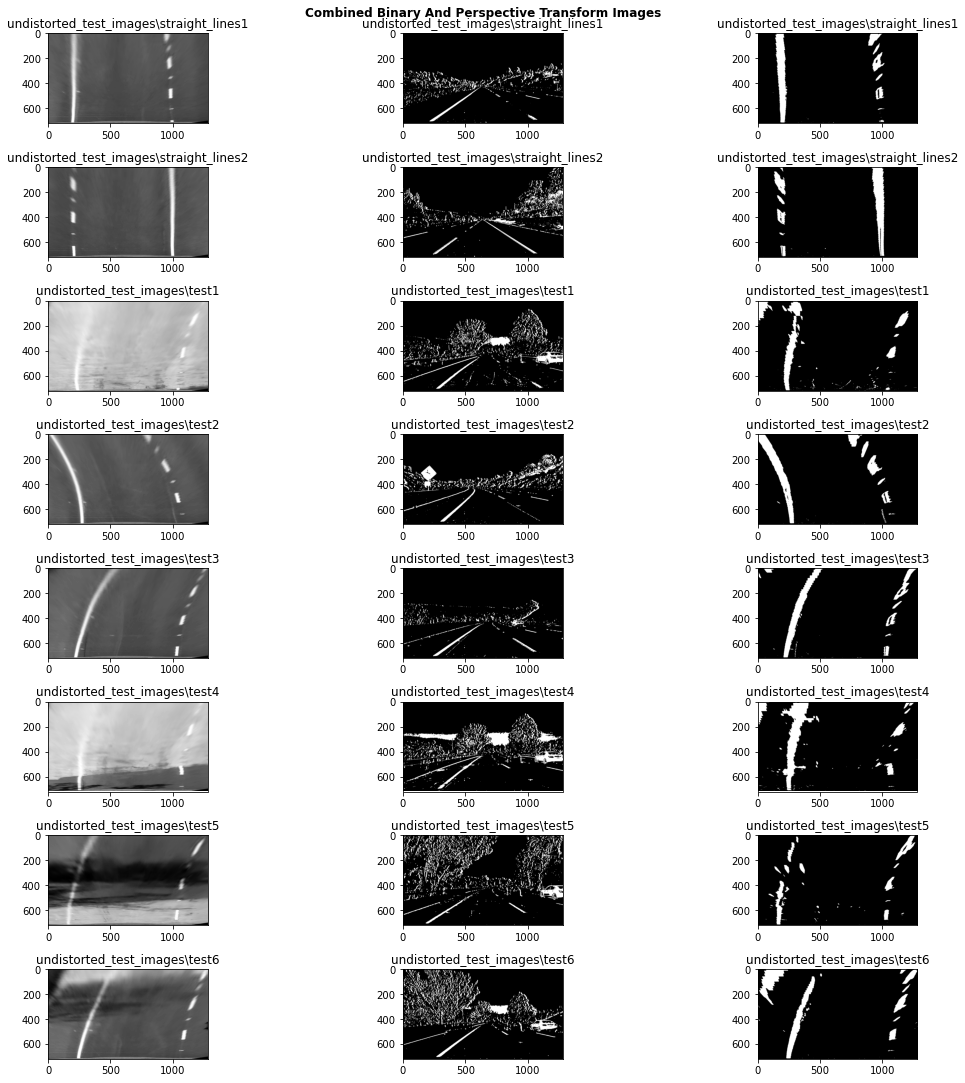

In [334]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

 The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image.

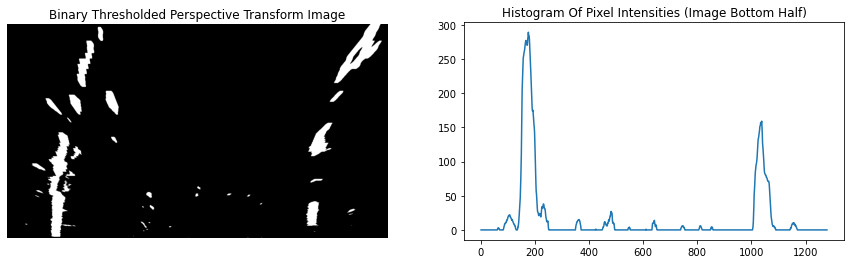

In [335]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Pipeline

In [338]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)                            
        

In [339]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []
        

In [340]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [341]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [342]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [343]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=31891.070517716817
Left Curvature   Right Curvature  Center Alignment 
1003.8011m       2518.4605m       0.1711m Right    


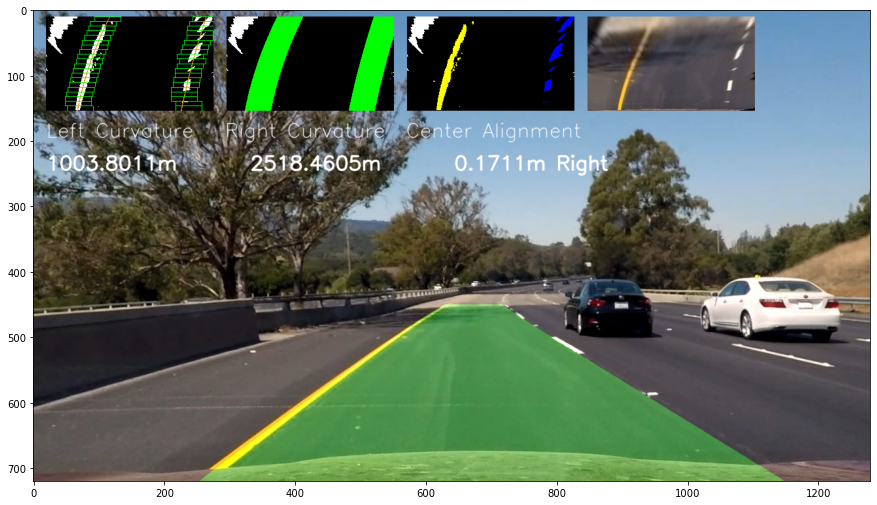

In [344]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

# Curve lane detection

In [345]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [346]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [347]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [348]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    
Moviepy - Building video output_videos/lanes_project_video_sample.mp4.
Moviepy - Writing video output_videos/lanes_project_video_sample.mp4



t:   1%|█                                                                    | 2/136 [00:01<01:30,  1.49it/s, now=None]

[Previous lane] Found pct=0.8019734493167581
Non zeros found below thresholds, begining sliding window - pct=0.8019734493167581
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    


t:   2%|█▌                                                                   | 3/136 [00:02<01:57,  1.13it/s, now=None]

[Previous lane] Found pct=0.7846561444887805
Non zeros found below thresholds, begining sliding window - pct=0.7846561444887805
[Sliding windows] Found pct=21634.31329057689
Left Curvature   Right Curvature  Center Alignment 
6070.4331m       7405.9791m       0.0875m Right    


t:   3%|██                                                                   | 4/136 [00:03<02:10,  1.01it/s, now=None]

[Previous lane] Found pct=0.7857179998266748
Non zeros found below thresholds, begining sliding window - pct=0.7857179998266748
[Sliding windows] Found pct=19927.02223762891
Left Curvature   Right Curvature  Center Alignment 
2165.4155m       6032.1863m       0.0882m Right    


t:   4%|██▌                                                                  | 5/136 [00:05<02:17,  1.05s/it, now=None]

[Previous lane] Found pct=0.7781293437705757
Non zeros found below thresholds, begining sliding window - pct=0.7781293437705757
[Sliding windows] Found pct=18472.820085595144
Left Curvature   Right Curvature  Center Alignment 
2912.2983m       5579.3115m       0.0877m Right    


t:   4%|███                                                                  | 6/136 [00:06<02:22,  1.10s/it, now=None]

[Previous lane] Found pct=0.7764292032667504
Non zeros found below thresholds, begining sliding window - pct=0.7764292032667504
[Sliding windows] Found pct=16467.064100717944
Left Curvature   Right Curvature  Center Alignment 
4354.8537m       924.7667m        0.0514m Right    


t:   5%|███▌                                                                 | 7/136 [00:07<02:27,  1.14s/it, now=None]

[Previous lane] Found pct=0.7756889943420332
Non zeros found below thresholds, begining sliding window - pct=0.7756889943420332
[Sliding windows] Found pct=16822.581898562188
Left Curvature   Right Curvature  Center Alignment 
6642.9587m       2534.8131m       0.0874m Right    


t:   6%|████                                                                 | 8/136 [00:08<02:28,  1.16s/it, now=None]

[Previous lane] Found pct=0.7226362011937801
Non zeros found below thresholds, begining sliding window - pct=0.7226362011937801
[Sliding windows] Found pct=16634.91413526974
Left Curvature   Right Curvature  Center Alignment 
2013.6486m       17406.3146m      0.0971m Right    


t:   7%|████▌                                                                | 9/136 [00:10<02:33,  1.21s/it, now=None]

[Previous lane] Found pct=0.7050582073254243
Non zeros found below thresholds, begining sliding window - pct=0.7050582073254243
[Sliding windows] Found pct=17493.833558512706
Left Curvature   Right Curvature  Center Alignment 
1399.1388m       7558.4907m       0.0871m Right    


t:   7%|█████                                                               | 10/136 [00:11<02:34,  1.22s/it, now=None]

[Previous lane] Found pct=0.7464674519026091
Non zeros found below thresholds, begining sliding window - pct=0.7464674519026091
[Sliding windows] Found pct=17065.058994060048
Left Curvature   Right Curvature  Center Alignment 
1721.9458m       2242.8519m       0.0795m Right    


t:   8%|█████▌                                                              | 11/136 [00:12<02:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.6023710095592456
Non zeros found below thresholds, begining sliding window - pct=0.6023710095592456
[Sliding windows] Found pct=17759.681497021393
Left Curvature   Right Curvature  Center Alignment 
1973.8719m       1454.2940m       0.0893m Right    


t:   9%|██████                                                              | 12/136 [00:13<02:31,  1.22s/it, now=None]

[Previous lane] Found pct=0.7811436617514765
Non zeros found below thresholds, begining sliding window - pct=0.7811436617514765
[Sliding windows] Found pct=18391.03009739117
Left Curvature   Right Curvature  Center Alignment 
2164.0387m       1564.4567m       0.0842m Right    


t:  10%|██████▌                                                             | 13/136 [00:15<02:29,  1.22s/it, now=None]

[Previous lane] Found pct=0.8089391162695989
Non zeros found below thresholds, begining sliding window - pct=0.8089391162695989
[Sliding windows] Found pct=18571.66621869273
Left Curvature   Right Curvature  Center Alignment 
1678.3753m       1195.7256m       0.1080m Right    


t:  10%|███████                                                             | 14/136 [00:16<02:27,  1.21s/it, now=None]

[Previous lane] Found pct=0.618105451676865
Non zeros found below thresholds, begining sliding window - pct=0.618105451676865
[Sliding windows] Found pct=18235.652239728803
Left Curvature   Right Curvature  Center Alignment 
3148.3393m       18824.0682m      0.1055m Right    


t:  11%|███████▌                                                            | 15/136 [00:17<02:26,  1.21s/it, now=None]

[Previous lane] Found pct=0.7653396324249583
Non zeros found below thresholds, begining sliding window - pct=0.7653396324249583
[Sliding windows] Found pct=13822.382007259319
Left Curvature   Right Curvature  Center Alignment 
1150.9530m       1522.2642m       0.1041m Right    


t:  12%|████████                                                            | 16/136 [00:18<02:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.7590167046317388
Non zeros found below thresholds, begining sliding window - pct=0.7590167046317388
[Sliding windows] Found pct=12929.003669956974
Left Curvature   Right Curvature  Center Alignment 
1463.6256m       1064.1929m       0.0597m Right    


t:  12%|████████▌                                                           | 17/136 [00:19<02:22,  1.20s/it, now=None]

[Previous lane] Found pct=0.7805129761724086
Non zeros found below thresholds, begining sliding window - pct=0.7805129761724086
[Sliding windows] Found pct=13737.216482015481
Left Curvature   Right Curvature  Center Alignment 
5257.5290m       2723.3597m       0.0999m Right    


t:  13%|█████████                                                           | 18/136 [00:21<02:20,  1.19s/it, now=None]

[Previous lane] Found pct=0.8843864229765013
Left Curvature   Right Curvature  Center Alignment 
122568.3901m     2574.4965m       0.0972m Right    


t:  14%|█████████▌                                                          | 19/136 [00:22<02:21,  1.21s/it, now=None]

[Previous lane] Found pct=0.9040371329879102
Left Curvature   Right Curvature  Center Alignment 
1686.9690m       4154.5385m       0.1062m Right    


t:  15%|██████████                                                          | 20/136 [00:23<02:19,  1.20s/it, now=None]

[Previous lane] Found pct=0.8927605409705648
Left Curvature   Right Curvature  Center Alignment 
1603.5979m       3038.3028m       0.1059m Right    


t:  15%|██████████▌                                                         | 21/136 [00:24<02:18,  1.20s/it, now=None]

[Previous lane] Found pct=0.8806782499476659
Left Curvature   Right Curvature  Center Alignment 
1478.2044m       4900.5986m       0.1136m Right    


t:  16%|███████████                                                         | 22/136 [00:25<02:17,  1.21s/it, now=None]

[Previous lane] Found pct=0.8453849111288557
Non zeros found below thresholds, begining sliding window - pct=0.8453849111288557
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    


t:  17%|███████████▌                                                        | 23/136 [00:27<02:17,  1.21s/it, now=None]

[Previous lane] Found pct=0.8810690677000228
Left Curvature   Right Curvature  Center Alignment 
1147.7139m       2864.4256m       0.1005m Right    


t:  18%|████████████                                                        | 24/136 [00:28<02:14,  1.20s/it, now=None]

[Previous lane] Found pct=0.8897537911549328
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3063.2815m       0.1040m Right    


t:  18%|████████████▌                                                       | 25/136 [00:29<02:13,  1.20s/it, now=None]

[Previous lane] Found pct=0.8842374520385563
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3284.8537m       0.1144m Right    


t:  19%|█████████████                                                       | 26/136 [00:30<02:12,  1.20s/it, now=None]

[Previous lane] Found pct=0.870750600412678
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3813.9553m       0.1178m Right    


t:  20%|█████████████▌                                                      | 27/136 [00:31<02:10,  1.20s/it, now=None]

[Previous lane] Found pct=0.8607212123204365
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


t:  21%|██████████████                                                      | 28/136 [00:33<02:09,  1.20s/it, now=None]

[Previous lane] Found pct=0.8931860036832413
Left Curvature   Right Curvature  Center Alignment 
1252.9051m       2891.3311m       0.1801m Right    


t:  21%|██████████████▌                                                     | 29/136 [00:34<02:07,  1.19s/it, now=None]

[Previous lane] Found pct=0.8916472991055708
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


t:  22%|███████████████                                                     | 30/136 [00:35<02:05,  1.19s/it, now=None]

[Previous lane] Found pct=0.8936295373542337
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.7234m        0.2119m Right    


t:  23%|███████████████▌                                                    | 31/136 [00:36<02:05,  1.19s/it, now=None]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


t:  24%|████████████████                                                    | 32/136 [00:37<02:03,  1.19s/it, now=None]

[Previous lane] Found pct=0.9044788197578512
Left Curvature   Right Curvature  Center Alignment 
3400.8444m       751.7638m        0.2190m Right    


t:  24%|████████████████▌                                                   | 33/136 [00:39<02:03,  1.20s/it, now=None]

[Previous lane] Found pct=0.8900443796780817
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.9135m        0.1939m Right    


t:  25%|█████████████████                                                   | 34/136 [00:40<02:02,  1.20s/it, now=None]

[Previous lane] Found pct=0.8914877427465511
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


t:  26%|█████████████████▌                                                  | 35/136 [00:41<02:00,  1.20s/it, now=None]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


t:  26%|██████████████████                                                  | 36/136 [00:42<01:59,  1.20s/it, now=None]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


t:  27%|██████████████████▌                                                 | 37/136 [00:43<01:57,  1.19s/it, now=None]

[Previous lane] Found pct=0.8949881525095139
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


t:  28%|███████████████████                                                 | 38/136 [00:44<01:55,  1.18s/it, now=None]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


t:  29%|███████████████████▌                                                | 39/136 [00:46<01:54,  1.18s/it, now=None]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


t:  29%|████████████████████                                                | 40/136 [00:47<01:54,  1.19s/it, now=None]

[Previous lane] Found pct=0.8909268219496643
Left Curvature   Right Curvature  Center Alignment 
560.5807m        1701.5025m       0.1011m Right    


t:  30%|████████████████████▌                                               | 41/136 [00:48<01:53,  1.19s/it, now=None]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


t:  31%|█████████████████████                                               | 42/136 [00:49<01:51,  1.19s/it, now=None]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8815m        393.6282m        0.1525m Right    


t:  32%|█████████████████████▌                                              | 43/136 [00:50<01:51,  1.20s/it, now=None]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


t:  32%|██████████████████████                                              | 44/136 [00:52<01:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.8305501337381623
Non zeros found below thresholds, begining sliding window - pct=0.8305501337381623
[Sliding windows] Found pct=11640.069977589821
Left Curvature   Right Curvature  Center Alignment 
411.9685m        6439.7173m       0.0427m Right    


t:  33%|██████████████████████▌                                             | 45/136 [00:53<01:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.8433968356474008
Non zeros found below thresholds, begining sliding window - pct=0.8433968356474008
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


t:  34%|███████████████████████                                             | 46/136 [00:54<01:48,  1.21s/it, now=None]

[Previous lane] Found pct=0.9050070700844784
Left Curvature   Right Curvature  Center Alignment 
2508.2517m       2731.0525m       0.0577m Right    


t:  35%|███████████████████████▌                                            | 47/136 [00:55<01:47,  1.21s/it, now=None]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


t:  35%|████████████████████████                                            | 48/136 [00:56<01:45,  1.20s/it, now=None]

[Previous lane] Found pct=0.8945586839607719
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1961.5402m       0.0648m Right    


t:  36%|████████████████████████▌                                           | 49/136 [00:58<01:44,  1.20s/it, now=None]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


t:  37%|█████████████████████████                                           | 50/136 [00:59<01:43,  1.20s/it, now=None]

[Previous lane] Found pct=0.861794183690235
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


t:  38%|█████████████████████████▌                                          | 51/136 [01:00<01:41,  1.20s/it, now=None]

[Previous lane] Found pct=0.9050002944814183
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


t:  38%|██████████████████████████                                          | 52/136 [01:01<01:40,  1.19s/it, now=None]

[Previous lane] Found pct=0.8600712773654171
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.1255m        0.1301m Right    


t:  39%|██████████████████████████▌                                         | 53/136 [01:02<01:39,  1.20s/it, now=None]

[Previous lane] Found pct=0.9002798968223479
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


t:  40%|███████████████████████████                                         | 54/136 [01:04<01:38,  1.20s/it, now=None]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


t:  40%|███████████████████████████▌                                        | 55/136 [01:05<01:36,  1.19s/it, now=None]

[Previous lane] Found pct=0.8948421821329078
Left Curvature   Right Curvature  Center Alignment 
1421.2413m       368.0198m        0.1586m Right    


t:  41%|████████████████████████████                                        | 56/136 [01:06<01:35,  1.20s/it, now=None]

[Previous lane] Found pct=0.8476263820892238
Non zeros found below thresholds, begining sliding window - pct=0.8476263820892238
[Sliding windows] Found pct=16479.815473898456
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


t:  42%|████████████████████████████▌                                       | 57/136 [01:07<01:34,  1.20s/it, now=None]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


t:  43%|█████████████████████████████                                       | 58/136 [01:08<01:33,  1.20s/it, now=None]

[Previous lane] Found pct=0.9540822009356204
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


t:  43%|█████████████████████████████▌                                      | 59/136 [01:10<01:31,  1.19s/it, now=None]

[Previous lane] Found pct=0.9190463917525773
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


t:  44%|██████████████████████████████                                      | 60/136 [01:11<01:30,  1.19s/it, now=None]

[Previous lane] Found pct=0.9170067688632292
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5665m        0.0442m Right    


t:  45%|██████████████████████████████▌                                     | 61/136 [01:12<01:29,  1.20s/it, now=None]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


t:  46%|███████████████████████████████                                     | 62/136 [01:13<01:29,  1.20s/it, now=None]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


t:  46%|███████████████████████████████▌                                    | 63/136 [01:14<01:27,  1.20s/it, now=None]

[Previous lane] Found pct=0.904247928142524
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


t:  47%|████████████████████████████████                                    | 64/136 [01:16<01:26,  1.20s/it, now=None]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


t:  48%|████████████████████████████████▌                                   | 65/136 [01:17<01:25,  1.20s/it, now=None]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


t:  49%|█████████████████████████████████                                   | 66/136 [01:18<01:24,  1.20s/it, now=None]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


t:  49%|█████████████████████████████████▌                                  | 67/136 [01:19<01:22,  1.20s/it, now=None]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


t:  50%|██████████████████████████████████                                  | 68/136 [01:20<01:21,  1.19s/it, now=None]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


t:  51%|██████████████████████████████████▌                                 | 69/136 [01:22<01:20,  1.19s/it, now=None]

[Previous lane] Found pct=0.9332370371943837
Left Curvature   Right Curvature  Center Alignment 
329.9316m        531.3374m        0.0839m Left     


t:  51%|███████████████████████████████████                                 | 70/136 [01:23<01:19,  1.20s/it, now=None]

[Previous lane] Found pct=0.8982973049769404
Left Curvature   Right Curvature  Center Alignment 
328.5377m        469.6804m        0.0854m Left     


t:  52%|███████████████████████████████████▌                                | 71/136 [01:24<01:18,  1.20s/it, now=None]

[Previous lane] Found pct=0.942516385516278
Left Curvature   Right Curvature  Center Alignment 
320.7352m        487.0053m        0.0846m Left     


t:  53%|████████████████████████████████████                                | 72/136 [01:25<01:16,  1.20s/it, now=None]

[Previous lane] Found pct=0.9472951597595698
Left Curvature   Right Curvature  Center Alignment 
320.4712m        459.3909m        0.0838m Left     


t:  54%|████████████████████████████████████▌                               | 73/136 [01:26<01:15,  1.20s/it, now=None]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


t:  54%|█████████████████████████████████████                               | 74/136 [01:28<01:15,  1.21s/it, now=None]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


t:  55%|█████████████████████████████████████▌                              | 75/136 [01:29<01:13,  1.21s/it, now=None]

[Previous lane] Found pct=0.9638667484161046
Left Curvature   Right Curvature  Center Alignment 
372.6083m        604.5288m        0.0764m Left     


t:  56%|██████████████████████████████████████                              | 76/136 [01:30<01:12,  1.20s/it, now=None]

[Previous lane] Found pct=0.7356095033086184
Non zeros found below thresholds, begining sliding window - pct=0.7356095033086184
[Sliding windows] Found pct=23119.80291796221
Left Curvature   Right Curvature  Center Alignment 
317.9777m        423.6703m        0.0434m Left     


t:  57%|██████████████████████████████████████▌                             | 77/136 [01:31<01:10,  1.20s/it, now=None]

[Previous lane] Found pct=0.8605465331129047
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.6810m        0.0307m Left     


t:  57%|███████████████████████████████████████                             | 78/136 [01:32<01:09,  1.20s/it, now=None]

[Previous lane] Found pct=0.8790518024840958
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7297m        0.0211m Left     


t:  58%|███████████████████████████████████████▌                            | 79/136 [01:34<01:08,  1.20s/it, now=None]

[Previous lane] Found pct=0.8465337132003798
Non zeros found below thresholds, begining sliding window - pct=0.8465337132003798
[Sliding windows] Found pct=23368.788698955366
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


t:  59%|████████████████████████████████████████                            | 80/136 [01:35<01:07,  1.21s/it, now=None]

[Previous lane] Found pct=0.8194405643246263
Non zeros found below thresholds, begining sliding window - pct=0.8194405643246263
[Sliding windows] Found pct=25262.996944405644
Left Curvature   Right Curvature  Center Alignment 
381.3755m        319.6393m        0.0546m Right    


t:  60%|████████████████████████████████████████▌                           | 81/136 [01:36<01:10,  1.28s/it, now=None]

[Previous lane] Found pct=0.7941749427043545
Non zeros found below thresholds, begining sliding window - pct=0.7941749427043545
[Sliding windows] Found pct=25051.930939648588
Left Curvature   Right Curvature  Center Alignment 
462.8301m        426.1410m        0.0382m Right    


t:  60%|█████████████████████████████████████████                           | 82/136 [01:38<01:09,  1.30s/it, now=None]

[Previous lane] Found pct=0.8971990081733859
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


t:  61%|█████████████████████████████████████████▌                          | 83/136 [01:39<01:06,  1.26s/it, now=None]

[Previous lane] Found pct=0.9197884369870509
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.3950m        0.0125m Left     


t:  62%|██████████████████████████████████████████                          | 84/136 [01:40<01:05,  1.25s/it, now=None]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


t:  62%|██████████████████████████████████████████▌                         | 85/136 [01:41<01:03,  1.24s/it, now=None]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


t:  63%|███████████████████████████████████████████                         | 86/136 [01:42<01:01,  1.23s/it, now=None]

[Previous lane] Found pct=0.8714200267398494
Left Curvature   Right Curvature  Center Alignment 
725.9496m        459.7047m        0.0121m Left     


t:  64%|███████████████████████████████████████████▌                        | 87/136 [01:44<00:59,  1.22s/it, now=None]

[Previous lane] Found pct=0.769010727056019
Non zeros found below thresholds, begining sliding window - pct=0.769010727056019
[Sliding windows] Found pct=26898.377217776266
Left Curvature   Right Curvature  Center Alignment 
568.2713m        379.0922m        0.0108m Right    


t:  65%|████████████████████████████████████████████                        | 88/136 [01:45<00:58,  1.22s/it, now=None]

[Previous lane] Found pct=0.7958049119470402
Non zeros found below thresholds, begining sliding window - pct=0.7958049119470402
[Sliding windows] Found pct=24807.3956256972
Left Curvature   Right Curvature  Center Alignment 
515.8677m        312.4867m        0.0269m Right    


t:  65%|████████████████████████████████████████████▌                       | 89/136 [01:46<00:56,  1.21s/it, now=None]

[Previous lane] Found pct=0.8852340725096797
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


t:  66%|█████████████████████████████████████████████                       | 90/136 [01:47<00:56,  1.22s/it, now=None]

[Previous lane] Found pct=0.9223574927237879
Left Curvature   Right Curvature  Center Alignment 
594.8159m        348.1265m        0.0427m Right    


t:  67%|█████████████████████████████████████████████▌                      | 91/136 [01:49<00:54,  1.22s/it, now=None]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


t:  68%|██████████████████████████████████████████████                      | 92/136 [01:50<00:53,  1.22s/it, now=None]

[Previous lane] Found pct=0.8029836688699397
Non zeros found below thresholds, begining sliding window - pct=0.8029836688699397
[Sliding windows] Found pct=28188.45971037893
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


t:  68%|██████████████████████████████████████████████▌                     | 93/136 [01:51<00:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


t:  69%|███████████████████████████████████████████████                     | 94/136 [01:52<00:51,  1.22s/it, now=None]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


t:  70%|███████████████████████████████████████████████▌                    | 95/136 [01:53<00:50,  1.23s/it, now=None]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


t:  71%|████████████████████████████████████████████████                    | 96/136 [01:55<00:48,  1.22s/it, now=None]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


t:  71%|████████████████████████████████████████████████▌                   | 97/136 [01:56<00:47,  1.21s/it, now=None]

[Previous lane] Found pct=0.9736528833024054
Left Curvature   Right Curvature  Center Alignment 
690.0119m        467.7063m        0.1051m Right    


t:  72%|█████████████████████████████████████████████████                   | 98/136 [01:57<00:46,  1.21s/it, now=None]

[Previous lane] Found pct=0.9841866290903397
Left Curvature   Right Curvature  Center Alignment 
630.4916m        511.5680m        0.1051m Right    


t:  73%|█████████████████████████████████████████████████▌                  | 99/136 [01:58<00:44,  1.21s/it, now=None]

[Previous lane] Found pct=0.9840272944850882
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


t:  74%|█████████████████████████████████████████████████▎                 | 100/136 [01:59<00:43,  1.21s/it, now=None]

[Previous lane] Found pct=0.951734416456484
Left Curvature   Right Curvature  Center Alignment 
639.9863m        531.4155m        0.1123m Right    


t:  74%|█████████████████████████████████████████████████▊                 | 101/136 [02:01<00:42,  1.21s/it, now=None]

[Previous lane] Found pct=0.9491071855238217
Left Curvature   Right Curvature  Center Alignment 
630.1527m        591.0743m        0.1158m Right    


t:  75%|██████████████████████████████████████████████████▎                | 102/136 [02:02<00:41,  1.21s/it, now=None]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


t:  76%|██████████████████████████████████████████████████▋                | 103/136 [02:03<00:40,  1.21s/it, now=None]

[Previous lane] Found pct=0.9048035738958228
Left Curvature   Right Curvature  Center Alignment 
585.9865m        553.3466m        0.1281m Right    


t:  76%|███████████████████████████████████████████████████▏               | 104/136 [02:04<00:38,  1.20s/it, now=None]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


t:  77%|███████████████████████████████████████████████████▋               | 105/136 [02:06<00:37,  1.20s/it, now=None]

[Previous lane] Found pct=0.866238573694946
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


t:  78%|████████████████████████████████████████████████████▏              | 106/136 [02:07<00:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


t:  79%|████████████████████████████████████████████████████▋              | 107/136 [02:08<00:35,  1.22s/it, now=None]

[Previous lane] Found pct=0.8338197424892704
Non zeros found below thresholds, begining sliding window - pct=0.8338197424892704
[Sliding windows] Found pct=31768.374048640915
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


t:  79%|█████████████████████████████████████████████████████▏             | 108/136 [02:09<00:34,  1.22s/it, now=None]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


t:  80%|█████████████████████████████████████████████████████▋             | 109/136 [02:10<00:32,  1.21s/it, now=None]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


t:  81%|██████████████████████████████████████████████████████▏            | 110/136 [02:12<00:31,  1.21s/it, now=None]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


t:  82%|██████████████████████████████████████████████████████▋            | 111/136 [02:13<00:30,  1.21s/it, now=None]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


t:  82%|███████████████████████████████████████████████████████▏           | 112/136 [02:14<00:28,  1.20s/it, now=None]

[Previous lane] Found pct=0.8856309833330829
Left Curvature   Right Curvature  Center Alignment 
532.2554m        689.0037m        0.1432m Right    


t:  83%|███████████████████████████████████████████████████████▋           | 113/136 [02:15<00:27,  1.20s/it, now=None]

[Previous lane] Found pct=0.9272655197018949
Left Curvature   Right Curvature  Center Alignment 
546.3759m        735.3818m        0.1443m Right    


t:  84%|████████████████████████████████████████████████████████▏          | 114/136 [02:16<00:26,  1.20s/it, now=None]

[Previous lane] Found pct=0.9380921293568778
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


t:  85%|████████████████████████████████████████████████████████▋          | 115/136 [02:18<00:25,  1.20s/it, now=None]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7289m        686.1148m        0.1467m Right    


t:  85%|█████████████████████████████████████████████████████████▏         | 116/136 [02:19<00:23,  1.19s/it, now=None]

[Previous lane] Found pct=0.9236266477812294
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9938m        0.1587m Right    


t:  86%|█████████████████████████████████████████████████████████▋         | 117/136 [02:20<00:22,  1.20s/it, now=None]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


t:  87%|██████████████████████████████████████████████████████████▏        | 118/136 [02:21<00:21,  1.20s/it, now=None]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


t:  88%|██████████████████████████████████████████████████████████▋        | 119/136 [02:22<00:20,  1.20s/it, now=None]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


t:  88%|███████████████████████████████████████████████████████████        | 120/136 [02:24<00:19,  1.19s/it, now=None]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


t:  89%|███████████████████████████████████████████████████████████▌       | 121/136 [02:25<00:17,  1.20s/it, now=None]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


t:  90%|████████████████████████████████████████████████████████████       | 122/136 [02:26<00:16,  1.20s/it, now=None]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


t:  90%|████████████████████████████████████████████████████████████▌      | 123/136 [02:27<00:15,  1.20s/it, now=None]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


t:  91%|█████████████████████████████████████████████████████████████      | 124/136 [02:28<00:14,  1.19s/it, now=None]

[Previous lane] Found pct=0.945019105021663
Left Curvature   Right Curvature  Center Alignment 
845.4055m        590.6289m        0.1653m Right    


t:  92%|█████████████████████████████████████████████████████████████▌     | 125/136 [02:30<00:13,  1.20s/it, now=None]

[Previous lane] Found pct=0.9683285143649826
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.1773m        0.1626m Right    


t:  93%|██████████████████████████████████████████████████████████████     | 126/136 [02:31<00:11,  1.19s/it, now=None]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


t:  93%|██████████████████████████████████████████████████████████████▌    | 127/136 [02:32<00:10,  1.21s/it, now=None]

[Previous lane] Found pct=0.9504999759241128
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.8580m        0.1672m Right    


t:  94%|███████████████████████████████████████████████████████████████    | 128/136 [02:33<00:09,  1.25s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  95%|███████████████████████████████████████████████████████████████▌   | 129/136 [02:35<00:08,  1.27s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  96%|████████████████████████████████████████████████████████████████   | 130/136 [02:36<00:07,  1.27s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  96%|████████████████████████████████████████████████████████████████▌  | 131/136 [02:37<00:06,  1.26s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  97%|█████████████████████████████████████████████████████████████████  | 132/136 [02:38<00:05,  1.26s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  98%|█████████████████████████████████████████████████████████████████▌ | 133/136 [02:40<00:03,  1.28s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  99%|██████████████████████████████████████████████████████████████████ | 134/136 [02:41<00:02,  1.28s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  99%|██████████████████████████████████████████████████████████████████▌| 135/136 [02:42<00:01,  1.25s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t: 100%|███████████████████████████████████████████████████████████████████| 136/136 [02:43<00:00,  1.23s/it, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


Moviepy - Done !
Moviepy - video ready output_videos/lanes_project_video_sample.mp4
Wall time: 2min 46s


In [349]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [354]:
from moviepy.editor import VideoFileClip

video_path = "project_video.mp4"
video_output_path = "project_video_sample.mp4"

#detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

#clip1 = VideoFileClip(video_path)
# Create the clip
#vid_clip = clip1.fl_image(detector.process_image)
#vid_clip.write_videofile(video_output_path, audio=False)

In [355]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(video_path, 22, 27, targetname=video_output_path)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [356]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(video_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=29291.815393535726
Left Curvature   Right Curvature  Center Alignment 
472.3622m        659.5819m        0.3226m Right    
Moviepy - Building video project_video_sample.mp4.
Moviepy - Writing video project_video_sample.mp4



t:   0%|                                                                    | 2/1260 [00:01<12:36,  1.66it/s, now=None]

[Previous lane] Found pct=0.942701674050727
Left Curvature   Right Curvature  Center Alignment 
445.9994m        1101.0637m       0.3525m Right    


t:   0%|▏                                                                   | 3/1260 [00:02<16:26,  1.27it/s, now=None]

[Previous lane] Found pct=0.953921020417416
Left Curvature   Right Curvature  Center Alignment 
438.7039m        1131.3794m       0.3514m Right    


t:   0%|▏                                                                   | 4/1260 [00:03<18:55,  1.11it/s, now=None]

[Previous lane] Found pct=0.9543829890349549
Left Curvature   Right Curvature  Center Alignment 
460.9568m        993.1643m        0.3516m Right    


t:   0%|▎                                                                   | 5/1260 [00:04<21:04,  1.01s/it, now=None]

[Previous lane] Found pct=0.95334407980778
Left Curvature   Right Curvature  Center Alignment 
458.6836m        1034.5572m       0.3566m Right    


t:   0%|▎                                                                   | 6/1260 [00:06<22:07,  1.06s/it, now=None]

[Previous lane] Found pct=0.9554211849635195
Left Curvature   Right Curvature  Center Alignment 
439.5034m        1085.2745m       0.3581m Right    


t:   1%|▍                                                                   | 7/1260 [00:07<23:18,  1.12s/it, now=None]

[Previous lane] Found pct=0.9389242667259532
Left Curvature   Right Curvature  Center Alignment 
450.5923m        894.4166m        0.3596m Right    


t:   1%|▍                                                                   | 8/1260 [00:08<23:46,  1.14s/it, now=None]

[Previous lane] Found pct=0.9472213009901929
Left Curvature   Right Curvature  Center Alignment 
500.9079m        637.8124m        0.3591m Right    


t:   1%|▍                                                                   | 9/1260 [00:09<23:54,  1.15s/it, now=None]

[Previous lane] Found pct=0.9527134811342254
Left Curvature   Right Curvature  Center Alignment 
491.5354m        542.1777m        0.3479m Right    


t:   1%|▌                                                                  | 10/1260 [00:10<24:06,  1.16s/it, now=None]

[Previous lane] Found pct=0.9709230793190986
Left Curvature   Right Curvature  Center Alignment 
539.3599m        548.2603m        0.3613m Right    


t:   1%|▌                                                                  | 11/1260 [00:11<24:10,  1.16s/it, now=None]

[Previous lane] Found pct=0.9784505280491473
Left Curvature   Right Curvature  Center Alignment 
561.6649m        664.5695m        0.3784m Right    


t:   1%|▋                                                                  | 12/1260 [00:13<24:08,  1.16s/it, now=None]

[Previous lane] Found pct=0.973332489758474
Left Curvature   Right Curvature  Center Alignment 
603.7049m        793.4385m        0.3861m Right    


t:   1%|▋                                                                  | 13/1260 [00:14<24:13,  1.17s/it, now=None]

[Previous lane] Found pct=0.9503677050784333
Left Curvature   Right Curvature  Center Alignment 
628.7639m        722.1513m        0.3834m Right    


t:   1%|▋                                                                  | 14/1260 [00:15<24:13,  1.17s/it, now=None]

[Previous lane] Found pct=0.9659548562330242
Left Curvature   Right Curvature  Center Alignment 
728.3761m        858.9669m        0.3869m Right    


t:   1%|▊                                                                  | 15/1260 [00:16<24:13,  1.17s/it, now=None]

[Previous lane] Found pct=0.9676873678439972
Left Curvature   Right Curvature  Center Alignment 
743.9075m        832.6826m        0.3785m Right    


t:   1%|▊                                                                  | 16/1260 [00:17<24:21,  1.17s/it, now=None]

[Previous lane] Found pct=0.946371578709823
Left Curvature   Right Curvature  Center Alignment 
638.1211m        862.7854m        0.3630m Right    


t:   1%|▉                                                                  | 17/1260 [00:19<24:28,  1.18s/it, now=None]

[Previous lane] Found pct=0.9205302316514506
Left Curvature   Right Curvature  Center Alignment 
616.8164m        972.1392m        0.3543m Right    


t:   1%|▉                                                                  | 18/1260 [00:20<24:35,  1.19s/it, now=None]

[Previous lane] Found pct=0.9213731649464709
Left Curvature   Right Curvature  Center Alignment 
594.4243m        926.0406m        0.3450m Right    


t:   2%|█                                                                  | 19/1260 [00:21<24:28,  1.18s/it, now=None]

[Previous lane] Found pct=0.9164791400216937
Left Curvature   Right Curvature  Center Alignment 
607.4978m        718.8225m        0.3333m Right    


t:   2%|█                                                                  | 20/1260 [00:22<24:24,  1.18s/it, now=None]

[Previous lane] Found pct=0.9490552233108538
Left Curvature   Right Curvature  Center Alignment 
674.0126m        484.7212m        0.3180m Right    


t:   2%|█                                                                  | 21/1260 [00:23<24:14,  1.17s/it, now=None]

[Previous lane] Found pct=0.9686407028807975
Left Curvature   Right Curvature  Center Alignment 
703.5323m        401.3282m        0.2963m Right    


t:   2%|█▏                                                                 | 22/1260 [00:24<24:11,  1.17s/it, now=None]

[Previous lane] Found pct=0.9493265548659712
Left Curvature   Right Curvature  Center Alignment 
750.1098m        361.5978m        0.2773m Right    


t:   2%|█▏                                                                 | 23/1260 [00:26<24:07,  1.17s/it, now=None]

[Previous lane] Found pct=0.9354194517337558
Left Curvature   Right Curvature  Center Alignment 
685.8626m        343.2340m        0.2679m Right    


t:   2%|█▎                                                                 | 24/1260 [00:27<24:07,  1.17s/it, now=None]

[Previous lane] Found pct=0.9349412573223811
Left Curvature   Right Curvature  Center Alignment 
717.8569m        340.2570m        0.2628m Right    


t:   2%|█▎                                                                 | 25/1260 [00:28<24:16,  1.18s/it, now=None]

[Previous lane] Found pct=0.9708879426043444
Left Curvature   Right Curvature  Center Alignment 
611.8366m        436.3308m        0.2742m Right    


t:   2%|█▍                                                                 | 26/1260 [00:29<24:17,  1.18s/it, now=None]

[Previous lane] Found pct=0.972007018937889
Left Curvature   Right Curvature  Center Alignment 
598.3944m        555.0382m        0.2877m Right    


t:   2%|█▍                                                                 | 27/1260 [00:30<24:19,  1.18s/it, now=None]

[Previous lane] Found pct=0.963454268090469
Left Curvature   Right Curvature  Center Alignment 
628.3747m        544.6918m        0.2895m Right    


t:   2%|█▍                                                                 | 28/1260 [00:32<24:12,  1.18s/it, now=None]

[Previous lane] Found pct=0.9655195411497932
Left Curvature   Right Curvature  Center Alignment 
587.0153m        579.0784m        0.2883m Right    


t:   2%|█▌                                                                 | 29/1260 [00:33<24:15,  1.18s/it, now=None]

[Previous lane] Found pct=0.935667845329075
Left Curvature   Right Curvature  Center Alignment 
579.5652m        535.6762m        0.2822m Right    


t:   2%|█▌                                                                 | 30/1260 [00:34<24:40,  1.20s/it, now=None]

[Previous lane] Found pct=0.9657894311178687
Left Curvature   Right Curvature  Center Alignment 
600.4837m        567.5252m        0.2818m Right    


t:   2%|█▋                                                                 | 31/1260 [00:35<24:34,  1.20s/it, now=None]

[Previous lane] Found pct=0.9665953763112334
Left Curvature   Right Curvature  Center Alignment 
503.6921m        650.2333m        0.2733m Right    


t:   3%|█▋                                                                 | 32/1260 [00:36<24:20,  1.19s/it, now=None]

[Previous lane] Found pct=0.9331788335264581
Left Curvature   Right Curvature  Center Alignment 
464.4229m        801.2129m        0.2802m Right    


t:   3%|█▊                                                                 | 33/1260 [00:37<24:09,  1.18s/it, now=None]

[Previous lane] Found pct=0.8965160400137978
Left Curvature   Right Curvature  Center Alignment 
435.7670m        745.2661m        0.2750m Right    


t:   3%|█▊                                                                 | 34/1260 [00:39<23:57,  1.17s/it, now=None]

[Previous lane] Found pct=0.9394700619408121
Left Curvature   Right Curvature  Center Alignment 
437.3988m        506.8954m        0.2619m Right    


t:   3%|█▊                                                                 | 35/1260 [00:40<24:07,  1.18s/it, now=None]

[Previous lane] Found pct=0.9502175133314622
Left Curvature   Right Curvature  Center Alignment 
424.8240m        424.3230m        0.2508m Right    


t:   3%|█▉                                                                 | 36/1260 [00:41<24:06,  1.18s/it, now=None]

[Previous lane] Found pct=0.9618524823680645
Left Curvature   Right Curvature  Center Alignment 
400.9507m        442.9373m        0.2671m Right    


t:   3%|█▉                                                                 | 37/1260 [00:42<23:57,  1.18s/it, now=None]

[Previous lane] Found pct=0.9587201802358327
Left Curvature   Right Curvature  Center Alignment 
391.4370m        561.8693m        0.2937m Right    


t:   3%|██                                                                 | 38/1260 [00:43<24:00,  1.18s/it, now=None]

[Previous lane] Found pct=0.9610636452547471
Left Curvature   Right Curvature  Center Alignment 
352.8109m        546.7347m        0.2855m Right    


t:   3%|██                                                                 | 39/1260 [00:45<24:00,  1.18s/it, now=None]

[Previous lane] Found pct=0.9513063492348911
Left Curvature   Right Curvature  Center Alignment 
332.2962m        506.0258m        0.2807m Right    


t:   3%|██▏                                                                | 40/1260 [00:46<23:57,  1.18s/it, now=None]

[Previous lane] Found pct=0.9271462854940704
Left Curvature   Right Curvature  Center Alignment 
311.9979m        532.4814m        0.2791m Right    


t:   3%|██▏                                                                | 41/1260 [00:47<24:02,  1.18s/it, now=None]

[Previous lane] Found pct=0.9510978760045924
Left Curvature   Right Curvature  Center Alignment 
333.3204m        568.4954m        0.2944m Right    


t:   3%|██▏                                                                | 42/1260 [00:48<23:54,  1.18s/it, now=None]

[Previous lane] Found pct=0.9468142743624937
Left Curvature   Right Curvature  Center Alignment 
328.9944m        503.4830m        0.2898m Right    


t:   3%|██▎                                                                | 43/1260 [00:49<23:57,  1.18s/it, now=None]

[Previous lane] Found pct=0.9509787913423683
Left Curvature   Right Curvature  Center Alignment 
330.1272m        421.6321m        0.2842m Right    


t:   3%|██▎                                                                | 44/1260 [00:50<24:05,  1.19s/it, now=None]

[Previous lane] Found pct=0.9585792408901402
Left Curvature   Right Curvature  Center Alignment 
351.1054m        344.5649m        0.2837m Right    


t:   4%|██▍                                                                | 45/1260 [00:52<23:59,  1.18s/it, now=None]

[Previous lane] Found pct=0.9549919031190593
Left Curvature   Right Curvature  Center Alignment 
399.9671m        311.4508m        0.2866m Right    


t:   4%|██▍                                                                | 46/1260 [00:53<23:47,  1.18s/it, now=None]

[Previous lane] Found pct=0.9553204103264287
Left Curvature   Right Curvature  Center Alignment 
407.2671m        311.0336m        0.2878m Right    


t:   4%|██▍                                                                | 47/1260 [00:54<23:53,  1.18s/it, now=None]

[Previous lane] Found pct=0.9581140624721266
Left Curvature   Right Curvature  Center Alignment 
417.5782m        319.1812m        0.2789m Right    


t:   4%|██▌                                                                | 48/1260 [00:55<23:39,  1.17s/it, now=None]

[Previous lane] Found pct=0.9524717177600113
Left Curvature   Right Curvature  Center Alignment 
450.2661m        363.9749m        0.3015m Right    


t:   4%|██▌                                                                | 49/1260 [00:56<23:37,  1.17s/it, now=None]

[Previous lane] Found pct=0.9721931024679732
Left Curvature   Right Curvature  Center Alignment 
460.9702m        442.1140m        0.3221m Right    


t:   4%|██▋                                                                | 50/1260 [00:57<23:33,  1.17s/it, now=None]

[Previous lane] Found pct=0.9653183294581211
Left Curvature   Right Curvature  Center Alignment 
528.3568m        461.8067m        0.3363m Right    


t:   4%|██▋                                                                | 51/1260 [00:59<23:26,  1.16s/it, now=None]

[Previous lane] Found pct=0.9732381801962533
Left Curvature   Right Curvature  Center Alignment 
587.8643m        492.3063m        0.3403m Right    


t:   4%|██▊                                                                | 52/1260 [01:00<23:24,  1.16s/it, now=None]

[Previous lane] Found pct=0.9625540934381348
Left Curvature   Right Curvature  Center Alignment 
645.1350m        530.0588m        0.3470m Right    


t:   4%|██▊                                                                | 53/1260 [01:01<23:32,  1.17s/it, now=None]

[Previous lane] Found pct=0.9576407319458025
Left Curvature   Right Curvature  Center Alignment 
629.0221m        550.8001m        0.3355m Right    


t:   4%|██▊                                                                | 54/1260 [01:02<23:35,  1.17s/it, now=None]

[Previous lane] Found pct=0.9547637545024367
Left Curvature   Right Curvature  Center Alignment 
665.1107m        605.5959m        0.3368m Right    


t:   4%|██▉                                                                | 55/1260 [01:03<23:27,  1.17s/it, now=None]

[Previous lane] Found pct=0.94161241169137
Left Curvature   Right Curvature  Center Alignment 
692.1718m        613.5358m        0.3317m Right    


t:   4%|██▉                                                                | 56/1260 [01:04<23:30,  1.17s/it, now=None]

[Previous lane] Found pct=0.9557088337243094
Left Curvature   Right Curvature  Center Alignment 
670.3487m        511.1960m        0.3177m Right    


t:   5%|███                                                                | 57/1260 [01:06<23:35,  1.18s/it, now=None]

[Previous lane] Found pct=0.9674129904677455
Left Curvature   Right Curvature  Center Alignment 
770.5606m        425.3498m        0.3080m Right    


t:   5%|███                                                                | 58/1260 [01:07<23:49,  1.19s/it, now=None]

[Previous lane] Found pct=0.9687982170409738
Left Curvature   Right Curvature  Center Alignment 
718.6030m        410.2836m        0.2996m Right    


t:   5%|███▏                                                               | 59/1260 [01:08<23:52,  1.19s/it, now=None]

[Previous lane] Found pct=0.9637830445094611
Left Curvature   Right Curvature  Center Alignment 
675.8819m        466.5343m        0.3050m Right    


t:   5%|███▏                                                               | 60/1260 [01:09<23:52,  1.19s/it, now=None]

[Previous lane] Found pct=0.9556171496737071
Left Curvature   Right Curvature  Center Alignment 
608.6639m        657.5822m        0.3192m Right    


t:   5%|███▏                                                               | 61/1260 [01:10<23:43,  1.19s/it, now=None]

[Previous lane] Found pct=0.9389080399735367
Left Curvature   Right Curvature  Center Alignment 
558.5273m        935.8856m        0.3193m Right    


t:   5%|███▎                                                               | 62/1260 [01:12<23:43,  1.19s/it, now=None]

[Previous lane] Found pct=0.935390911416148
Left Curvature   Right Curvature  Center Alignment 
536.9156m        773.9987m        0.2978m Right    


t:   5%|███▎                                                               | 63/1260 [01:13<23:41,  1.19s/it, now=None]

[Previous lane] Found pct=0.9126761040368464
Left Curvature   Right Curvature  Center Alignment 
541.1896m        900.9055m        0.2971m Right    


t:   5%|███▍                                                               | 64/1260 [01:14<23:30,  1.18s/it, now=None]

[Previous lane] Found pct=0.9240726396419657
Left Curvature   Right Curvature  Center Alignment 
522.4894m        550.0603m        0.2634m Right    


t:   5%|███▍                                                               | 65/1260 [01:15<23:35,  1.18s/it, now=None]

[Previous lane] Found pct=0.9267456307462933
Left Curvature   Right Curvature  Center Alignment 
516.9672m        419.9437m        0.2368m Right    


t:   5%|███▌                                                               | 66/1260 [01:16<23:27,  1.18s/it, now=None]

[Previous lane] Found pct=0.9538814140614694
Left Curvature   Right Curvature  Center Alignment 
534.5321m        378.3955m        0.2339m Right    


t:   5%|███▌                                                               | 67/1260 [01:18<23:26,  1.18s/it, now=None]

[Previous lane] Found pct=0.9403413211287126
Left Curvature   Right Curvature  Center Alignment 
534.1314m        390.7431m        0.2306m Right    


t:   5%|███▌                                                               | 68/1260 [01:19<24:13,  1.22s/it, now=None]

[Previous lane] Found pct=0.9327163077686309
Left Curvature   Right Curvature  Center Alignment 
624.5654m        425.1522m        0.2383m Right    


t:   5%|███▋                                                               | 69/1260 [01:20<24:09,  1.22s/it, now=None]

[Previous lane] Found pct=0.9286147075706359
Left Curvature   Right Curvature  Center Alignment 
587.3545m        426.8448m        0.2246m Right    


t:   6%|███▋                                                               | 70/1260 [01:21<24:00,  1.21s/it, now=None]

[Previous lane] Found pct=0.9239489767944397
Left Curvature   Right Curvature  Center Alignment 
541.1765m        493.5461m        0.2176m Right    


t:   6%|███▊                                                               | 71/1260 [01:22<23:50,  1.20s/it, now=None]

[Previous lane] Found pct=0.9234426780654147
Left Curvature   Right Curvature  Center Alignment 
586.9454m        482.3893m        0.2149m Right    


t:   6%|███▊                                                               | 72/1260 [01:24<23:36,  1.19s/it, now=None]

[Previous lane] Found pct=0.9310316907680598
Left Curvature   Right Curvature  Center Alignment 
577.1632m        493.7221m        0.2065m Right    


t:   6%|███▉                                                               | 73/1260 [01:25<23:29,  1.19s/it, now=None]

[Previous lane] Found pct=0.9534176538403702
Left Curvature   Right Curvature  Center Alignment 
602.1608m        539.2420m        0.2137m Right    


t:   6%|███▉                                                               | 74/1260 [01:26<23:19,  1.18s/it, now=None]

[Previous lane] Found pct=0.9660141787451645
Left Curvature   Right Curvature  Center Alignment 
666.6184m        554.7247m        0.2142m Right    


t:   6%|███▉                                                               | 75/1260 [01:27<24:00,  1.22s/it, now=None]

[Previous lane] Found pct=0.970177166997846
Left Curvature   Right Curvature  Center Alignment 
690.2123m        546.5181m        0.2060m Right    


t:   6%|████                                                               | 76/1260 [01:29<24:10,  1.22s/it, now=None]

[Previous lane] Found pct=0.9706470209286575
Left Curvature   Right Curvature  Center Alignment 
765.6005m        531.3490m        0.2033m Right    


t:   6%|████                                                               | 77/1260 [01:30<23:56,  1.21s/it, now=None]

[Previous lane] Found pct=0.9672653824324775
Left Curvature   Right Curvature  Center Alignment 
754.2161m        550.4688m        0.1992m Right    


t:   6%|████▏                                                              | 78/1260 [01:31<23:37,  1.20s/it, now=None]

[Previous lane] Found pct=0.9600876166270943
Left Curvature   Right Curvature  Center Alignment 
913.2517m        476.2419m        0.1921m Right    


t:   6%|████▏                                                              | 79/1260 [01:32<23:30,  1.19s/it, now=None]

[Previous lane] Found pct=0.9652100618120517
Left Curvature   Right Curvature  Center Alignment 
977.9812m        474.9480m        0.1880m Right    


t:   6%|████▎                                                              | 80/1260 [01:33<23:15,  1.18s/it, now=None]

[Previous lane] Found pct=0.9708498834651873
Left Curvature   Right Curvature  Center Alignment 
1025.5154m       447.3676m        0.1778m Right    


t:   6%|████▎                                                              | 81/1260 [01:34<23:05,  1.18s/it, now=None]

[Previous lane] Found pct=0.9754544857911662
Left Curvature   Right Curvature  Center Alignment 
942.1458m        438.9227m        0.1645m Right    


t:   7%|████▎                                                              | 82/1260 [01:36<23:01,  1.17s/it, now=None]

[Previous lane] Found pct=0.9764929579834761
Left Curvature   Right Curvature  Center Alignment 
853.5835m        418.4303m        0.1480m Right    


t:   7%|████▍                                                              | 83/1260 [01:37<22:55,  1.17s/it, now=None]

[Previous lane] Found pct=0.9823047551765319
Left Curvature   Right Curvature  Center Alignment 
813.1950m        383.4848m        0.1326m Right    


t:   7%|████▍                                                              | 84/1260 [01:38<22:49,  1.16s/it, now=None]

[Previous lane] Found pct=0.9757422736424942
Left Curvature   Right Curvature  Center Alignment 
781.4278m        403.3833m        0.1284m Right    


t:   7%|████▌                                                              | 85/1260 [01:39<22:53,  1.17s/it, now=None]

[Previous lane] Found pct=0.9357548204036886
Left Curvature   Right Curvature  Center Alignment 
905.5855m        386.2767m        0.1269m Right    


t:   7%|████▌                                                              | 86/1260 [01:40<23:00,  1.18s/it, now=None]

[Previous lane] Found pct=0.9630948273157878
Left Curvature   Right Curvature  Center Alignment 
853.1885m        443.2365m        0.1399m Right    


t:   7%|████▋                                                              | 87/1260 [01:41<22:56,  1.17s/it, now=None]

[Previous lane] Found pct=0.9760291901324661
Left Curvature   Right Curvature  Center Alignment 
775.2452m        524.6111m        0.1477m Right    


t:   7%|████▋                                                              | 88/1260 [01:43<22:54,  1.17s/it, now=None]

[Previous lane] Found pct=0.9507608967935872
Left Curvature   Right Curvature  Center Alignment 
636.6077m        697.7611m        0.1535m Right    


t:   7%|████▋                                                              | 89/1260 [01:44<22:55,  1.17s/it, now=None]

[Previous lane] Found pct=0.9456349393240082
Left Curvature   Right Curvature  Center Alignment 
578.1810m        835.9910m        0.1561m Right    


t:   7%|████▊                                                              | 90/1260 [01:45<23:13,  1.19s/it, now=None]

[Previous lane] Found pct=0.9529857641770942
Left Curvature   Right Curvature  Center Alignment 
550.4071m        831.9209m        0.1569m Right    


t:   7%|████▊                                                              | 91/1260 [01:46<23:16,  1.19s/it, now=None]

[Previous lane] Found pct=0.9020283685690234
Left Curvature   Right Curvature  Center Alignment 
466.0565m        841.2413m        0.1494m Right    


t:   7%|████▉                                                              | 92/1260 [01:47<23:11,  1.19s/it, now=None]

[Previous lane] Found pct=0.9480885437865932
Left Curvature   Right Curvature  Center Alignment 
489.1545m        575.1287m        0.1415m Right    


t:   7%|████▉                                                              | 93/1260 [01:49<23:05,  1.19s/it, now=None]

[Previous lane] Found pct=0.9592696409276688
Left Curvature   Right Curvature  Center Alignment 
495.3218m        441.5188m        0.1315m Right    


t:   7%|████▉                                                              | 94/1260 [01:50<22:57,  1.18s/it, now=None]

[Previous lane] Found pct=0.9563206898706492
Left Curvature   Right Curvature  Center Alignment 
466.9852m        443.1814m        0.1313m Right    


t:   8%|█████                                                              | 95/1260 [01:51<23:05,  1.19s/it, now=None]

[Previous lane] Found pct=0.9481894588013511
Left Curvature   Right Curvature  Center Alignment 
480.1418m        457.5667m        0.1378m Right    


t:   8%|█████                                                              | 96/1260 [01:52<22:55,  1.18s/it, now=None]

[Previous lane] Found pct=0.9505607581002824
Left Curvature   Right Curvature  Center Alignment 
477.9139m        436.9927m        0.1322m Right    


t:   8%|█████▏                                                             | 97/1260 [01:53<22:54,  1.18s/it, now=None]

[Previous lane] Found pct=0.960111240928763
Left Curvature   Right Curvature  Center Alignment 
468.1373m        494.8047m        0.1421m Right    


t:   8%|█████▏                                                             | 98/1260 [01:54<22:56,  1.18s/it, now=None]

[Previous lane] Found pct=0.9678376711072578
Left Curvature   Right Curvature  Center Alignment 
473.3780m        505.7739m        0.1407m Right    


t:   8%|█████▎                                                             | 99/1260 [01:56<22:47,  1.18s/it, now=None]

[Previous lane] Found pct=0.9681479788415072
Left Curvature   Right Curvature  Center Alignment 
524.1772m        496.3023m        0.1479m Right    


t:   8%|█████▏                                                            | 100/1260 [01:57<22:47,  1.18s/it, now=None]

[Previous lane] Found pct=0.9761118563615726
Left Curvature   Right Curvature  Center Alignment 
463.3957m        519.9243m        0.1410m Right    


t:   8%|█████▎                                                            | 101/1260 [01:58<22:53,  1.19s/it, now=None]

[Previous lane] Found pct=0.9725744279504633
Left Curvature   Right Curvature  Center Alignment 
535.4267m        482.7867m        0.1494m Right    


t:   8%|█████▎                                                            | 102/1260 [01:59<22:53,  1.19s/it, now=None]

[Previous lane] Found pct=0.9642741570124911
Left Curvature   Right Curvature  Center Alignment 
498.5905m        507.1128m        0.1544m Right    


t:   8%|█████▍                                                            | 103/1260 [02:00<22:41,  1.18s/it, now=None]

[Previous lane] Found pct=0.9515342149184748
Left Curvature   Right Curvature  Center Alignment 
500.7322m        565.6632m        0.1607m Right    


t:   8%|█████▍                                                            | 104/1260 [02:01<22:41,  1.18s/it, now=None]

[Previous lane] Found pct=0.9499340610451722
Left Curvature   Right Curvature  Center Alignment 
485.6367m        576.6166m        0.1662m Right    


t:   8%|█████▌                                                            | 105/1260 [02:03<22:42,  1.18s/it, now=None]

[Previous lane] Found pct=0.9475229241962722
Left Curvature   Right Curvature  Center Alignment 
468.9628m        515.5909m        0.1599m Right    


t:   8%|█████▌                                                            | 106/1260 [02:04<22:45,  1.18s/it, now=None]

[Previous lane] Found pct=0.9466362126245847
Left Curvature   Right Curvature  Center Alignment 
475.4028m        370.9594m        0.1467m Right    


t:   8%|█████▌                                                            | 107/1260 [02:05<22:49,  1.19s/it, now=None]

[Previous lane] Found pct=0.9522325052768307
Left Curvature   Right Curvature  Center Alignment 
469.1665m        318.8276m        0.1389m Right    


t:   9%|█████▋                                                            | 108/1260 [02:06<22:46,  1.19s/it, now=None]

[Previous lane] Found pct=0.9382870370370371
Left Curvature   Right Curvature  Center Alignment 
516.3788m        306.2959m        0.1459m Right    


t:   9%|█████▋                                                            | 109/1260 [02:07<22:58,  1.20s/it, now=None]

[Previous lane] Found pct=0.9700497844793307
Left Curvature   Right Curvature  Center Alignment 
483.2786m        310.7228m        0.1368m Right    


t:   9%|█████▊                                                            | 110/1260 [02:09<22:53,  1.19s/it, now=None]

[Previous lane] Found pct=0.9704757388967915
Left Curvature   Right Curvature  Center Alignment 
471.5698m        323.1279m        0.1436m Right    


t:   9%|█████▊                                                            | 111/1260 [02:10<22:51,  1.19s/it, now=None]

[Previous lane] Found pct=0.969686552704772
Left Curvature   Right Curvature  Center Alignment 
468.3396m        358.0012m        0.1716m Right    


t:   9%|█████▊                                                            | 112/1260 [02:11<22:57,  1.20s/it, now=None]

[Previous lane] Found pct=0.9708674517991713
Left Curvature   Right Curvature  Center Alignment 
458.3717m        373.3646m        0.1752m Right    


t:   9%|█████▉                                                            | 113/1260 [02:12<22:53,  1.20s/it, now=None]

[Previous lane] Found pct=0.9437063157231912
Left Curvature   Right Curvature  Center Alignment 
490.1815m        368.3318m        0.1879m Right    


t:   9%|█████▉                                                            | 114/1260 [02:13<22:44,  1.19s/it, now=None]

[Previous lane] Found pct=0.967448066817126
Left Curvature   Right Curvature  Center Alignment 
437.6323m        415.7415m        0.1939m Right    


t:   9%|██████                                                            | 115/1260 [02:15<22:42,  1.19s/it, now=None]

[Previous lane] Found pct=0.9669587612676277
Left Curvature   Right Curvature  Center Alignment 
468.4054m        448.4853m        0.2151m Right    


t:   9%|██████                                                            | 116/1260 [02:16<22:37,  1.19s/it, now=None]

[Previous lane] Found pct=0.9439219223088321
Left Curvature   Right Curvature  Center Alignment 
419.2726m        516.7329m        0.2223m Right    


t:   9%|██████▏                                                           | 117/1260 [02:17<22:29,  1.18s/it, now=None]

[Previous lane] Found pct=0.9299905830773268
Left Curvature   Right Curvature  Center Alignment 
427.8450m        526.4951m        0.2278m Right    


t:   9%|██████▏                                                           | 118/1260 [02:18<22:24,  1.18s/it, now=None]

[Previous lane] Found pct=0.9318686366072112
Left Curvature   Right Curvature  Center Alignment 
443.2902m        541.4451m        0.2349m Right    


t:   9%|██████▏                                                           | 119/1260 [02:19<22:23,  1.18s/it, now=None]

[Previous lane] Found pct=0.9299338444416966
Left Curvature   Right Curvature  Center Alignment 
429.7376m        490.7307m        0.2317m Right    


t:  10%|██████▎                                                           | 120/1260 [02:20<22:20,  1.18s/it, now=None]

[Previous lane] Found pct=0.9327732369116709
Left Curvature   Right Curvature  Center Alignment 
437.3019m        405.4788m        0.2288m Right    


t:  10%|██████▎                                                           | 121/1260 [02:22<22:29,  1.18s/it, now=None]

[Previous lane] Found pct=0.9145300462249615
Left Curvature   Right Curvature  Center Alignment 
424.9462m        394.8682m        0.2335m Right    


t:  10%|██████▍                                                           | 122/1260 [02:23<22:28,  1.19s/it, now=None]

[Previous lane] Found pct=0.946683661573376
Left Curvature   Right Curvature  Center Alignment 
427.8980m        417.8328m        0.2567m Right    


t:  10%|██████▍                                                           | 123/1260 [02:24<22:21,  1.18s/it, now=None]

[Previous lane] Found pct=0.9518210679131502
Left Curvature   Right Curvature  Center Alignment 
437.1705m        483.6465m        0.2828m Right    


t:  10%|██████▍                                                           | 124/1260 [02:25<22:06,  1.17s/it, now=None]

[Previous lane] Found pct=0.9409031071071706
Left Curvature   Right Curvature  Center Alignment 
425.2045m        525.5682m        0.2864m Right    


t:  10%|██████▌                                                           | 125/1260 [02:26<22:13,  1.18s/it, now=None]

[Previous lane] Found pct=0.9395474556519487
Left Curvature   Right Curvature  Center Alignment 
414.1939m        538.1990m        0.2898m Right    


t:  10%|██████▌                                                           | 126/1260 [02:28<22:20,  1.18s/it, now=None]

[Previous lane] Found pct=0.943239118895966
Left Curvature   Right Curvature  Center Alignment 
420.0091m        495.9343m        0.2882m Right    


t:  10%|██████▋                                                           | 127/1260 [02:29<22:27,  1.19s/it, now=None]

[Previous lane] Found pct=0.9577893291145843
Left Curvature   Right Curvature  Center Alignment 
429.5259m        401.1983m        0.2758m Right    


t:  10%|██████▋                                                           | 128/1260 [02:30<22:22,  1.19s/it, now=None]

[Previous lane] Found pct=0.9640449438202248
Left Curvature   Right Curvature  Center Alignment 
436.1059m        368.5446m        0.2703m Right    


t:  10%|██████▊                                                           | 129/1260 [02:31<22:21,  1.19s/it, now=None]

[Previous lane] Found pct=0.9712251251268468
Left Curvature   Right Curvature  Center Alignment 
463.5399m        333.1275m        0.2717m Right    


t:  10%|██████▊                                                           | 130/1260 [02:32<22:11,  1.18s/it, now=None]

[Previous lane] Found pct=0.965389434119858
Left Curvature   Right Curvature  Center Alignment 
441.7232m        358.6837m        0.2786m Right    


t:  10%|██████▊                                                           | 131/1260 [02:34<22:33,  1.20s/it, now=None]

[Previous lane] Found pct=0.9835318361216863
Left Curvature   Right Curvature  Center Alignment 
468.4414m        364.0247m        0.2851m Right    


t:  10%|██████▉                                                           | 132/1260 [02:35<22:47,  1.21s/it, now=None]

[Previous lane] Found pct=0.9758576439387459
Left Curvature   Right Curvature  Center Alignment 
479.1277m        403.0935m        0.2959m Right    


t:  11%|██████▉                                                           | 133/1260 [02:36<22:54,  1.22s/it, now=None]

[Previous lane] Found pct=0.9525514012349867
Left Curvature   Right Curvature  Center Alignment 
450.9755m        450.1545m        0.3019m Right    


t:  11%|███████                                                           | 134/1260 [02:37<22:39,  1.21s/it, now=None]

[Previous lane] Found pct=0.9563285057313474
Left Curvature   Right Curvature  Center Alignment 
461.3058m        457.7912m        0.3127m Right    


t:  11%|███████                                                           | 135/1260 [02:38<22:37,  1.21s/it, now=None]

[Previous lane] Found pct=0.9656986169075295
Left Curvature   Right Curvature  Center Alignment 
467.8417m        552.4725m        0.3355m Right    


t:  11%|███████                                                           | 136/1260 [02:40<22:34,  1.21s/it, now=None]

[Previous lane] Found pct=0.9748293293032466
Left Curvature   Right Curvature  Center Alignment 
482.7612m        539.3845m        0.3334m Right    


t:  11%|███████▏                                                          | 137/1260 [02:41<22:33,  1.20s/it, now=None]

[Previous lane] Found pct=0.976075137659441
Left Curvature   Right Curvature  Center Alignment 
489.2122m        578.9834m        0.3396m Right    


t:  11%|███████▏                                                          | 138/1260 [02:42<22:28,  1.20s/it, now=None]

[Previous lane] Found pct=0.9697011765522507
Left Curvature   Right Curvature  Center Alignment 
504.1954m        585.2952m        0.3342m Right    


t:  11%|███████▎                                                          | 139/1260 [02:43<22:21,  1.20s/it, now=None]

[Previous lane] Found pct=0.9607275733774286
Left Curvature   Right Curvature  Center Alignment 
555.8322m        590.9987m        0.3400m Right    


t:  11%|███████▎                                                          | 140/1260 [02:44<22:22,  1.20s/it, now=None]

[Previous lane] Found pct=0.9719759604210246
Left Curvature   Right Curvature  Center Alignment 
560.6590m        666.4865m        0.3402m Right    


t:  11%|███████▍                                                          | 141/1260 [02:46<22:17,  1.20s/it, now=None]

[Previous lane] Found pct=0.972097150557071
Left Curvature   Right Curvature  Center Alignment 
598.9003m        698.2226m        0.3374m Right    


t:  11%|███████▍                                                          | 142/1260 [02:47<22:10,  1.19s/it, now=None]

[Previous lane] Found pct=0.9820210587419579
Left Curvature   Right Curvature  Center Alignment 
576.3484m        827.5114m        0.3336m Right    


t:  11%|███████▍                                                          | 143/1260 [02:48<22:11,  1.19s/it, now=None]

[Previous lane] Found pct=0.9765044939429465
Left Curvature   Right Curvature  Center Alignment 
587.0530m        818.2682m        0.3270m Right    


t:  11%|███████▌                                                          | 144/1260 [02:49<22:17,  1.20s/it, now=None]

[Previous lane] Found pct=0.938523394183068
Left Curvature   Right Curvature  Center Alignment 
533.1494m        705.4292m        0.3093m Right    


t:  12%|███████▌                                                          | 145/1260 [02:50<22:20,  1.20s/it, now=None]

[Previous lane] Found pct=0.9641201661667763
Left Curvature   Right Curvature  Center Alignment 
523.3154m        522.5178m        0.2903m Right    


t:  12%|███████▋                                                          | 146/1260 [02:52<22:12,  1.20s/it, now=None]

[Previous lane] Found pct=0.9770647348260222
Left Curvature   Right Curvature  Center Alignment 
528.3500m        479.1661m        0.2847m Right    


t:  12%|███████▋                                                          | 147/1260 [02:53<22:13,  1.20s/it, now=None]

[Previous lane] Found pct=0.982572997213658
Left Curvature   Right Curvature  Center Alignment 
500.0802m        522.1716m        0.2850m Right    


t:  12%|███████▊                                                          | 148/1260 [02:54<22:14,  1.20s/it, now=None]

[Previous lane] Found pct=0.9822204213938411
Left Curvature   Right Curvature  Center Alignment 
493.7234m        555.3603m        0.2925m Right    


t:  12%|███████▊                                                          | 149/1260 [02:55<22:11,  1.20s/it, now=None]

[Previous lane] Found pct=0.9526006150554887
Left Curvature   Right Curvature  Center Alignment 
441.5535m        574.1464m        0.2863m Right    


t:  12%|███████▊                                                          | 150/1260 [02:56<22:09,  1.20s/it, now=None]

[Previous lane] Found pct=0.9637342664469772
Left Curvature   Right Curvature  Center Alignment 
433.5763m        616.5355m        0.2992m Right    


t:  12%|███████▉                                                          | 151/1260 [02:58<22:05,  1.20s/it, now=None]

[Previous lane] Found pct=0.9691920463126101
Left Curvature   Right Curvature  Center Alignment 
468.8950m        589.9919m        0.3018m Right    


t:  12%|███████▉                                                          | 152/1260 [02:59<21:54,  1.19s/it, now=None]

[Previous lane] Found pct=0.9693665012785125
Left Curvature   Right Curvature  Center Alignment 
474.8624m        527.6028m        0.2852m Right    


t:  12%|████████                                                          | 153/1260 [03:00<21:51,  1.19s/it, now=None]

[Previous lane] Found pct=0.9696229508196721
Left Curvature   Right Curvature  Center Alignment 
506.0931m        460.8673m        0.2730m Right    


t:  12%|████████                                                          | 154/1260 [03:01<21:49,  1.18s/it, now=None]

[Previous lane] Found pct=0.962372960684675
Left Curvature   Right Curvature  Center Alignment 
473.3255m        456.4145m        0.2654m Right    


t:  12%|████████                                                          | 155/1260 [03:02<21:40,  1.18s/it, now=None]

[Previous lane] Found pct=0.9712588804557151
Left Curvature   Right Curvature  Center Alignment 
504.3458m        357.1699m        0.2568m Right    


t:  12%|████████▏                                                         | 156/1260 [03:03<21:39,  1.18s/it, now=None]

[Previous lane] Found pct=0.9721884177903259
Left Curvature   Right Curvature  Center Alignment 
483.5702m        350.3211m        0.2544m Right    


t:  12%|████████▏                                                         | 157/1260 [03:05<21:51,  1.19s/it, now=None]

[Previous lane] Found pct=0.9755690292458336
Left Curvature   Right Curvature  Center Alignment 
502.8935m        366.3868m        0.2559m Right    


t:  13%|████████▎                                                         | 158/1260 [03:06<21:40,  1.18s/it, now=None]

[Previous lane] Found pct=0.9807796702178191
Left Curvature   Right Curvature  Center Alignment 
499.1611m        390.2526m        0.2545m Right    


t:  13%|████████▎                                                         | 159/1260 [03:07<21:43,  1.18s/it, now=None]

[Previous lane] Found pct=0.9550237295005827
Left Curvature   Right Curvature  Center Alignment 
476.0613m        453.8062m        0.2492m Right    


t:  13%|████████▍                                                         | 160/1260 [03:08<22:05,  1.20s/it, now=None]

[Previous lane] Found pct=0.9767590655207595
Left Curvature   Right Curvature  Center Alignment 
479.0109m        551.0517m        0.2687m Right    


t:  13%|████████▍                                                         | 161/1260 [03:09<21:54,  1.20s/it, now=None]

[Previous lane] Found pct=0.9746351319658675
Left Curvature   Right Curvature  Center Alignment 
454.9903m        625.3363m        0.2675m Right    


t:  13%|████████▍                                                         | 162/1260 [03:11<21:53,  1.20s/it, now=None]

[Previous lane] Found pct=0.982130791934853
Left Curvature   Right Curvature  Center Alignment 
458.5233m        710.3375m        0.2840m Right    


t:  13%|████████▌                                                         | 163/1260 [03:12<21:44,  1.19s/it, now=None]

[Previous lane] Found pct=0.9838894313322784
Left Curvature   Right Curvature  Center Alignment 
474.0703m        603.9566m        0.2644m Right    


t:  13%|████████▌                                                         | 164/1260 [03:13<21:50,  1.20s/it, now=None]

[Previous lane] Found pct=0.9668705317712933
Left Curvature   Right Curvature  Center Alignment 
501.9198m        523.6668m        0.2576m Right    


t:  13%|████████▋                                                         | 165/1260 [03:14<21:51,  1.20s/it, now=None]

[Previous lane] Found pct=0.9572546145586556
Left Curvature   Right Curvature  Center Alignment 
471.5991m        578.3629m        0.2525m Right    


t:  13%|████████▋                                                         | 166/1260 [03:15<21:48,  1.20s/it, now=None]

[Previous lane] Found pct=0.919160682775128
Left Curvature   Right Curvature  Center Alignment 
452.2883m        577.4540m        0.2461m Right    


t:  13%|████████▋                                                         | 167/1260 [03:17<21:46,  1.20s/it, now=None]

[Previous lane] Found pct=0.936507102446885
Left Curvature   Right Curvature  Center Alignment 
461.2305m        534.2722m        0.2431m Right    


t:  13%|████████▊                                                         | 168/1260 [03:18<21:37,  1.19s/it, now=None]

[Previous lane] Found pct=0.8912895542701599
Left Curvature   Right Curvature  Center Alignment 
428.5384m        455.1797m        0.2293m Right    


t:  13%|████████▊                                                         | 169/1260 [03:19<21:43,  1.19s/it, now=None]

[Previous lane] Found pct=0.9413584467081425
Left Curvature   Right Curvature  Center Alignment 
492.6859m        330.0130m        0.2210m Right    


t:  13%|████████▉                                                         | 170/1260 [03:20<21:42,  1.19s/it, now=None]

[Previous lane] Found pct=0.955814196605917
Left Curvature   Right Curvature  Center Alignment 
504.6205m        297.4402m        0.2104m Right    


t:  14%|████████▉                                                         | 171/1260 [03:21<21:37,  1.19s/it, now=None]

[Previous lane] Found pct=0.9573708450855082
Left Curvature   Right Curvature  Center Alignment 
524.2103m        287.8726m        0.1957m Right    


t:  14%|█████████                                                         | 172/1260 [03:23<21:38,  1.19s/it, now=None]

[Previous lane] Found pct=0.9688512652466776
Left Curvature   Right Curvature  Center Alignment 
544.5384m        261.1705m        0.1484m Right    


t:  14%|█████████                                                         | 173/1260 [03:24<21:46,  1.20s/it, now=None]

[Previous lane] Found pct=0.9716807239010222
Left Curvature   Right Curvature  Center Alignment 
544.4339m        275.7447m        0.1512m Right    


t:  14%|█████████                                                         | 174/1260 [03:25<21:41,  1.20s/it, now=None]

[Previous lane] Found pct=0.9658164606889298
Left Curvature   Right Curvature  Center Alignment 
521.9552m        303.2581m        0.1640m Right    


t:  14%|█████████▏                                                        | 175/1260 [03:26<21:31,  1.19s/it, now=None]

[Previous lane] Found pct=0.9385355323701502
Left Curvature   Right Curvature  Center Alignment 
467.8776m        353.0912m        0.1732m Right    


t:  14%|█████████▏                                                        | 176/1260 [03:27<21:30,  1.19s/it, now=None]

[Previous lane] Found pct=0.9223009762527941
Left Curvature   Right Curvature  Center Alignment 
439.1499m        349.8374m        0.1770m Right    


t:  14%|█████████▎                                                        | 177/1260 [03:29<21:35,  1.20s/it, now=None]

[Previous lane] Found pct=0.915909177347583
Left Curvature   Right Curvature  Center Alignment 
427.0231m        318.1156m        0.1711m Right    


t:  14%|█████████▎                                                        | 178/1260 [03:30<21:30,  1.19s/it, now=None]

[Previous lane] Found pct=0.9502200525167351
Left Curvature   Right Curvature  Center Alignment 
466.4054m        258.4137m        0.1544m Right    


t:  14%|█████████▍                                                        | 179/1260 [03:31<21:34,  1.20s/it, now=None]

[Previous lane] Found pct=0.9794439571335952
Left Curvature   Right Curvature  Center Alignment 
454.4338m        242.8392m        0.1553m Right    


t:  14%|█████████▍                                                        | 180/1260 [03:32<21:31,  1.20s/it, now=None]

[Previous lane] Found pct=0.9791399229781772
Left Curvature   Right Curvature  Center Alignment 
448.9799m        241.5026m        0.1654m Right    


t:  14%|█████████▍                                                        | 181/1260 [03:33<21:24,  1.19s/it, now=None]

[Previous lane] Found pct=0.9650777978900408
Left Curvature   Right Curvature  Center Alignment 
424.9555m        250.8006m        0.1726m Right    


t:  14%|█████████▌                                                        | 182/1260 [03:35<21:27,  1.19s/it, now=None]

[Previous lane] Found pct=0.9708934306027361
Left Curvature   Right Curvature  Center Alignment 
381.5359m        282.1931m        0.1773m Right    


t:  15%|█████████▌                                                        | 183/1260 [03:36<21:27,  1.20s/it, now=None]

[Previous lane] Found pct=0.9654344345801193
Left Curvature   Right Curvature  Center Alignment 
380.9985m        283.5412m        0.1828m Right    


t:  15%|█████████▋                                                        | 184/1260 [03:37<21:26,  1.20s/it, now=None]

[Previous lane] Found pct=0.9455863461185539
Left Curvature   Right Curvature  Center Alignment 
348.3041m        339.6492m        0.1987m Right    


t:  15%|█████████▋                                                        | 185/1260 [03:38<21:24,  1.20s/it, now=None]

[Previous lane] Found pct=0.9198171551492337
Left Curvature   Right Curvature  Center Alignment 
320.1617m        439.6353m        0.2296m Right    


t:  15%|█████████▋                                                        | 186/1260 [03:39<21:13,  1.19s/it, now=None]

[Previous lane] Found pct=0.9210409745293466
Left Curvature   Right Curvature  Center Alignment 
307.4077m        476.6494m        0.2340m Right    


t:  15%|█████████▊                                                        | 187/1260 [03:40<21:15,  1.19s/it, now=None]

[Previous lane] Found pct=0.8629029245882045
Left Curvature   Right Curvature  Center Alignment 
281.1403m        468.1529m        0.2229m Right    


t:  15%|█████████▊                                                        | 188/1260 [03:42<21:12,  1.19s/it, now=None]

[Previous lane] Found pct=0.8959269325346202
Left Curvature   Right Curvature  Center Alignment 
290.1855m        380.7157m        0.2167m Right    


t:  15%|█████████▉                                                        | 189/1260 [03:43<21:12,  1.19s/it, now=None]

[Previous lane] Found pct=0.8981138306851125
Left Curvature   Right Curvature  Center Alignment 
280.4213m        346.2810m        0.2102m Right    


t:  15%|█████████▉                                                        | 190/1260 [03:44<21:03,  1.18s/it, now=None]

[Previous lane] Found pct=0.9518752445363591
Left Curvature   Right Curvature  Center Alignment 
294.8638m        334.9567m        0.2191m Right    


t:  15%|██████████                                                        | 191/1260 [03:45<21:02,  1.18s/it, now=None]

[Previous lane] Found pct=0.9414690339922105
Left Curvature   Right Curvature  Center Alignment 
303.5037m        349.3518m        0.2306m Right    


t:  15%|██████████                                                        | 192/1260 [03:46<21:05,  1.18s/it, now=None]

[Previous lane] Found pct=0.9171796615152796
Left Curvature   Right Curvature  Center Alignment 
295.1884m        370.1144m        0.2345m Right    


t:  15%|██████████                                                        | 193/1260 [03:48<21:10,  1.19s/it, now=None]

[Previous lane] Found pct=0.9360701974302726
Left Curvature   Right Curvature  Center Alignment 
315.5469m        346.9037m        0.2415m Right    


t:  15%|██████████▏                                                       | 194/1260 [03:49<21:15,  1.20s/it, now=None]

[Previous lane] Found pct=0.9095380901876166
Left Curvature   Right Curvature  Center Alignment 
315.9590m        355.9769m        0.2494m Right    


t:  15%|██████████▏                                                       | 195/1260 [03:50<21:12,  1.19s/it, now=None]

[Previous lane] Found pct=0.9159068828936552
Left Curvature   Right Curvature  Center Alignment 
328.6785m        330.1242m        0.2492m Right    


t:  16%|██████████▎                                                       | 196/1260 [03:51<21:12,  1.20s/it, now=None]

[Previous lane] Found pct=0.9133577981651376
Left Curvature   Right Curvature  Center Alignment 
340.0370m        302.5410m        0.2425m Right    


t:  16%|██████████▎                                                       | 197/1260 [03:52<21:04,  1.19s/it, now=None]

[Previous lane] Found pct=0.8590728965072344
Left Curvature   Right Curvature  Center Alignment 
382.8847m        283.2620m        0.2317m Right    


t:  16%|██████████▎                                                       | 198/1260 [03:54<21:08,  1.19s/it, now=None]

[Previous lane] Found pct=0.8577039716467536
Left Curvature   Right Curvature  Center Alignment 
413.6388m        277.3430m        0.2229m Right    


t:  16%|██████████▍                                                       | 199/1260 [03:55<21:09,  1.20s/it, now=None]

[Previous lane] Found pct=0.844849111792823
Non zeros found below thresholds, begining sliding window - pct=0.844849111792823
[Sliding windows] Found pct=25289.62611471784
**** MAX DISTANCE BREACHED ****
y_smooth=[ 632.60654051  866.16455574  984.42400606 1041.71726806] - y_new=[ 792.85212915  926.10459916 1002.73946327 1052.73689458] - distance=160.24558863146513 - max-distance=150
**** REVISED Poly right [-7.62077354e-04  1.20095913e+00  5.74463777e+02]
Left Curvature   Right Curvature  Center Alignment 
492.1414m        280.2671m        0.2183m Right    


t:  16%|██████████▍                                                       | 200/1260 [03:56<21:03,  1.19s/it, now=None]

[Previous lane] Found pct=0.7773200574974581
Non zeros found below thresholds, begining sliding window - pct=0.7773200574974581
[Sliding windows] Found pct=25316.921098762403
**** MAX DISTANCE BREACHED ****
y_smooth=[ 641.24396871  871.94920036  987.56803117 1041.90210243] - y_new=[ 820.55621241  947.22821595 1014.79659011 1052.34787213] - distance=179.31224369698566 - max-distance=150
**** REVISED Poly right [-7.66059494e-04  1.19094175e+00  5.83612030e+02]
Left Curvature   Right Curvature  Center Alignment 
598.6849m        278.7963m        0.2157m Right    


t:  16%|██████████▌                                                       | 201/1260 [03:57<20:59,  1.19s/it, now=None]

[Previous lane] Found pct=0.7915704486751851
Non zeros found below thresholds, begining sliding window - pct=0.7915704486751851
[Sliding windows] Found pct=26321.01980807718
**** MAX DISTANCE BREACHED ****
y_smooth=[ 636.92525461  869.05687805  985.99601862 1041.80968525] - y_new=[ 823.0712603   936.53042331 1008.36484684 1063.37001981] - distance=186.146005686129 - max-distance=150
**** REVISED Poly right [-7.64068424e-04  1.19595044e+00  5.79037904e+02]
Left Curvature   Right Curvature  Center Alignment 
599.4342m        279.5295m        0.2134m Right    


t:  16%|██████████▌                                                       | 202/1260 [03:58<21:00,  1.19s/it, now=None]

[Previous lane] Found pct=0.777720310988021
Non zeros found below thresholds, begining sliding window - pct=0.777720310988021
[Sliding windows] Found pct=27785.103123227334
**** MAX DISTANCE BREACHED ****
y_smooth=[ 639.08461166  870.5030392   986.78202489 1041.85589384] - y_new=[ 856.95607171  933.65988688 1002.15103803 1076.9782772 ] - distance=217.87146004421004 - max-distance=150
**** REVISED Poly right [-7.65063959e-04  1.19344610e+00  5.81324967e+02]
Left Curvature   Right Curvature  Center Alignment 
661.8328m        279.1624m        0.2077m Right    


t:  16%|██████████▋                                                       | 203/1260 [04:00<21:02,  1.19s/it, now=None]

[Previous lane] Found pct=0.8323684701967642
Non zeros found below thresholds, begining sliding window - pct=0.8323684701967642
[Sliding windows] Found pct=25649.959730404225
**** MAX DISTANCE BREACHED ****
y_smooth=[ 638.00493314  869.77995863  986.38902176 1041.83278954] - y_new=[ 811.96629736  930.86665087 1004.13832396 1057.98901064] - distance=173.961364220139 - max-distance=150
**** REVISED Poly right [-7.64566192e-04  1.19469827e+00  5.80181435e+02]
Left Curvature   Right Curvature  Center Alignment 
589.8743m        279.3458m        0.2030m Right    


t:  16%|██████████▋                                                       | 204/1260 [04:01<20:52,  1.19s/it, now=None]

[Previous lane] Found pct=0.8708018417166189
Left Curvature   Right Curvature  Center Alignment 
517.5987m        299.9557m        0.2168m Right    


t:  16%|██████████▋                                                       | 205/1260 [04:02<21:10,  1.20s/it, now=None]

[Previous lane] Found pct=0.9460038680675343
Left Curvature   Right Curvature  Center Alignment 
519.5144m        369.3194m        0.2198m Right    


t:  16%|██████████▊                                                       | 206/1260 [04:03<21:05,  1.20s/it, now=None]

[Previous lane] Found pct=0.9828517777108541
Left Curvature   Right Curvature  Center Alignment 
469.9096m        389.1349m        0.2107m Right    


t:  16%|██████████▊                                                       | 207/1260 [04:04<21:03,  1.20s/it, now=None]

[Previous lane] Found pct=0.9777990566372309
Left Curvature   Right Curvature  Center Alignment 
431.8642m        365.6181m        0.2047m Right    


t:  17%|██████████▉                                                       | 208/1260 [04:06<21:01,  1.20s/it, now=None]

[Previous lane] Found pct=0.9261705536763397
Left Curvature   Right Curvature  Center Alignment 
374.6110m        428.7961m        0.2100m Right    


t:  17%|██████████▉                                                       | 209/1260 [04:07<20:50,  1.19s/it, now=None]

[Previous lane] Found pct=0.9310977826245002
Left Curvature   Right Curvature  Center Alignment 
351.6556m        701.9267m        0.2672m Right    


t:  17%|███████████                                                       | 210/1260 [04:08<21:00,  1.20s/it, now=None]

[Previous lane] Found pct=0.9615614636002827
Left Curvature   Right Curvature  Center Alignment 
380.0936m        630.3586m        0.2701m Right    


t:  17%|███████████                                                       | 211/1260 [04:09<21:00,  1.20s/it, now=None]

[Previous lane] Found pct=0.9689608386149471
Left Curvature   Right Curvature  Center Alignment 
389.9850m        547.1509m        0.2519m Right    


t:  17%|███████████                                                       | 212/1260 [04:10<20:54,  1.20s/it, now=None]

[Previous lane] Found pct=0.9293651784599468
Left Curvature   Right Curvature  Center Alignment 
434.8008m        468.1340m        0.2387m Right    


t:  17%|███████████▏                                                      | 213/1260 [04:11<20:47,  1.19s/it, now=None]

[Previous lane] Found pct=0.9704672897196261
Left Curvature   Right Curvature  Center Alignment 
404.6178m        590.4009m        0.2463m Right    


t:  17%|███████████▏                                                      | 214/1260 [04:13<20:41,  1.19s/it, now=None]

[Previous lane] Found pct=0.9824623876079409
Left Curvature   Right Curvature  Center Alignment 
420.0508m        649.2916m        0.2497m Right    


t:  17%|███████████▎                                                      | 215/1260 [04:14<20:44,  1.19s/it, now=None]

[Previous lane] Found pct=0.976615955743194
Left Curvature   Right Curvature  Center Alignment 
395.5146m        836.6086m        0.2486m Right    


t:  17%|███████████▎                                                      | 216/1260 [04:15<20:39,  1.19s/it, now=None]

[Previous lane] Found pct=0.9663728074161593
Left Curvature   Right Curvature  Center Alignment 
395.1383m        889.6585m        0.2376m Right    


t:  17%|███████████▎                                                      | 217/1260 [04:16<20:35,  1.18s/it, now=None]

[Previous lane] Found pct=0.9658881263375396
Left Curvature   Right Curvature  Center Alignment 
395.2117m        997.0533m        0.2283m Right    


t:  17%|███████████▍                                                      | 218/1260 [04:17<20:30,  1.18s/it, now=None]

[Previous lane] Found pct=0.9513048358432327
Left Curvature   Right Curvature  Center Alignment 
401.8046m        812.7388m        0.2134m Right    


t:  17%|███████████▍                                                      | 219/1260 [04:19<20:28,  1.18s/it, now=None]

[Previous lane] Found pct=0.9668076858564586
Left Curvature   Right Curvature  Center Alignment 
416.9210m        491.7918m        0.1867m Right    


t:  17%|███████████▌                                                      | 220/1260 [04:20<20:29,  1.18s/it, now=None]

[Previous lane] Found pct=0.9405263254684885
Left Curvature   Right Curvature  Center Alignment 
401.2794m        503.5838m        0.1814m Right    


t:  18%|███████████▌                                                      | 221/1260 [04:21<20:24,  1.18s/it, now=None]

[Previous lane] Found pct=0.9744200098877557
Left Curvature   Right Curvature  Center Alignment 
435.7119m        415.3648m        0.1637m Right    


t:  18%|███████████▋                                                      | 222/1260 [04:22<20:28,  1.18s/it, now=None]

[Previous lane] Found pct=0.9835433921498019
Left Curvature   Right Curvature  Center Alignment 
486.2012m        461.3139m        0.1778m Right    


t:  18%|███████████▋                                                      | 223/1260 [04:23<20:16,  1.17s/it, now=None]

[Previous lane] Found pct=0.9867508914188492
Left Curvature   Right Curvature  Center Alignment 
504.0976m        513.5190m        0.1825m Right    


t:  18%|███████████▋                                                      | 224/1260 [04:24<20:15,  1.17s/it, now=None]

[Previous lane] Found pct=0.983846098680436
Left Curvature   Right Curvature  Center Alignment 
545.4404m        585.1541m        0.1944m Right    


t:  18%|███████████▊                                                      | 225/1260 [04:26<20:18,  1.18s/it, now=None]

[Previous lane] Found pct=0.9672855719590617
Left Curvature   Right Curvature  Center Alignment 
507.4909m        620.1673m        0.1868m Right    


t:  18%|███████████▊                                                      | 226/1260 [04:27<20:14,  1.17s/it, now=None]

[Previous lane] Found pct=0.9836952574624156
Left Curvature   Right Curvature  Center Alignment 
515.2444m        621.1955m        0.1877m Right    


t:  18%|███████████▉                                                      | 227/1260 [04:28<20:09,  1.17s/it, now=None]

[Previous lane] Found pct=0.9619098514723768
Left Curvature   Right Curvature  Center Alignment 
491.6286m        644.3787m        0.1774m Right    


t:  18%|███████████▉                                                      | 228/1260 [04:29<20:07,  1.17s/it, now=None]

[Previous lane] Found pct=0.9659339856871623
Left Curvature   Right Curvature  Center Alignment 
534.9793m        585.1284m        0.1703m Right    


t:  18%|███████████▉                                                      | 229/1260 [04:30<20:02,  1.17s/it, now=None]

[Previous lane] Found pct=0.9748221227902882
Left Curvature   Right Curvature  Center Alignment 
548.0077m        503.1208m        0.1571m Right    


t:  18%|████████████                                                      | 230/1260 [04:31<20:03,  1.17s/it, now=None]

[Previous lane] Found pct=0.9644389273261651
Left Curvature   Right Curvature  Center Alignment 
544.7348m        399.7144m        0.1357m Right    


t:  18%|████████████                                                      | 231/1260 [04:33<20:03,  1.17s/it, now=None]

[Previous lane] Found pct=0.9790072162694073
Left Curvature   Right Curvature  Center Alignment 
599.7625m        333.8990m        0.1189m Right    


t:  18%|████████████▏                                                     | 232/1260 [04:34<20:50,  1.22s/it, now=None]

[Previous lane] Found pct=0.9796431587062667
Left Curvature   Right Curvature  Center Alignment 
591.9675m        352.5012m        0.1127m Right    


t:  18%|████████████▏                                                     | 233/1260 [04:35<20:44,  1.21s/it, now=None]

[Previous lane] Found pct=0.968758524122129
Left Curvature   Right Curvature  Center Alignment 
628.2226m        320.4943m        0.0836m Right    


t:  19%|████████████▎                                                     | 234/1260 [04:36<20:33,  1.20s/it, now=None]

[Previous lane] Found pct=0.9741249791330477
Left Curvature   Right Curvature  Center Alignment 
631.8054m        329.9853m        0.0690m Right    


t:  19%|████████████▎                                                     | 235/1260 [04:38<20:30,  1.20s/it, now=None]

[Previous lane] Found pct=0.9803807558848354
Left Curvature   Right Curvature  Center Alignment 
639.4066m        383.1844m        0.0875m Right    


t:  19%|████████████▎                                                     | 236/1260 [04:39<20:15,  1.19s/it, now=None]

[Previous lane] Found pct=0.9786452438820757
Left Curvature   Right Curvature  Center Alignment 
621.1099m        425.8554m        0.0921m Right    


t:  19%|████████████▍                                                     | 237/1260 [04:40<20:08,  1.18s/it, now=None]

[Previous lane] Found pct=0.9367753726654863
Left Curvature   Right Curvature  Center Alignment 
536.1160m        419.8229m        0.0783m Right    


t:  19%|████████████▍                                                     | 238/1260 [04:41<20:07,  1.18s/it, now=None]

[Previous lane] Found pct=0.9475673212047552
Left Curvature   Right Curvature  Center Alignment 
526.6198m        400.3796m        0.0782m Right    


t:  19%|████████████▌                                                     | 239/1260 [04:42<20:15,  1.19s/it, now=None]

[Previous lane] Found pct=0.9339503496635313
Left Curvature   Right Curvature  Center Alignment 
507.2119m        369.0906m        0.0678m Right    


t:  19%|████████████▌                                                     | 240/1260 [04:43<19:59,  1.18s/it, now=None]

[Previous lane] Found pct=0.938623946661728
Left Curvature   Right Curvature  Center Alignment 
478.0104m        323.8265m        0.0521m Right    


t:  19%|████████████▌                                                     | 241/1260 [04:45<19:59,  1.18s/it, now=None]

[Previous lane] Found pct=0.9689167680928752
Left Curvature   Right Curvature  Center Alignment 
471.4046m        314.9027m        0.0552m Right    


t:  19%|████████████▋                                                     | 242/1260 [04:46<20:01,  1.18s/it, now=None]

[Previous lane] Found pct=0.9652992752145625
Left Curvature   Right Curvature  Center Alignment 
483.5960m        337.8020m        0.0606m Right    


t:  19%|████████████▋                                                     | 243/1260 [04:47<20:02,  1.18s/it, now=None]

[Previous lane] Found pct=0.9595519370931548
Left Curvature   Right Curvature  Center Alignment 
516.1325m        326.2755m        0.0607m Right    


t:  19%|████████████▊                                                     | 244/1260 [04:48<19:57,  1.18s/it, now=None]

[Previous lane] Found pct=0.9522467190621091
Left Curvature   Right Curvature  Center Alignment 
466.9692m        382.2320m        0.0656m Right    


t:  19%|████████████▊                                                     | 245/1260 [04:49<20:03,  1.19s/it, now=None]

[Previous lane] Found pct=0.941622342889972
Left Curvature   Right Curvature  Center Alignment 
471.7405m        384.0688m        0.0643m Right    


t:  20%|████████████▉                                                     | 246/1260 [04:51<20:15,  1.20s/it, now=None]

[Previous lane] Found pct=0.9157537769818438
Left Curvature   Right Curvature  Center Alignment 
467.0254m        479.7528m        0.0857m Right    


t:  20%|████████████▉                                                     | 247/1260 [04:52<20:33,  1.22s/it, now=None]

[Previous lane] Found pct=0.9263212158240416
Left Curvature   Right Curvature  Center Alignment 
455.5054m        482.2898m        0.0808m Right    


t:  20%|████████████▉                                                     | 248/1260 [04:53<20:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.9538464506917244
Left Curvature   Right Curvature  Center Alignment 
449.7012m        411.8065m        0.0563m Right    


t:  20%|█████████████                                                     | 249/1260 [04:54<20:23,  1.21s/it, now=None]

[Previous lane] Found pct=0.9138507451410007
Left Curvature   Right Curvature  Center Alignment 
431.4838m        370.7355m        0.0406m Right    


t:  20%|█████████████                                                     | 250/1260 [04:55<20:21,  1.21s/it, now=None]

[Previous lane] Found pct=0.978224938499385
Left Curvature   Right Curvature  Center Alignment 
449.3858m        279.9970m        0.0118m Right    


t:  20%|█████████████▏                                                    | 251/1260 [04:57<20:12,  1.20s/it, now=None]

[Previous lane] Found pct=0.9722932811677075
Left Curvature   Right Curvature  Center Alignment 
436.9813m        292.0080m        0.0144m Right    


t:  20%|█████████████▏                                                    | 252/1260 [04:58<19:58,  1.19s/it, now=None]

[Previous lane] Found pct=0.9773820715589228
Left Curvature   Right Curvature  Center Alignment 
462.3135m        297.9854m        0.0198m Right    


t:  20%|█████████████▎                                                    | 253/1260 [04:59<19:49,  1.18s/it, now=None]

[Previous lane] Found pct=0.9647594679441813
Left Curvature   Right Curvature  Center Alignment 
483.7446m        306.3894m        0.0239m Right    


t:  20%|█████████████▎                                                    | 254/1260 [05:00<19:44,  1.18s/it, now=None]

[Previous lane] Found pct=0.9692191245111643
Left Curvature   Right Curvature  Center Alignment 
478.6804m        343.3839m        0.0295m Right    


t:  20%|█████████████▎                                                    | 255/1260 [05:01<19:42,  1.18s/it, now=None]

[Previous lane] Found pct=0.9583519209150444
Left Curvature   Right Curvature  Center Alignment 
524.8387m        347.3711m        0.0361m Right    


t:  20%|█████████████▍                                                    | 256/1260 [05:02<19:39,  1.17s/it, now=None]

[Previous lane] Found pct=0.9450050543565006
Left Curvature   Right Curvature  Center Alignment 
497.7186m        393.5108m        0.0431m Right    


t:  20%|█████████████▍                                                    | 257/1260 [05:04<19:46,  1.18s/it, now=None]

[Previous lane] Found pct=0.9542274208193131
Left Curvature   Right Curvature  Center Alignment 
506.7166m        403.3712m        0.0418m Right    


t:  20%|█████████████▌                                                    | 258/1260 [05:05<19:49,  1.19s/it, now=None]

[Previous lane] Found pct=0.9483755232210485
Left Curvature   Right Curvature  Center Alignment 
489.6442m        412.8710m        0.0365m Right    


t:  21%|█████████████▌                                                    | 259/1260 [05:06<19:41,  1.18s/it, now=None]

[Previous lane] Found pct=0.9470259886186524
Left Curvature   Right Curvature  Center Alignment 
490.3628m        406.1815m        0.0336m Right    


t:  21%|█████████████▌                                                    | 260/1260 [05:07<19:49,  1.19s/it, now=None]

[Previous lane] Found pct=0.9728690605730866
Left Curvature   Right Curvature  Center Alignment 
485.9383m        308.8855m        0.0001m Right    


t:  21%|█████████████▋                                                    | 261/1260 [05:08<19:54,  1.20s/it, now=None]

[Previous lane] Found pct=0.9706647868994686
Left Curvature   Right Curvature  Center Alignment 
476.4607m        289.5021m        0.0024m Right    


t:  21%|█████████████▋                                                    | 262/1260 [05:10<19:55,  1.20s/it, now=None]

[Previous lane] Found pct=0.950994039333262
Left Curvature   Right Curvature  Center Alignment 
510.5094m        278.9555m        0.0085m Right    


t:  21%|█████████████▊                                                    | 263/1260 [05:11<19:46,  1.19s/it, now=None]

[Previous lane] Found pct=0.9816016338038351
Left Curvature   Right Curvature  Center Alignment 
522.0337m        292.0899m        0.0215m Right    


t:  21%|█████████████▊                                                    | 264/1260 [05:12<19:43,  1.19s/it, now=None]

[Previous lane] Found pct=0.9752378287632905
Left Curvature   Right Curvature  Center Alignment 
525.6903m        312.0138m        0.0340m Right    


t:  21%|█████████████▉                                                    | 265/1260 [05:13<19:40,  1.19s/it, now=None]

[Previous lane] Found pct=0.9784613243327882
Left Curvature   Right Curvature  Center Alignment 
540.9285m        330.7347m        0.0427m Right    


t:  21%|█████████████▉                                                    | 266/1260 [05:14<19:32,  1.18s/it, now=None]

[Previous lane] Found pct=0.9786651041756423
Left Curvature   Right Curvature  Center Alignment 
540.8423m        361.1441m        0.0500m Right    


t:  21%|█████████████▉                                                    | 267/1260 [05:16<19:43,  1.19s/it, now=None]

[Previous lane] Found pct=0.967406779661017
Left Curvature   Right Curvature  Center Alignment 
579.4641m        364.8934m        0.0559m Right    


t:  21%|██████████████                                                    | 268/1260 [05:17<20:23,  1.23s/it, now=None]

[Previous lane] Found pct=0.9842085873132829
Left Curvature   Right Curvature  Center Alignment 
557.6691m        424.4509m        0.0657m Right    


t:  21%|██████████████                                                    | 269/1260 [05:18<20:33,  1.24s/it, now=None]

[Previous lane] Found pct=0.9893704567274723
Left Curvature   Right Curvature  Center Alignment 
582.8695m        446.5026m        0.0709m Right    


t:  21%|██████████████▏                                                   | 270/1260 [05:19<20:23,  1.24s/it, now=None]

[Previous lane] Found pct=0.9786165641587329
Left Curvature   Right Curvature  Center Alignment 
602.7380m        457.3053m        0.0754m Right    


t:  22%|██████████████▏                                                   | 271/1260 [05:21<20:25,  1.24s/it, now=None]

[Previous lane] Found pct=0.9886253671290087
Left Curvature   Right Curvature  Center Alignment 
587.2751m        554.3355m        0.0891m Right    


t:  22%|██████████████▏                                                   | 272/1260 [05:22<20:12,  1.23s/it, now=None]

[Previous lane] Found pct=0.9873029472241261
Left Curvature   Right Curvature  Center Alignment 
593.8559m        845.6150m        0.1186m Right    


t:  22%|██████████████▎                                                   | 273/1260 [05:23<20:10,  1.23s/it, now=None]

[Previous lane] Found pct=0.9585176413221413
Left Curvature   Right Curvature  Center Alignment 
547.0866m        918.2540m        0.1173m Right    


t:  22%|██████████████▎                                                   | 274/1260 [05:24<20:02,  1.22s/it, now=None]

[Previous lane] Found pct=0.9789073305670816
Left Curvature   Right Curvature  Center Alignment 
561.7858m        805.9356m        0.1157m Right    


t:  22%|██████████████▍                                                   | 275/1260 [05:25<20:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.937509609306934
Left Curvature   Right Curvature  Center Alignment 
547.3807m        570.7319m        0.0984m Right    


t:  22%|██████████████▍                                                   | 276/1260 [05:27<19:58,  1.22s/it, now=None]

[Previous lane] Found pct=0.9731588885891557
Left Curvature   Right Curvature  Center Alignment 
564.6703m        409.1195m        0.0829m Right    


t:  22%|██████████████▌                                                   | 277/1260 [05:28<19:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.9783208711798063
Left Curvature   Right Curvature  Center Alignment 
593.0680m        407.0149m        0.0917m Right    


t:  22%|██████████████▌                                                   | 278/1260 [05:29<19:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.9737729300941993
Left Curvature   Right Curvature  Center Alignment 
593.0191m        451.8179m        0.0951m Right    


t:  22%|██████████████▌                                                   | 279/1260 [05:30<20:01,  1.22s/it, now=None]

[Previous lane] Found pct=0.9853377908259372
Left Curvature   Right Curvature  Center Alignment 
637.9395m        459.1157m        0.1002m Right    


t:  22%|██████████████▋                                                   | 280/1260 [05:32<19:51,  1.22s/it, now=None]

[Previous lane] Found pct=0.9945783846974908
Left Curvature   Right Curvature  Center Alignment 
630.6951m        542.3070m        0.1078m Right    


t:  22%|██████████████▋                                                   | 281/1260 [05:33<19:46,  1.21s/it, now=None]

[Previous lane] Found pct=0.9926645314598616
Left Curvature   Right Curvature  Center Alignment 
685.2034m        608.3384m        0.1157m Right    


t:  22%|██████████████▊                                                   | 282/1260 [05:34<19:39,  1.21s/it, now=None]

[Previous lane] Found pct=0.9898514333542582
Left Curvature   Right Curvature  Center Alignment 
734.2761m        681.3550m        0.1322m Right    


t:  22%|██████████████▊                                                   | 283/1260 [05:35<19:39,  1.21s/it, now=None]

[Previous lane] Found pct=0.9862631615647445
Left Curvature   Right Curvature  Center Alignment 
689.1744m        888.3427m        0.1434m Right    


t:  23%|██████████████▉                                                   | 284/1260 [05:36<19:28,  1.20s/it, now=None]

[Previous lane] Found pct=0.9809160966317431
Left Curvature   Right Curvature  Center Alignment 
729.9198m        793.1113m        0.1465m Right    


t:  23%|██████████████▉                                                   | 285/1260 [05:38<19:26,  1.20s/it, now=None]

[Previous lane] Found pct=0.9776043899511275
Left Curvature   Right Curvature  Center Alignment 
750.4390m        654.8015m        0.1396m Right    


t:  23%|██████████████▉                                                   | 286/1260 [05:39<19:18,  1.19s/it, now=None]

[Previous lane] Found pct=0.9819207137446343
Left Curvature   Right Curvature  Center Alignment 
759.0574m        523.7162m        0.1293m Right    


t:  23%|███████████████                                                   | 287/1260 [05:40<19:21,  1.19s/it, now=None]

[Previous lane] Found pct=0.9729335148701629
Left Curvature   Right Curvature  Center Alignment 
805.9174m        417.0130m        0.1185m Right    


t:  23%|███████████████                                                   | 288/1260 [05:41<19:54,  1.23s/it, now=None]

[Previous lane] Found pct=0.9821345321345322
Left Curvature   Right Curvature  Center Alignment 
838.2841m        454.0175m        0.1322m Right    


t:  23%|███████████████▏                                                  | 289/1260 [05:42<19:53,  1.23s/it, now=None]

[Previous lane] Found pct=0.975796136564888
Left Curvature   Right Curvature  Center Alignment 
892.7134m        474.9780m        0.1450m Right    


t:  23%|███████████████▏                                                  | 290/1260 [05:44<19:51,  1.23s/it, now=None]

[Previous lane] Found pct=0.9883795582948125
Left Curvature   Right Curvature  Center Alignment 
838.4941m        523.3058m        0.1529m Right    


t:  23%|███████████████▏                                                  | 291/1260 [05:45<19:53,  1.23s/it, now=None]

[Previous lane] Found pct=0.987816488889606
Left Curvature   Right Curvature  Center Alignment 
925.0658m        533.0433m        0.1620m Right    


t:  23%|███████████████▎                                                  | 292/1260 [05:46<20:03,  1.24s/it, now=None]

[Previous lane] Found pct=0.991597609693288
Left Curvature   Right Curvature  Center Alignment 
889.7401m        697.1447m        0.1764m Right    


t:  23%|███████████████▎                                                  | 293/1260 [05:47<19:45,  1.23s/it, now=None]

[Previous lane] Found pct=0.992047411609766
Left Curvature   Right Curvature  Center Alignment 
914.2728m        863.3853m        0.1878m Right    


t:  23%|███████████████▍                                                  | 294/1260 [05:49<19:59,  1.24s/it, now=None]

[Previous lane] Found pct=0.9901409160382271
Left Curvature   Right Curvature  Center Alignment 
975.5151m        1106.2782m       0.2124m Right    


t:  23%|███████████████▍                                                  | 295/1260 [05:50<20:11,  1.26s/it, now=None]

[Previous lane] Found pct=0.9771853790170906
Left Curvature   Right Curvature  Center Alignment 
926.8586m        1249.8269m       0.2141m Right    


t:  23%|███████████████▌                                                  | 296/1260 [05:51<20:27,  1.27s/it, now=None]

[Previous lane] Found pct=0.9907374956190858
Left Curvature   Right Curvature  Center Alignment 
982.3937m        872.3641m        0.2008m Right    


t:  24%|███████████████▌                                                  | 297/1260 [05:53<21:11,  1.32s/it, now=None]

[Previous lane] Found pct=0.983494844181524
Left Curvature   Right Curvature  Center Alignment 
1054.3019m       702.5278m        0.1900m Right    


t:  24%|███████████████▌                                                  | 298/1260 [05:54<21:01,  1.31s/it, now=None]

[Previous lane] Found pct=0.9906879139615713
Left Curvature   Right Curvature  Center Alignment 
1022.8016m       625.7935m        0.1815m Right    


t:  24%|███████████████▋                                                  | 299/1260 [05:55<20:30,  1.28s/it, now=None]

[Previous lane] Found pct=0.9929683073949411
Left Curvature   Right Curvature  Center Alignment 
1053.5684m       568.6760m        0.1752m Right    


t:  24%|███████████████▋                                                  | 300/1260 [05:56<20:10,  1.26s/it, now=None]

[Previous lane] Found pct=0.9909353178375897
Left Curvature   Right Curvature  Center Alignment 
1133.1761m       603.4023m        0.1804m Right    


t:  24%|███████████████▊                                                  | 301/1260 [05:58<19:46,  1.24s/it, now=None]

[Previous lane] Found pct=0.987193135775006
Left Curvature   Right Curvature  Center Alignment 
1177.2872m       635.1278m        0.1850m Right    


t:  24%|███████████████▊                                                  | 302/1260 [05:59<19:37,  1.23s/it, now=None]

[Previous lane] Found pct=0.9932658316937792
Left Curvature   Right Curvature  Center Alignment 
1207.5752m       764.2236m        0.1907m Right    


t:  24%|███████████████▊                                                  | 303/1260 [06:00<19:20,  1.21s/it, now=None]

[Previous lane] Found pct=0.9824752506968251
Left Curvature   Right Curvature  Center Alignment 
1318.8831m       782.2708m        0.1951m Right    


t:  24%|███████████████▉                                                  | 304/1260 [06:01<19:04,  1.20s/it, now=None]

[Previous lane] Found pct=0.9940415007066684
Left Curvature   Right Curvature  Center Alignment 
1245.0219m       1038.3836m       0.1984m Right    


t:  24%|███████████████▉                                                  | 305/1260 [06:02<19:00,  1.19s/it, now=None]

[Previous lane] Found pct=0.9903286092508955
Left Curvature   Right Curvature  Center Alignment 
1289.2678m       1717.9164m       0.2087m Right    


t:  24%|████████████████                                                  | 306/1260 [06:03<18:50,  1.18s/it, now=None]

[Previous lane] Found pct=0.9904220960017819
Left Curvature   Right Curvature  Center Alignment 
1317.3449m       3169.4261m       0.2319m Right    


t:  24%|████████████████                                                  | 307/1260 [06:05<19:03,  1.20s/it, now=None]

[Previous lane] Found pct=0.9798385107467644
Left Curvature   Right Curvature  Center Alignment 
1392.0798m       4071.2734m       0.2514m Right    


t:  24%|████████████████▏                                                 | 308/1260 [06:06<19:38,  1.24s/it, now=None]

[Previous lane] Found pct=0.9877203280925259
Left Curvature   Right Curvature  Center Alignment 
1628.3225m       4808.8093m       0.2528m Right    


t:  25%|████████████████▏                                                 | 309/1260 [06:07<19:44,  1.25s/it, now=None]

[Previous lane] Found pct=0.953370943601046
Left Curvature   Right Curvature  Center Alignment 
1508.5995m       2757.8471m       0.2498m Right    


t:  25%|████████████████▏                                                 | 310/1260 [06:09<19:47,  1.25s/it, now=None]

[Previous lane] Found pct=0.983368287567673
Left Curvature   Right Curvature  Center Alignment 
1607.7916m       2914.3900m       0.2201m Right    


t:  25%|████████████████▎                                                 | 311/1260 [06:10<19:29,  1.23s/it, now=None]

[Previous lane] Found pct=0.9916651715082614
Left Curvature   Right Curvature  Center Alignment 
1814.9543m       1081.9287m       0.2001m Right    


t:  25%|████████████████▎                                                 | 312/1260 [06:11<19:35,  1.24s/it, now=None]

[Previous lane] Found pct=0.9935394708360391
Left Curvature   Right Curvature  Center Alignment 
2021.8224m       1277.4319m       0.2068m Right    


t:  25%|████████████████▍                                                 | 313/1260 [06:12<19:24,  1.23s/it, now=None]

[Previous lane] Found pct=0.9925653608179744
Left Curvature   Right Curvature  Center Alignment 
2377.7159m       2126.7112m       0.2158m Right    


t:  25%|████████████████▍                                                 | 314/1260 [06:13<19:12,  1.22s/it, now=None]

[Previous lane] Found pct=0.972107865019923
Left Curvature   Right Curvature  Center Alignment 
2718.5604m       2782.7626m       0.2149m Right    


t:  25%|████████████████▌                                                 | 315/1260 [06:15<19:06,  1.21s/it, now=None]

[Previous lane] Found pct=0.9869663519084985
Left Curvature   Right Curvature  Center Alignment 
3895.8957m       1971.1243m       0.2137m Right    


t:  25%|████████████████▌                                                 | 316/1260 [06:16<19:02,  1.21s/it, now=None]

[Previous lane] Found pct=0.9879231104699923
Left Curvature   Right Curvature  Center Alignment 
4220.9750m       1210.1837m       0.2031m Right    


t:  25%|████████████████▌                                                 | 317/1260 [06:17<18:57,  1.21s/it, now=None]

[Previous lane] Found pct=0.9869947275922671
Left Curvature   Right Curvature  Center Alignment 
6308.5440m       1185.2257m       0.1998m Right    


t:  25%|████████████████▋                                                 | 318/1260 [06:18<19:09,  1.22s/it, now=None]

[Previous lane] Found pct=0.9833425502320983
Left Curvature   Right Curvature  Center Alignment 
4267.8050m       873.2835m        0.1710m Right    


t:  25%|████████████████▋                                                 | 319/1260 [06:19<19:02,  1.21s/it, now=None]

[Previous lane] Found pct=0.9831103678929766
Left Curvature   Right Curvature  Center Alignment 
4210.6971m       754.5412m        0.1580m Right    


t:  25%|████████████████▊                                                 | 320/1260 [06:21<18:57,  1.21s/it, now=None]

[Previous lane] Found pct=0.9900139109697933
Left Curvature   Right Curvature  Center Alignment 
5490.5334m       652.3925m        0.1577m Right    


t:  25%|████████████████▊                                                 | 321/1260 [06:22<18:53,  1.21s/it, now=None]

[Previous lane] Found pct=0.9941691454840454
Left Curvature   Right Curvature  Center Alignment 
5813.4551m       827.8601m        0.1800m Right    


t:  26%|████████████████▊                                                 | 322/1260 [06:23<18:48,  1.20s/it, now=None]

[Previous lane] Found pct=0.9903472965738758
Left Curvature   Right Curvature  Center Alignment 
5696.7638m       901.8996m        0.1885m Right    


t:  26%|████████████████▉                                                 | 323/1260 [06:24<18:43,  1.20s/it, now=None]

[Previous lane] Found pct=0.9965287821810819
Left Curvature   Right Curvature  Center Alignment 
8757.2710m       1012.8425m       0.1988m Right    


t:  26%|████████████████▉                                                 | 324/1260 [06:25<18:38,  1.19s/it, now=None]

[Previous lane] Found pct=0.993792531120332
Left Curvature   Right Curvature  Center Alignment 
17912.0916m      1290.3611m       0.2077m Right    


t:  26%|█████████████████                                                 | 325/1260 [06:27<18:36,  1.19s/it, now=None]

[Previous lane] Found pct=0.9850088605776138
Left Curvature   Right Curvature  Center Alignment 
5379.6379m       1206.0927m       0.2022m Right    


t:  26%|█████████████████                                                 | 326/1260 [06:28<18:38,  1.20s/it, now=None]

[Previous lane] Found pct=0.995910949568378
Left Curvature   Right Curvature  Center Alignment 
9412.0204m       1879.3358m       0.2138m Right    


t:  26%|█████████████████▏                                                | 327/1260 [06:29<18:37,  1.20s/it, now=None]

[Previous lane] Found pct=0.9966541334702599
Left Curvature   Right Curvature  Center Alignment 
10465.7637m      2957.6196m       0.2183m Right    


t:  26%|█████████████████▏                                                | 328/1260 [06:30<18:32,  1.19s/it, now=None]

[Previous lane] Found pct=0.9962636820014814
Left Curvature   Right Curvature  Center Alignment 
5919.7214m       3726.4250m       0.2172m Right    


t:  26%|█████████████████▏                                                | 329/1260 [06:31<18:30,  1.19s/it, now=None]

[Previous lane] Found pct=0.9932027836219453
Left Curvature   Right Curvature  Center Alignment 
5774.8002m       7316.8958m       0.2225m Right    


t:  26%|█████████████████▎                                                | 330/1260 [06:33<18:35,  1.20s/it, now=None]

[Previous lane] Found pct=0.9856270153776352
Left Curvature   Right Curvature  Center Alignment 
6957.1112m       45570.1604m      0.2493m Right    


t:  26%|█████████████████▎                                                | 331/1260 [06:34<19:07,  1.24s/it, now=None]

[Previous lane] Found pct=0.9825294220415165
Left Curvature   Right Curvature  Center Alignment 
6581.9123m       2510.3718m       0.2575m Right    


t:  26%|█████████████████▍                                                | 332/1260 [06:35<19:48,  1.28s/it, now=None]

[Previous lane] Found pct=0.9796316428982541
Left Curvature   Right Curvature  Center Alignment 
5865.8282m       3380.3571m       0.2436m Right    


t:  26%|█████████████████▍                                                | 333/1260 [06:37<19:36,  1.27s/it, now=None]

[Previous lane] Found pct=0.9516482786122558
Left Curvature   Right Curvature  Center Alignment 
6558.4816m       19553.9949m      0.2211m Right    


t:  27%|█████████████████▍                                                | 334/1260 [06:38<19:16,  1.25s/it, now=None]

[Previous lane] Found pct=0.988690604886324
Left Curvature   Right Curvature  Center Alignment 
5565.7901m       2531.0062m       0.2056m Right    


t:  27%|█████████████████▌                                                | 335/1260 [06:39<19:13,  1.25s/it, now=None]

[Previous lane] Found pct=0.9959231895633652
Left Curvature   Right Curvature  Center Alignment 
4279.4203m       3499.0064m       0.2112m Right    


t:  27%|█████████████████▌                                                | 336/1260 [06:40<19:04,  1.24s/it, now=None]

[Previous lane] Found pct=0.9971580049527166
Left Curvature   Right Curvature  Center Alignment 
5203.1039m       3876.9874m       0.2158m Right    


t:  27%|█████████████████▋                                                | 337/1260 [06:41<19:06,  1.24s/it, now=None]

[Previous lane] Found pct=0.9622846752065981
Left Curvature   Right Curvature  Center Alignment 
6768.2727m       2333.3355m       0.2198m Right    


t:  27%|█████████████████▋                                                | 338/1260 [06:43<19:11,  1.25s/it, now=None]

[Previous lane] Found pct=0.9906908457294054
Left Curvature   Right Curvature  Center Alignment 
6053.4316m       2207.9191m       0.2161m Right    


t:  27%|█████████████████▊                                                | 339/1260 [06:44<19:08,  1.25s/it, now=None]

[Previous lane] Found pct=0.994904106020644
Left Curvature   Right Curvature  Center Alignment 
23911.5859m      3219.9970m       0.2247m Right    


t:  27%|█████████████████▊                                                | 340/1260 [06:45<18:57,  1.24s/it, now=None]

[Previous lane] Found pct=0.998073941075655
Left Curvature   Right Curvature  Center Alignment 
14377.0084m      5168.0759m       0.2241m Right    


t:  27%|█████████████████▊                                                | 341/1260 [06:46<18:52,  1.23s/it, now=None]

[Previous lane] Found pct=0.9830664612086293
Left Curvature   Right Curvature  Center Alignment 
8136.9097m       38159.1774m      0.2262m Right    


t:  27%|█████████████████▉                                                | 342/1260 [06:48<18:55,  1.24s/it, now=None]

[Previous lane] Found pct=0.9942224850071797
Left Curvature   Right Curvature  Center Alignment 
6819.3295m       29005.5537m      0.2319m Right    


t:  27%|█████████████████▉                                                | 343/1260 [06:49<18:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.968675808794869
Left Curvature   Right Curvature  Center Alignment 
4088.0849m       3473.3871m       0.2093m Right    


t:  27%|██████████████████                                                | 344/1260 [06:50<18:58,  1.24s/it, now=None]

[Previous lane] Found pct=0.9941261317623342
Left Curvature   Right Curvature  Center Alignment 
3864.3000m       1375.8865m       0.1914m Right    


t:  27%|██████████████████                                                | 345/1260 [06:51<18:49,  1.23s/it, now=None]

[Previous lane] Found pct=0.9906412478336222
Left Curvature   Right Curvature  Center Alignment 
3317.4213m       1089.9908m       0.1856m Right    


t:  27%|██████████████████                                                | 346/1260 [06:53<18:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.9845215441076526
Left Curvature   Right Curvature  Center Alignment 
3615.7309m       1084.9209m       0.1896m Right    


t:  28%|██████████████████▏                                               | 347/1260 [06:54<18:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.9799110152352704
Left Curvature   Right Curvature  Center Alignment 
2848.7483m       1145.7885m       0.1896m Right    


t:  28%|██████████████████▏                                               | 348/1260 [06:55<18:13,  1.20s/it, now=None]

[Previous lane] Found pct=0.9932154882154882
Left Curvature   Right Curvature  Center Alignment 
2754.2385m       1211.8308m       0.1954m Right    


t:  28%|██████████████████▎                                               | 349/1260 [06:56<18:17,  1.21s/it, now=None]

[Previous lane] Found pct=0.9862771580544578
Left Curvature   Right Curvature  Center Alignment 
2426.3266m       1394.0131m       0.2038m Right    


t:  28%|██████████████████▎                                               | 350/1260 [06:57<18:16,  1.20s/it, now=None]

[Previous lane] Found pct=0.9937448642484614
Left Curvature   Right Curvature  Center Alignment 
2984.5159m       2084.9929m       0.2145m Right    


t:  28%|██████████████████▍                                               | 351/1260 [06:59<18:11,  1.20s/it, now=None]

[Previous lane] Found pct=0.9918318755270424
Left Curvature   Right Curvature  Center Alignment 
2461.8194m       2138.7141m       0.2125m Right    


t:  28%|██████████████████▍                                               | 352/1260 [07:00<18:19,  1.21s/it, now=None]

[Previous lane] Found pct=0.9955727078321305
Left Curvature   Right Curvature  Center Alignment 
3233.3943m       2683.4967m       0.2165m Right    


t:  28%|██████████████████▍                                               | 353/1260 [07:01<18:11,  1.20s/it, now=None]

[Previous lane] Found pct=0.9928458275844448
Left Curvature   Right Curvature  Center Alignment 
2977.6512m       3848.3056m       0.2172m Right    


t:  28%|██████████████████▌                                               | 354/1260 [07:02<18:13,  1.21s/it, now=None]

[Previous lane] Found pct=0.986655013613903
Left Curvature   Right Curvature  Center Alignment 
2521.6569m       3953.1120m       0.2184m Right    


t:  28%|██████████████████▌                                               | 355/1260 [07:03<18:16,  1.21s/it, now=None]

[Previous lane] Found pct=0.9947090841475371
Left Curvature   Right Curvature  Center Alignment 
2984.9504m       13122.9488m      0.2261m Right    


t:  28%|██████████████████▋                                               | 356/1260 [07:05<18:21,  1.22s/it, now=None]

[Previous lane] Found pct=0.9955332404157781
Left Curvature   Right Curvature  Center Alignment 
3237.5865m       56777.3292m      0.2312m Right    


t:  28%|██████████████████▋                                               | 357/1260 [07:06<18:12,  1.21s/it, now=None]

[Previous lane] Found pct=0.9890868483833308
Left Curvature   Right Curvature  Center Alignment 
5234.7217m       7110.4590m       0.2268m Right    


t:  28%|██████████████████▊                                               | 358/1260 [07:07<18:10,  1.21s/it, now=None]

[Previous lane] Found pct=0.9603630145104214
Left Curvature   Right Curvature  Center Alignment 
27903.0772m      2465.9744m       0.2203m Right    


t:  28%|██████████████████▊                                               | 359/1260 [07:08<18:07,  1.21s/it, now=None]

[Previous lane] Found pct=0.9915966386554622
Left Curvature   Right Curvature  Center Alignment 
4617.6856m       993.9587m        0.2108m Right    


t:  29%|██████████████████▊                                               | 360/1260 [07:09<18:29,  1.23s/it, now=None]

[Previous lane] Found pct=0.9830862916987319
Left Curvature   Right Curvature  Center Alignment 
2471.2280m       1511.1057m       0.2344m Right    


t:  29%|██████████████████▉                                               | 361/1260 [07:11<18:29,  1.23s/it, now=None]

[Previous lane] Found pct=0.9883430058034821
Left Curvature   Right Curvature  Center Alignment 
1798.6283m       1388.7995m       0.2412m Right    


t:  29%|██████████████████▉                                               | 362/1260 [07:12<18:27,  1.23s/it, now=None]

[Previous lane] Found pct=0.9925093027018281
Left Curvature   Right Curvature  Center Alignment 
1800.5232m       1846.3755m       0.2471m Right    


t:  29%|███████████████████                                               | 363/1260 [07:13<18:23,  1.23s/it, now=None]

[Previous lane] Found pct=0.9959886344643155
Left Curvature   Right Curvature  Center Alignment 
1579.1035m       3230.5359m       0.2503m Right    


t:  29%|███████████████████                                               | 364/1260 [07:14<18:19,  1.23s/it, now=None]

[Previous lane] Found pct=0.994472647117761
Left Curvature   Right Curvature  Center Alignment 
1405.6706m       7047.6614m       0.2619m Right    


t:  29%|███████████████████                                               | 365/1260 [07:16<18:12,  1.22s/it, now=None]

[Previous lane] Found pct=0.9744385026737968
Left Curvature   Right Curvature  Center Alignment 
1409.7557m       6099.7019m       0.2567m Right    


t:  29%|███████████████████▏                                              | 366/1260 [07:17<18:03,  1.21s/it, now=None]

[Previous lane] Found pct=0.9949343933584268
Left Curvature   Right Curvature  Center Alignment 
1409.4904m       2363.7470m       0.2481m Right    


t:  29%|███████████████████▏                                              | 367/1260 [07:18<18:06,  1.22s/it, now=None]

[Previous lane] Found pct=0.9958188153310105
Left Curvature   Right Curvature  Center Alignment 
1287.3740m       1927.6626m       0.2412m Right    


t:  29%|███████████████████▎                                              | 368/1260 [07:19<18:01,  1.21s/it, now=None]

[Previous lane] Found pct=0.9911902693310165
Left Curvature   Right Curvature  Center Alignment 
1404.0047m       1996.4479m       0.2401m Right    


t:  29%|███████████████████▎                                              | 369/1260 [07:20<17:55,  1.21s/it, now=None]

[Previous lane] Found pct=0.9886991072810775
Left Curvature   Right Curvature  Center Alignment 
1599.9305m       1711.3376m       0.2300m Right    


t:  29%|███████████████████▍                                              | 370/1260 [07:22<17:50,  1.20s/it, now=None]

[Previous lane] Found pct=0.9931219941045664
Left Curvature   Right Curvature  Center Alignment 
1735.6877m       1675.9036m       0.2208m Right    


t:  29%|███████████████████▍                                              | 371/1260 [07:23<17:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.987958833619211
Left Curvature   Right Curvature  Center Alignment 
2230.7181m       1649.5340m       0.2182m Right    


t:  30%|███████████████████▍                                              | 372/1260 [07:24<17:59,  1.22s/it, now=None]

[Previous lane] Found pct=0.9963699251725142
Left Curvature   Right Curvature  Center Alignment 
3205.0001m       3121.9542m       0.2186m Right    


t:  30%|███████████████████▌                                              | 373/1260 [07:25<18:02,  1.22s/it, now=None]

[Previous lane] Found pct=0.9935280479057897
Left Curvature   Right Curvature  Center Alignment 
3318.9123m       3038.9221m       0.2127m Right    


t:  30%|███████████████████▌                                              | 374/1260 [07:27<17:57,  1.22s/it, now=None]

[Previous lane] Found pct=0.9927922805491914
Left Curvature   Right Curvature  Center Alignment 
4038.6236m       2807.3526m       0.2066m Right    


t:  30%|███████████████████▋                                              | 375/1260 [07:28<17:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.9981121451992183
Left Curvature   Right Curvature  Center Alignment 
24742.5425m      12885.1540m      0.1962m Right    


t:  30%|███████████████████▋                                              | 376/1260 [07:29<17:47,  1.21s/it, now=None]

[Previous lane] Found pct=0.9981528937997138
Left Curvature   Right Curvature  Center Alignment 
122438.2705m     8561.8980m       0.1962m Right    


t:  30%|███████████████████▋                                              | 377/1260 [07:30<17:44,  1.21s/it, now=None]

[Previous lane] Found pct=0.9789674634794157
Left Curvature   Right Curvature  Center Alignment 
5815.9672m       2610.1516m       0.1939m Right    


t:  30%|███████████████████▊                                              | 378/1260 [07:31<17:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.9947535528125372
Left Curvature   Right Curvature  Center Alignment 
3704.0652m       2013.1870m       0.2046m Right    


t:  30%|███████████████████▊                                              | 379/1260 [07:33<17:48,  1.21s/it, now=None]

[Previous lane] Found pct=0.9937442155417681
Left Curvature   Right Curvature  Center Alignment 
3096.0852m       9814.1038m       0.1728m Right    


t:  30%|███████████████████▉                                              | 380/1260 [07:34<17:42,  1.21s/it, now=None]

[Previous lane] Found pct=0.9900106553010123
Left Curvature   Right Curvature  Center Alignment 
2748.6140m       3470.2742m       0.1679m Right    


t:  30%|███████████████████▉                                              | 381/1260 [07:35<17:40,  1.21s/it, now=None]

[Previous lane] Found pct=0.9877401707148271
Left Curvature   Right Curvature  Center Alignment 
1928.1123m       5767.1283m       0.1761m Right    


t:  30%|████████████████████                                              | 382/1260 [07:36<17:32,  1.20s/it, now=None]

[Previous lane] Found pct=0.9909368089526235
Left Curvature   Right Curvature  Center Alignment 
2272.6112m       13683.2975m      0.1850m Right    


t:  30%|████████████████████                                              | 383/1260 [07:37<17:28,  1.20s/it, now=None]

[Previous lane] Found pct=0.9919545974880286
Left Curvature   Right Curvature  Center Alignment 
2245.2821m       10520.4667m      0.1823m Right    


t:  30%|████████████████████                                              | 384/1260 [07:39<17:32,  1.20s/it, now=None]

[Previous lane] Found pct=0.9952018476952604
Left Curvature   Right Curvature  Center Alignment 
1942.6275m       2875.3627m       0.1750m Right    


t:  31%|████████████████████▏                                             | 385/1260 [07:40<17:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.9938489726475592
Left Curvature   Right Curvature  Center Alignment 
2353.8988m       2717.1723m       0.1810m Right    


t:  31%|████████████████████▏                                             | 386/1260 [07:41<17:31,  1.20s/it, now=None]

[Previous lane] Found pct=0.9951909798378581
Left Curvature   Right Curvature  Center Alignment 
2148.4405m       3453.2910m       0.1883m Right    


t:  31%|████████████████████▎                                             | 387/1260 [07:42<17:33,  1.21s/it, now=None]

[Previous lane] Found pct=0.9953013211964441
Left Curvature   Right Curvature  Center Alignment 
2277.6607m       3896.3717m       0.1899m Right    


t:  31%|████████████████████▎                                             | 388/1260 [07:43<17:34,  1.21s/it, now=None]

[Previous lane] Found pct=0.9900553734885298
Left Curvature   Right Curvature  Center Alignment 
2750.5827m       2808.8774m       0.1906m Right    


t:  31%|████████████████████▍                                             | 389/1260 [07:45<17:31,  1.21s/it, now=None]

[Previous lane] Found pct=0.9931693989071039
Left Curvature   Right Curvature  Center Alignment 
2203.4074m       7963.1844m       0.1961m Right    


t:  31%|████████████████████▍                                             | 390/1260 [07:46<17:32,  1.21s/it, now=None]

[Previous lane] Found pct=0.9914532671095917
Left Curvature   Right Curvature  Center Alignment 
2292.8444m       12093.9644m      0.1934m Right    


t:  31%|████████████████████▍                                             | 391/1260 [07:47<17:32,  1.21s/it, now=None]

[Previous lane] Found pct=0.990024140301514
Left Curvature   Right Curvature  Center Alignment 
2141.7374m       29484.5785m      0.1976m Right    


t:  31%|████████████████████▌                                             | 392/1260 [07:48<17:34,  1.22s/it, now=None]

[Previous lane] Found pct=0.9928417925542001
Left Curvature   Right Curvature  Center Alignment 
2393.0493m       3077.6064m       0.2090m Right    


t:  31%|████████████████████▌                                             | 393/1260 [07:49<17:31,  1.21s/it, now=None]

[Previous lane] Found pct=0.992262297140346
Left Curvature   Right Curvature  Center Alignment 
2513.1171m       2097.0570m       0.2165m Right    


t:  31%|████████████████████▋                                             | 394/1260 [07:51<17:25,  1.21s/it, now=None]

[Previous lane] Found pct=0.9879891330251179
Left Curvature   Right Curvature  Center Alignment 
2629.4620m       1087.0890m       0.2282m Right    


t:  31%|████████████████████▋                                             | 395/1260 [07:52<17:17,  1.20s/it, now=None]

[Previous lane] Found pct=0.9947646478469813
Left Curvature   Right Curvature  Center Alignment 
2487.7842m       1107.3088m       0.2241m Right    


t:  31%|████████████████████▋                                             | 396/1260 [07:53<17:25,  1.21s/it, now=None]

[Previous lane] Found pct=0.9966952859225661
Left Curvature   Right Curvature  Center Alignment 
2145.6354m       1051.8510m       0.2158m Right    


t:  32%|████████████████████▊                                             | 397/1260 [07:54<17:20,  1.21s/it, now=None]

[Previous lane] Found pct=0.9956702176328345
Left Curvature   Right Curvature  Center Alignment 
2632.9068m       1296.7365m       0.2032m Right    


t:  32%|████████████████████▊                                             | 398/1260 [07:55<17:17,  1.20s/it, now=None]

[Previous lane] Found pct=0.9946800746087098
Left Curvature   Right Curvature  Center Alignment 
2835.9617m       1234.2354m       0.2022m Right    


t:  32%|████████████████████▉                                             | 399/1260 [07:57<17:22,  1.21s/it, now=None]

[Previous lane] Found pct=0.9884902911844274
Left Curvature   Right Curvature  Center Alignment 
2468.7663m       1535.7240m       0.1895m Right    


t:  32%|████████████████████▉                                             | 400/1260 [07:58<17:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.9886258986994103
Left Curvature   Right Curvature  Center Alignment 
2444.9571m       2566.5731m       0.1786m Right    


t:  32%|█████████████████████                                             | 401/1260 [07:59<17:17,  1.21s/it, now=None]

[Previous lane] Found pct=0.9841096515531798
Left Curvature   Right Curvature  Center Alignment 
3073.8405m       17491.6369m      0.1664m Right    


t:  32%|█████████████████████                                             | 402/1260 [08:00<17:10,  1.20s/it, now=None]

[Previous lane] Found pct=0.9931024479863338
Left Curvature   Right Curvature  Center Alignment 
4383.3622m       1699.4893m       0.1360m Right    


t:  32%|█████████████████████                                             | 403/1260 [08:01<17:14,  1.21s/it, now=None]

[Previous lane] Found pct=0.9951413918483352
Left Curvature   Right Curvature  Center Alignment 
4108.5623m       1911.7717m       0.1343m Right    


t:  32%|█████████████████████▏                                            | 404/1260 [08:03<17:06,  1.20s/it, now=None]

[Previous lane] Found pct=0.9908660775835056
Left Curvature   Right Curvature  Center Alignment 
6364.4608m       30204.1892m      0.1666m Right    


t:  32%|█████████████████████▏                                            | 405/1260 [08:04<17:01,  1.19s/it, now=None]

[Previous lane] Found pct=0.9878876490958061
Left Curvature   Right Curvature  Center Alignment 
23244.4338m      27039.3302m      0.1678m Right    


t:  32%|█████████████████████▎                                            | 406/1260 [08:05<16:57,  1.19s/it, now=None]

[Previous lane] Found pct=0.9913862463912159
Left Curvature   Right Curvature  Center Alignment 
8049.6058m       2158.8570m       0.1819m Right    


t:  32%|█████████████████████▎                                            | 407/1260 [08:06<16:55,  1.19s/it, now=None]

[Previous lane] Found pct=0.993510071634115
Left Curvature   Right Curvature  Center Alignment 
95631.0479m      1972.6393m       0.1816m Right    


t:  32%|█████████████████████▎                                            | 408/1260 [08:07<16:58,  1.20s/it, now=None]

[Previous lane] Found pct=0.9953391946491533
Left Curvature   Right Curvature  Center Alignment 
45823.6144m      1418.6817m       0.1826m Right    


t:  32%|█████████████████████▍                                            | 409/1260 [08:09<17:01,  1.20s/it, now=None]

[Previous lane] Found pct=0.9941802004936166
Left Curvature   Right Curvature  Center Alignment 
44767.0996m      1289.9531m       0.1758m Right    


t:  33%|█████████████████████▍                                            | 410/1260 [08:10<17:04,  1.20s/it, now=None]

[Previous lane] Found pct=0.994652902268653
Left Curvature   Right Curvature  Center Alignment 
44426.5465m      1409.8475m       0.1668m Right    


t:  33%|█████████████████████▌                                            | 411/1260 [08:11<17:03,  1.20s/it, now=None]

[Previous lane] Found pct=0.9868896426599353
Left Curvature   Right Curvature  Center Alignment 
4491.8606m       1188.8999m       0.1539m Right    


t:  33%|█████████████████████▌                                            | 412/1260 [08:12<16:55,  1.20s/it, now=None]

[Previous lane] Found pct=0.9830346363108958
Left Curvature   Right Curvature  Center Alignment 
4353.7119m       1684.0708m       0.1433m Right    


t:  33%|█████████████████████▋                                            | 413/1260 [08:13<16:49,  1.19s/it, now=None]

[Previous lane] Found pct=0.9792592352349755
Left Curvature   Right Curvature  Center Alignment 
3940.6573m       1354614.8542m    0.1220m Right    


t:  33%|█████████████████████▋                                            | 414/1260 [08:15<16:44,  1.19s/it, now=None]

[Previous lane] Found pct=0.9934256830251456
Left Curvature   Right Curvature  Center Alignment 
3986.8609m       1604.3520m       0.0821m Right    


t:  33%|█████████████████████▋                                            | 415/1260 [08:16<16:40,  1.18s/it, now=None]

[Previous lane] Found pct=0.9930938564097646
Left Curvature   Right Curvature  Center Alignment 
4000.1942m       2445.2455m       0.0945m Right    


t:  33%|█████████████████████▊                                            | 416/1260 [08:17<16:40,  1.19s/it, now=None]

[Previous lane] Found pct=0.9876060114741831
Left Curvature   Right Curvature  Center Alignment 
2575.9804m       5649.4476m       0.1188m Right    


t:  33%|█████████████████████▊                                            | 417/1260 [08:18<16:41,  1.19s/it, now=None]

[Previous lane] Found pct=0.9864027194561088
Left Curvature   Right Curvature  Center Alignment 
2239.2699m       5985.5394m       0.1120m Right    


t:  33%|█████████████████████▉                                            | 418/1260 [08:19<16:46,  1.20s/it, now=None]

[Previous lane] Found pct=0.994684759329029
Left Curvature   Right Curvature  Center Alignment 
1837.2434m       1787.0093m       0.1235m Right    


t:  33%|█████████████████████▉                                            | 419/1260 [08:21<16:47,  1.20s/it, now=None]

[Previous lane] Found pct=0.9942764076314565
Left Curvature   Right Curvature  Center Alignment 
1765.9329m       1363.7480m       0.1264m Right    


t:  33%|██████████████████████                                            | 420/1260 [08:22<16:39,  1.19s/it, now=None]

[Previous lane] Found pct=0.9952937485292964
Left Curvature   Right Curvature  Center Alignment 
2337.9849m       1709.2591m       0.1211m Right    


t:  33%|██████████████████████                                            | 421/1260 [08:23<16:39,  1.19s/it, now=None]

[Previous lane] Found pct=0.9906650559312195
Left Curvature   Right Curvature  Center Alignment 
1802.5323m       1611.7424m       0.1145m Right    


t:  33%|██████████████████████                                            | 422/1260 [08:24<16:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.9918871418259423
Left Curvature   Right Curvature  Center Alignment 
2191.0267m       2025.9037m       0.1088m Right    


t:  34%|██████████████████████▏                                           | 423/1260 [08:25<16:48,  1.20s/it, now=None]

[Previous lane] Found pct=0.9698298544115067
Left Curvature   Right Curvature  Center Alignment 
1953.7243m       4210.7825m       0.0967m Right    


t:  34%|██████████████████████▏                                           | 424/1260 [08:27<16:40,  1.20s/it, now=None]

[Previous lane] Found pct=0.9966155949383971
Left Curvature   Right Curvature  Center Alignment 
1979.9307m       2123.5113m       0.0747m Right    


t:  34%|██████████████████████▎                                           | 425/1260 [08:28<16:35,  1.19s/it, now=None]

[Previous lane] Found pct=0.993470593842341
Left Curvature   Right Curvature  Center Alignment 
2203.5382m       2200.4979m       0.0682m Right    


t:  34%|██████████████████████▎                                           | 426/1260 [08:29<16:30,  1.19s/it, now=None]

[Previous lane] Found pct=0.9955409565520962
Left Curvature   Right Curvature  Center Alignment 
2113.7532m       1848.4966m       0.0481m Right    


t:  34%|██████████████████████▎                                           | 427/1260 [08:30<16:32,  1.19s/it, now=None]

[Previous lane] Found pct=0.9851088380215804
Left Curvature   Right Curvature  Center Alignment 
2125.0610m       1870.2996m       0.0477m Right    


t:  34%|██████████████████████▍                                           | 428/1260 [08:31<16:28,  1.19s/it, now=None]

[Previous lane] Found pct=0.9974306187261615
Left Curvature   Right Curvature  Center Alignment 
2412.5838m       3368.7513m       0.0600m Right    


t:  34%|██████████████████████▍                                           | 429/1260 [08:33<16:29,  1.19s/it, now=None]

[Previous lane] Found pct=0.9964703493729404
Left Curvature   Right Curvature  Center Alignment 
2476.3219m       55008.9658m      0.0732m Right    


t:  34%|██████████████████████▌                                           | 430/1260 [08:34<17:02,  1.23s/it, now=None]

[Previous lane] Found pct=0.9935289452815226
Left Curvature   Right Curvature  Center Alignment 
3597.2969m       2453.9461m       0.0880m Right    


t:  34%|██████████████████████▌                                           | 431/1260 [08:35<17:01,  1.23s/it, now=None]

[Previous lane] Found pct=0.9967325990978786
Left Curvature   Right Curvature  Center Alignment 
4433.6932m       2131.8181m       0.0833m Right    


t:  34%|██████████████████████▋                                           | 432/1260 [08:36<16:49,  1.22s/it, now=None]

[Previous lane] Found pct=0.9937952592639135
Left Curvature   Right Curvature  Center Alignment 
5523.1603m       2340.1175m       0.0812m Right    


t:  34%|██████████████████████▋                                           | 433/1260 [08:37<16:38,  1.21s/it, now=None]

[Previous lane] Found pct=0.9911767932423325
Left Curvature   Right Curvature  Center Alignment 
56759.6682m      2454.1490m       0.0793m Right    


t:  34%|██████████████████████▋                                           | 434/1260 [08:39<16:27,  1.20s/it, now=None]

[Previous lane] Found pct=0.9867582528336408
Left Curvature   Right Curvature  Center Alignment 
87468.9975m      4171.6488m       0.0703m Right    


t:  35%|██████████████████████▊                                           | 435/1260 [08:40<16:29,  1.20s/it, now=None]

[Previous lane] Found pct=0.9912098605254622
Left Curvature   Right Curvature  Center Alignment 
160000.8514m     5449.9384m       0.0608m Right    


t:  35%|██████████████████████▊                                           | 436/1260 [08:41<16:31,  1.20s/it, now=None]

[Previous lane] Found pct=0.9884916397022491
Left Curvature   Right Curvature  Center Alignment 
25453.5564m      9269.9124m       0.0513m Right    


t:  35%|██████████████████████▉                                           | 437/1260 [08:42<16:37,  1.21s/it, now=None]

[Previous lane] Found pct=0.9907606570199452
Left Curvature   Right Curvature  Center Alignment 
11021.9894m      1966.7779m       0.0352m Right    


t:  35%|██████████████████████▉                                           | 438/1260 [08:44<16:45,  1.22s/it, now=None]

[Previous lane] Found pct=0.9898836702754159
Left Curvature   Right Curvature  Center Alignment 
8864.1125m       2477.5041m       0.0278m Right    


t:  35%|██████████████████████▉                                           | 439/1260 [08:45<16:42,  1.22s/it, now=None]

[Previous lane] Found pct=0.9956306247554454
Left Curvature   Right Curvature  Center Alignment 
9629.1455m       2710.1497m       0.0307m Right    


t:  35%|███████████████████████                                           | 440/1260 [08:46<16:26,  1.20s/it, now=None]

[Previous lane] Found pct=0.9840498745040888
Left Curvature   Right Curvature  Center Alignment 
5330.2582m       5265.3134m       0.0586m Right    


t:  35%|███████████████████████                                           | 441/1260 [08:47<16:18,  1.19s/it, now=None]

[Previous lane] Found pct=0.9765890749016207
Left Curvature   Right Curvature  Center Alignment 
3907.8676m       5503.2109m       0.0544m Right    


t:  35%|███████████████████████▏                                          | 442/1260 [08:48<16:13,  1.19s/it, now=None]

[Previous lane] Found pct=0.996537805475334
Left Curvature   Right Curvature  Center Alignment 
3793.3878m       11607.8873m      0.0420m Right    


t:  35%|███████████████████████▏                                          | 443/1260 [08:49<16:29,  1.21s/it, now=None]

[Previous lane] Found pct=0.9928502478689812
Left Curvature   Right Curvature  Center Alignment 
5430.7474m       1963.2466m       0.0194m Right    


t:  35%|███████████████████████▎                                          | 444/1260 [08:51<16:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.9558515269760393
Left Curvature   Right Curvature  Center Alignment 
3648.6287m       2590.5853m       0.0279m Right    


t:  35%|███████████████████████▎                                          | 445/1260 [08:52<16:14,  1.20s/it, now=None]

[Previous lane] Found pct=0.9941708284489265
Left Curvature   Right Curvature  Center Alignment 
3886.9933m       2214.8774m       0.0181m Right    


t:  35%|███████████████████████▎                                          | 446/1260 [08:53<16:13,  1.20s/it, now=None]

[Previous lane] Found pct=0.9910764621555015
Left Curvature   Right Curvature  Center Alignment 
5513.9034m       1914.1861m       0.0099m Right    


t:  35%|███████████████████████▍                                          | 447/1260 [08:54<16:18,  1.20s/it, now=None]

[Previous lane] Found pct=0.9952244813211736
Left Curvature   Right Curvature  Center Alignment 
4588.5898m       1521.4971m       0.0042m Right    


t:  36%|███████████████████████▍                                          | 448/1260 [08:55<16:19,  1.21s/it, now=None]

[Previous lane] Found pct=0.9917684247685371
Left Curvature   Right Curvature  Center Alignment 
4261.7523m       2237.3486m       0.0058m Right    


t:  36%|███████████████████████▌                                          | 449/1260 [08:57<16:08,  1.19s/it, now=None]

[Previous lane] Found pct=0.9930922196579305
Left Curvature   Right Curvature  Center Alignment 
5826.9796m       2272.6785m       0.0012m Left     


t:  36%|███████████████████████▌                                          | 450/1260 [08:58<16:06,  1.19s/it, now=None]

[Previous lane] Found pct=0.9940254043082564
Left Curvature   Right Curvature  Center Alignment 
8107.7375m       6564.1739m       0.0033m Right    


t:  36%|███████████████████████▌                                          | 451/1260 [08:59<16:00,  1.19s/it, now=None]

[Previous lane] Found pct=0.9974793174767321
Left Curvature   Right Curvature  Center Alignment 
5941.6590m       35560.0735m      0.0067m Right    


t:  36%|███████████████████████▋                                          | 452/1260 [09:00<16:01,  1.19s/it, now=None]

[Previous lane] Found pct=0.9937737913603649
Left Curvature   Right Curvature  Center Alignment 
11075.2507m      60411.3887m      0.0007m Right    


t:  36%|███████████████████████▋                                          | 453/1260 [09:01<16:06,  1.20s/it, now=None]

[Previous lane] Found pct=0.9950311330569401
Left Curvature   Right Curvature  Center Alignment 
46692.0922m      4467.3319m       0.0096m Right    


t:  36%|███████████████████████▊                                          | 454/1260 [09:03<16:06,  1.20s/it, now=None]

[Previous lane] Found pct=0.9958971376881824
Left Curvature   Right Curvature  Center Alignment 
19674.3166m      2137.1891m       0.0199m Right    


t:  36%|███████████████████████▊                                          | 455/1260 [09:04<16:08,  1.20s/it, now=None]

[Previous lane] Found pct=0.9856484259054596
Left Curvature   Right Curvature  Center Alignment 
5621.9185m       6085.6932m       0.0067m Right    


t:  36%|███████████████████████▉                                          | 456/1260 [09:05<16:03,  1.20s/it, now=None]

[Previous lane] Found pct=0.9968532759644869
Left Curvature   Right Curvature  Center Alignment 
3683.7443m       3128.8065m       0.0079m Left     


t:  36%|███████████████████████▉                                          | 457/1260 [09:06<16:02,  1.20s/it, now=None]

[Previous lane] Found pct=0.9962061596063684
Left Curvature   Right Curvature  Center Alignment 
3275.1592m       3077.4198m       0.0045m Left     


t:  36%|███████████████████████▉                                          | 458/1260 [09:07<16:05,  1.20s/it, now=None]

[Previous lane] Found pct=0.9970519936099079
Left Curvature   Right Curvature  Center Alignment 
2497.2028m       3843.3739m       0.0007m Left     


t:  36%|████████████████████████                                          | 459/1260 [09:09<16:07,  1.21s/it, now=None]

[Previous lane] Found pct=0.9948272261401789
Left Curvature   Right Curvature  Center Alignment 
2408.2973m       7598.5814m       0.0068m Right    


t:  37%|████████████████████████                                          | 460/1260 [09:10<16:17,  1.22s/it, now=None]

[Previous lane] Found pct=0.994090726615817
Left Curvature   Right Curvature  Center Alignment 
2120.3415m       4025.2791m       0.0180m Right    


t:  37%|████████████████████████▏                                         | 461/1260 [09:11<16:06,  1.21s/it, now=None]

[Previous lane] Found pct=0.9963068741382707
Left Curvature   Right Curvature  Center Alignment 
1992.4986m       3119.4483m       0.0192m Right    


t:  37%|████████████████████████▏                                         | 462/1260 [09:12<15:57,  1.20s/it, now=None]

[Previous lane] Found pct=0.994817582068198
Left Curvature   Right Curvature  Center Alignment 
1843.0348m       1832.0906m       0.0361m Right    


t:  37%|████████████████████████▎                                         | 463/1260 [09:13<16:00,  1.21s/it, now=None]

[Previous lane] Found pct=0.991570206341218
Left Curvature   Right Curvature  Center Alignment 
1844.6631m       2149.2840m       0.0302m Right    


t:  37%|████████████████████████▎                                         | 464/1260 [09:15<16:02,  1.21s/it, now=None]

[Previous lane] Found pct=0.9881078884860608
Left Curvature   Right Curvature  Center Alignment 
1870.7154m       2273.5137m       0.0333m Right    


t:  37%|████████████████████████▎                                         | 465/1260 [09:16<15:55,  1.20s/it, now=None]

[Previous lane] Found pct=0.990912102996166
Left Curvature   Right Curvature  Center Alignment 
1472.2457m       1052.2575m       0.0480m Right    


t:  37%|████████████████████████▍                                         | 466/1260 [09:17<15:51,  1.20s/it, now=None]

[Previous lane] Found pct=0.9964904652462886
Left Curvature   Right Curvature  Center Alignment 
1552.7929m       918.2041m        0.0519m Right    


t:  37%|████████████████████████▍                                         | 467/1260 [09:18<15:49,  1.20s/it, now=None]

[Previous lane] Found pct=0.9844255440013886
Left Curvature   Right Curvature  Center Alignment 
1928.7524m       1141.5375m       0.0489m Right    


t:  37%|████████████████████████▌                                         | 468/1260 [09:20<15:57,  1.21s/it, now=None]

[Previous lane] Found pct=0.9902609871119372
Left Curvature   Right Curvature  Center Alignment 
2043.6614m       3416.3505m       0.0250m Right    


t:  37%|████████████████████████▌                                         | 469/1260 [09:21<15:55,  1.21s/it, now=None]

[Previous lane] Found pct=0.991591733711942
Left Curvature   Right Curvature  Center Alignment 
2177.8260m       9449.4433m       0.0208m Right    


t:  37%|████████████████████████▌                                         | 470/1260 [09:22<15:51,  1.20s/it, now=None]

[Previous lane] Found pct=0.992689342958522
Left Curvature   Right Curvature  Center Alignment 
2576.6109m       9102.1929m       0.0210m Right    


t:  37%|████████████████████████▋                                         | 471/1260 [09:23<15:46,  1.20s/it, now=None]

[Previous lane] Found pct=0.9675418523425268
Left Curvature   Right Curvature  Center Alignment 
3090.8207m       8161.0837m       0.0224m Right    


t:  37%|████████████████████████▋                                         | 472/1260 [09:24<15:39,  1.19s/it, now=None]

[Previous lane] Found pct=0.9924220388542735
Left Curvature   Right Curvature  Center Alignment 
2452.3086m       6821.8712m       0.0164m Right    


t:  38%|████████████████████████▊                                         | 473/1260 [09:25<15:38,  1.19s/it, now=None]

[Previous lane] Found pct=0.9916518221068205
Left Curvature   Right Curvature  Center Alignment 
3101.6597m       17194.7183m      0.0165m Right    


t:  38%|████████████████████████▊                                         | 474/1260 [09:27<15:33,  1.19s/it, now=None]

[Previous lane] Found pct=0.9915739103297618
Left Curvature   Right Curvature  Center Alignment 
3713.1058m       3629.7190m       0.0001m Left     


t:  38%|████████████████████████▉                                         | 475/1260 [09:28<15:37,  1.19s/it, now=None]

[Previous lane] Found pct=0.9867537787611943
Left Curvature   Right Curvature  Center Alignment 
4028.5892m       11380.4606m      0.0256m Right    


t:  38%|████████████████████████▉                                         | 476/1260 [09:29<15:31,  1.19s/it, now=None]

[Previous lane] Found pct=0.96706511393539
Left Curvature   Right Curvature  Center Alignment 
7030.4055m       105585.0168m     0.0286m Right    


t:  38%|████████████████████████▉                                         | 477/1260 [09:30<15:33,  1.19s/it, now=None]

[Previous lane] Found pct=0.985751389312091
Left Curvature   Right Curvature  Center Alignment 
7909.3391m       5204.3382m       0.0381m Right    


t:  38%|█████████████████████████                                         | 478/1260 [09:31<15:29,  1.19s/it, now=None]

[Previous lane] Found pct=0.9806116576690143
Left Curvature   Right Curvature  Center Alignment 
23179.6987m      4009.7148m       0.0502m Right    


t:  38%|█████████████████████████                                         | 479/1260 [09:33<15:28,  1.19s/it, now=None]

[Previous lane] Found pct=0.9876923076923076
Left Curvature   Right Curvature  Center Alignment 
21636.8156m      3001.2955m       0.0554m Right    


t:  38%|█████████████████████████▏                                        | 480/1260 [09:34<15:37,  1.20s/it, now=None]

[Previous lane] Found pct=0.9841859204553154
Left Curvature   Right Curvature  Center Alignment 
127041.9051m     2943.5538m       0.0556m Right    


t:  38%|█████████████████████████▏                                        | 481/1260 [09:35<15:34,  1.20s/it, now=None]

[Previous lane] Found pct=0.9872673026011682
Left Curvature   Right Curvature  Center Alignment 
13988.6037m      3393.7740m       0.0564m Right    


t:  38%|█████████████████████████▏                                        | 482/1260 [09:36<15:35,  1.20s/it, now=None]

[Previous lane] Found pct=0.9801297983982326
Left Curvature   Right Curvature  Center Alignment 
57960.4636m      2311.2293m       0.0552m Right    


t:  38%|█████████████████████████▎                                        | 483/1260 [09:37<15:28,  1.19s/it, now=None]

[Previous lane] Found pct=0.9857942434368855
Left Curvature   Right Curvature  Center Alignment 
53174.0939m      3232.9455m       0.0502m Right    


t:  38%|█████████████████████████▎                                        | 484/1260 [09:39<15:27,  1.19s/it, now=None]

[Previous lane] Found pct=0.9848011104723714
Left Curvature   Right Curvature  Center Alignment 
11037.2937m      3307.1897m       0.0485m Right    


t:  38%|█████████████████████████▍                                        | 485/1260 [09:40<15:25,  1.19s/it, now=None]

[Previous lane] Found pct=0.9659840532323754
Left Curvature   Right Curvature  Center Alignment 
4772.9159m       14268.2804m      0.0366m Right    


t:  39%|█████████████████████████▍                                        | 486/1260 [09:41<15:26,  1.20s/it, now=None]

[Previous lane] Found pct=0.9827160134899406
Left Curvature   Right Curvature  Center Alignment 
4932.5648m       1463.9479m       0.0050m Left     


t:  39%|█████████████████████████▌                                        | 487/1260 [09:42<15:28,  1.20s/it, now=None]

[Previous lane] Found pct=0.9660435267857143
Left Curvature   Right Curvature  Center Alignment 
4196.3183m       2032.6902m       0.0126m Right    


t:  39%|█████████████████████████▌                                        | 488/1260 [09:43<15:23,  1.20s/it, now=None]

[Previous lane] Found pct=0.9836956521739131
Left Curvature   Right Curvature  Center Alignment 
4975.5868m       3115.0548m       0.0305m Right    


t:  39%|█████████████████████████▌                                        | 489/1260 [09:45<15:17,  1.19s/it, now=None]

[Previous lane] Found pct=0.9679868927197607
Left Curvature   Right Curvature  Center Alignment 
4876.9443m       5470.6927m       0.0553m Right    


t:  39%|█████████████████████████▋                                        | 490/1260 [09:46<15:17,  1.19s/it, now=None]

[Previous lane] Found pct=0.9851714550509731
Left Curvature   Right Curvature  Center Alignment 
5280.9355m       3049.1795m       0.0643m Right    


t:  39%|█████████████████████████▋                                        | 491/1260 [09:47<15:23,  1.20s/it, now=None]

[Previous lane] Found pct=0.9909674078761902
Left Curvature   Right Curvature  Center Alignment 
4526.0152m       4217.8838m       0.0585m Right    


t:  39%|█████████████████████████▊                                        | 492/1260 [09:48<15:15,  1.19s/it, now=None]

[Previous lane] Found pct=0.9825558896198613
Left Curvature   Right Curvature  Center Alignment 
6651.0291m       17861.4679m      0.0539m Right    


t:  39%|█████████████████████████▊                                        | 493/1260 [09:49<15:16,  1.20s/it, now=None]

[Previous lane] Found pct=0.9877924574313953
Left Curvature   Right Curvature  Center Alignment 
7934.3621m       3047.8337m       0.0499m Right    


t:  39%|█████████████████████████▉                                        | 494/1260 [09:51<15:10,  1.19s/it, now=None]

[Previous lane] Found pct=0.9909741994188265
Left Curvature   Right Curvature  Center Alignment 
7029.1705m       1825.7936m       0.0455m Right    


t:  39%|█████████████████████████▉                                        | 495/1260 [09:52<15:22,  1.21s/it, now=None]

[Previous lane] Found pct=0.9784723511849492
Left Curvature   Right Curvature  Center Alignment 
7660.3561m       1934.7186m       0.0452m Right    


t:  39%|█████████████████████████▉                                        | 496/1260 [09:53<15:23,  1.21s/it, now=None]

[Previous lane] Found pct=0.9832785048340061
Left Curvature   Right Curvature  Center Alignment 
4371.9441m       1716.3025m       0.0393m Right    


t:  39%|██████████████████████████                                        | 497/1260 [09:54<15:25,  1.21s/it, now=None]

[Previous lane] Found pct=0.9877647261800354
Left Curvature   Right Curvature  Center Alignment 
3721.5067m       1282.3189m       0.0235m Right    


t:  40%|██████████████████████████                                        | 498/1260 [09:55<15:33,  1.23s/it, now=None]

[Previous lane] Found pct=0.9895822724032068
Left Curvature   Right Curvature  Center Alignment 
2919.4618m       1472.9374m       0.0197m Right    


t:  40%|██████████████████████████▏                                       | 499/1260 [09:57<15:38,  1.23s/it, now=None]

[Previous lane] Found pct=0.984895563611255
Left Curvature   Right Curvature  Center Alignment 
3027.0662m       9483.1214m       0.0524m Right    


t:  40%|██████████████████████████▏                                       | 500/1260 [09:58<15:44,  1.24s/it, now=None]

[Previous lane] Found pct=0.9903594068607732
Left Curvature   Right Curvature  Center Alignment 
2672.6131m       10495.3569m      0.0496m Right    


t:  40%|██████████████████████████▏                                       | 501/1260 [09:59<15:39,  1.24s/it, now=None]

[Previous lane] Found pct=0.9712655616024816
Left Curvature   Right Curvature  Center Alignment 
3884.3567m       6152.9805m       0.0536m Right    


t:  40%|██████████████████████████▎                                       | 502/1260 [10:00<15:39,  1.24s/it, now=None]

[Previous lane] Found pct=0.9672543743389962
Left Curvature   Right Curvature  Center Alignment 
3278.1700m       12362.0450m      0.0591m Right    


t:  40%|██████████████████████████▎                                       | 503/1260 [10:02<15:35,  1.24s/it, now=None]

[Previous lane] Found pct=0.9595832440539962
Left Curvature   Right Curvature  Center Alignment 
3681.4259m       7353.7136m       0.0646m Right    


t:  40%|██████████████████████████▍                                       | 504/1260 [10:03<15:29,  1.23s/it, now=None]

[Previous lane] Found pct=0.9716799672600778
Left Curvature   Right Curvature  Center Alignment 
3045.2539m       2502.9269m       0.0878m Right    


t:  40%|██████████████████████████▍                                       | 505/1260 [10:04<16:01,  1.27s/it, now=None]

[Previous lane] Found pct=0.980903740069153
Left Curvature   Right Curvature  Center Alignment 
2087.1666m       2033.6827m       0.0837m Right    


t:  40%|██████████████████████████▌                                       | 506/1260 [10:06<15:55,  1.27s/it, now=None]

[Previous lane] Found pct=0.9874167283493709
Left Curvature   Right Curvature  Center Alignment 
1673.3137m       2233.4288m       0.0789m Right    


t:  40%|██████████████████████████▌                                       | 507/1260 [10:07<15:38,  1.25s/it, now=None]

[Previous lane] Found pct=0.9884716181554589
Left Curvature   Right Curvature  Center Alignment 
1404.7338m       1844.4816m       0.0772m Right    


t:  40%|██████████████████████████▌                                       | 508/1260 [10:08<15:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9943227782272044
Left Curvature   Right Curvature  Center Alignment 
1439.9864m       2261.8753m       0.0765m Right    


t:  40%|██████████████████████████▋                                       | 509/1260 [10:09<15:35,  1.25s/it, now=None]

[Previous lane] Found pct=0.9751470525401279
Left Curvature   Right Curvature  Center Alignment 
1605.7584m       2099.0836m       0.0803m Right    


t:  40%|██████████████████████████▋                                       | 510/1260 [10:11<15:55,  1.27s/it, now=None]

[Previous lane] Found pct=0.9816793007986317
Left Curvature   Right Curvature  Center Alignment 
1850.6861m       7098.8148m       0.0630m Right    


t:  41%|██████████████████████████▊                                       | 511/1260 [10:12<15:40,  1.26s/it, now=None]

[Previous lane] Found pct=0.9708157162008869
Left Curvature   Right Curvature  Center Alignment 
2687.7312m       2952.5124m       0.0479m Right    


t:  41%|██████████████████████████▊                                       | 512/1260 [10:13<15:44,  1.26s/it, now=None]

[Previous lane] Found pct=0.9890343747229037
Left Curvature   Right Curvature  Center Alignment 
2472.2872m       1381.1853m       0.0230m Right    


t:  41%|██████████████████████████▊                                       | 513/1260 [10:14<15:46,  1.27s/it, now=None]

[Previous lane] Found pct=0.990845235996003
Left Curvature   Right Curvature  Center Alignment 
3725.0091m       1941.3349m       0.0467m Right    


t:  41%|██████████████████████████▉                                       | 514/1260 [10:16<15:39,  1.26s/it, now=None]

[Previous lane] Found pct=0.9789899768696994
Left Curvature   Right Curvature  Center Alignment 
5118.7845m       10438.4884m      0.0647m Right    


t:  41%|██████████████████████████▉                                       | 515/1260 [10:17<15:50,  1.28s/it, now=None]

[Previous lane] Found pct=0.989460913290066
Left Curvature   Right Curvature  Center Alignment 
4713.7863m       108450.0904m     0.0700m Right    


t:  41%|███████████████████████████                                       | 516/1260 [10:18<16:08,  1.30s/it, now=None]

[Previous lane] Found pct=0.9920810093357593
Left Curvature   Right Curvature  Center Alignment 
3291.4055m       7958.4738m       0.0754m Right    


t:  41%|███████████████████████████                                       | 517/1260 [10:19<15:54,  1.28s/it, now=None]

[Previous lane] Found pct=0.9890278132176575
Left Curvature   Right Curvature  Center Alignment 
3926.9913m       6098.4970m       0.0740m Right    


t:  41%|███████████████████████████▏                                      | 518/1260 [10:21<15:36,  1.26s/it, now=None]

[Previous lane] Found pct=0.9916465764783563
Left Curvature   Right Curvature  Center Alignment 
3572.2509m       89106.6428m      0.0680m Right    


t:  41%|███████████████████████████▏                                      | 519/1260 [10:22<15:21,  1.24s/it, now=None]

[Previous lane] Found pct=0.9897108444673093
Left Curvature   Right Curvature  Center Alignment 
4882.1510m       4702.2308m       0.0641m Right    


t:  41%|███████████████████████████▏                                      | 520/1260 [10:23<15:02,  1.22s/it, now=None]

[Previous lane] Found pct=0.9767869247570987
Left Curvature   Right Curvature  Center Alignment 
7343.6442m       2308.9733m       0.0643m Right    


t:  41%|███████████████████████████▎                                      | 521/1260 [10:24<14:54,  1.21s/it, now=None]

[Previous lane] Found pct=0.978818197234341
Left Curvature   Right Curvature  Center Alignment 
76366.2698m      2209.1604m       0.0670m Right    


t:  41%|███████████████████████████▎                                      | 522/1260 [10:25<14:46,  1.20s/it, now=None]

[Previous lane] Found pct=0.9695031410622501
Left Curvature   Right Curvature  Center Alignment 
68045.4410m      14468.3735m      0.0858m Right    


t:  42%|███████████████████████████▍                                      | 523/1260 [10:27<14:54,  1.21s/it, now=None]

[Previous lane] Found pct=0.9398610233733418
Left Curvature   Right Curvature  Center Alignment 
19958.1739m      3889.3620m       0.1077m Right    


t:  42%|███████████████████████████▍                                      | 524/1260 [10:28<14:56,  1.22s/it, now=None]

[Previous lane] Found pct=0.8684904416611734
Left Curvature   Right Curvature  Center Alignment 
6179.5934m       61763.4127m      0.0922m Right    


t:  42%|███████████████████████████▌                                      | 525/1260 [10:29<14:56,  1.22s/it, now=None]

[Previous lane] Found pct=0.8151516855512132
Non zeros found below thresholds, begining sliding window - pct=0.8151516855512132
[Sliding windows] Found pct=33290.895928810416
Left Curvature   Right Curvature  Center Alignment 
2446.3507m       42726.3741m      0.0798m Right    


t:  42%|███████████████████████████▌                                      | 526/1260 [10:30<14:53,  1.22s/it, now=None]

[Previous lane] Found pct=0.7366288492706645
Non zeros found below thresholds, begining sliding window - pct=0.7366288492706645
[Sliding windows] Found pct=33100.10139113993
Left Curvature   Right Curvature  Center Alignment 
2517.5861m       689.6331m        0.0253m Right    


t:  42%|███████████████████████████▌                                      | 527/1260 [10:32<14:54,  1.22s/it, now=None]

[Previous lane] Found pct=0.845891458639256
Non zeros found below thresholds, begining sliding window - pct=0.845891458639256
[Sliding windows] Found pct=30638.42267804699
Left Curvature   Right Curvature  Center Alignment 
3571.1415m       27216.5684m      0.0740m Right    


t:  42%|███████████████████████████▋                                      | 528/1260 [10:33<15:00,  1.23s/it, now=None]

[Previous lane] Found pct=0.8139214541316684
Non zeros found below thresholds, begining sliding window - pct=0.8139214541316684
[Sliding windows] Found pct=31484.154142149157
Left Curvature   Right Curvature  Center Alignment 
1609.9698m       1965.7183m       0.0511m Right    


t:  42%|███████████████████████████▋                                      | 529/1260 [10:34<15:15,  1.25s/it, now=None]

[Previous lane] Found pct=0.8033917153183209
Non zeros found below thresholds, begining sliding window - pct=0.8033917153183209
[Sliding windows] Found pct=33217.1759382819
Left Curvature   Right Curvature  Center Alignment 
1567.4082m       1700.5311m       0.0475m Right    


t:  42%|███████████████████████████▊                                      | 530/1260 [10:35<15:06,  1.24s/it, now=None]

[Previous lane] Found pct=0.7566825643300799
Non zeros found below thresholds, begining sliding window - pct=0.7566825643300799
[Sliding windows] Found pct=32355.763711734693
Left Curvature   Right Curvature  Center Alignment 
1639.8450m       1256.1995m       0.0490m Right    


t:  42%|███████████████████████████▊                                      | 531/1260 [10:37<14:57,  1.23s/it, now=None]

[Previous lane] Found pct=0.6864014922628274
Non zeros found below thresholds, begining sliding window - pct=0.6864014922628274
[Sliding windows] Found pct=31487.19869689725
Left Curvature   Right Curvature  Center Alignment 
2840.1036m       10508.6885m      0.0697m Right    


t:  42%|███████████████████████████▊                                      | 532/1260 [10:38<14:45,  1.22s/it, now=None]

[Previous lane] Found pct=0.7213474596113323
Non zeros found below thresholds, begining sliding window - pct=0.7213474596113323
[Sliding windows] Found pct=28604.121663544836
Left Curvature   Right Curvature  Center Alignment 
16219.8363m      2239.6722m       0.0923m Right    


t:  42%|███████████████████████████▉                                      | 533/1260 [10:39<14:37,  1.21s/it, now=None]

[Previous lane] Found pct=0.7109273559762181
Non zeros found below thresholds, begining sliding window - pct=0.7109273559762181
[Sliding windows] Found pct=24684.552484111256
Left Curvature   Right Curvature  Center Alignment 
29595.3939m      1391.2128m       0.0963m Right    


t:  42%|███████████████████████████▉                                      | 534/1260 [10:40<14:37,  1.21s/it, now=None]

[Previous lane] Found pct=0.6873350707249513
Non zeros found below thresholds, begining sliding window - pct=0.6873350707249513
[Sliding windows] Found pct=24704.427136090213
Left Curvature   Right Curvature  Center Alignment 
17830.3463m      816.4911m        0.1475m Right    


t:  42%|████████████████████████████                                      | 535/1260 [10:41<14:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.6842782696050731
Non zeros found below thresholds, begining sliding window - pct=0.6842782696050731
[Sliding windows] Found pct=24924.594666289948
Left Curvature   Right Curvature  Center Alignment 
2164.8878m       646.9984m        0.1634m Right    


t:  43%|████████████████████████████                                      | 536/1260 [10:43<14:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.7201602573649877
Non zeros found below thresholds, begining sliding window - pct=0.7201602573649877
[Sliding windows] Found pct=25665.356006672424
Left Curvature   Right Curvature  Center Alignment 
1411.0132m       822.3192m        0.1517m Right    


t:  43%|████████████████████████████▏                                     | 537/1260 [10:44<14:38,  1.22s/it, now=None]

[Previous lane] Found pct=0.7361569248361701
Non zeros found below thresholds, begining sliding window - pct=0.7361569248361701
[Sliding windows] Found pct=26566.73372329976
Left Curvature   Right Curvature  Center Alignment 
1546.0572m       749.7109m        0.1572m Right    


t:  43%|████████████████████████████▏                                     | 538/1260 [10:45<14:55,  1.24s/it, now=None]

[Previous lane] Found pct=0.7256045097166592
Non zeros found below thresholds, begining sliding window - pct=0.7256045097166592
[Sliding windows] Found pct=25850.832858626316
Left Curvature   Right Curvature  Center Alignment 
2163.2943m       696.2755m        0.1497m Right    


t:  43%|████████████████████████████▏                                     | 539/1260 [10:46<14:54,  1.24s/it, now=None]

[Previous lane] Found pct=0.7314610948850445
Non zeros found below thresholds, begining sliding window - pct=0.7314610948850445
[Sliding windows] Found pct=25841.23970643301
Left Curvature   Right Curvature  Center Alignment 
1384.4442m       746.0564m        0.1511m Right    


t:  43%|████████████████████████████▎                                     | 540/1260 [10:48<14:46,  1.23s/it, now=None]

[Previous lane] Found pct=0.7504400484457004
Non zeros found below thresholds, begining sliding window - pct=0.7504400484457004
[Sliding windows] Found pct=24090.255744852646
Left Curvature   Right Curvature  Center Alignment 
1934.2866m       781.4688m        0.1301m Right    


t:  43%|████████████████████████████▎                                     | 541/1260 [10:49<14:49,  1.24s/it, now=None]

[Previous lane] Found pct=0.720429610453649
Non zeros found below thresholds, begining sliding window - pct=0.720429610453649
[Sliding windows] Found pct=24289.08378020217
Left Curvature   Right Curvature  Center Alignment 
1256.4843m       1370.3565m       0.1119m Right    


t:  43%|████████████████████████████▍                                     | 542/1260 [10:50<14:59,  1.25s/it, now=None]

[Previous lane] Found pct=0.7262774265526218
Non zeros found below thresholds, begining sliding window - pct=0.7262774265526218
[Sliding windows] Found pct=24876.42272963927
Left Curvature   Right Curvature  Center Alignment 
8267.6467m       2607.5307m       0.0813m Right    


t:  43%|████████████████████████████▍                                     | 543/1260 [10:51<14:51,  1.24s/it, now=None]

[Previous lane] Found pct=0.7740081950484324
Non zeros found below thresholds, begining sliding window - pct=0.7740081950484324
[Sliding windows] Found pct=24618.464134888614
Left Curvature   Right Curvature  Center Alignment 
4930.5262m       3182.5623m       0.0732m Right    


t:  43%|████████████████████████████▍                                     | 544/1260 [10:53<14:53,  1.25s/it, now=None]

[Previous lane] Found pct=0.7952747938413801
Non zeros found below thresholds, begining sliding window - pct=0.7952747938413801
[Sliding windows] Found pct=23115.31019072834
Left Curvature   Right Curvature  Center Alignment 
5527.5715m       2744.8123m       0.0739m Right    


t:  43%|████████████████████████████▌                                     | 545/1260 [10:54<14:45,  1.24s/it, now=None]

[Previous lane] Found pct=0.7955254286177865
Non zeros found below thresholds, begining sliding window - pct=0.7955254286177865
[Sliding windows] Found pct=21751.71010834881
Left Curvature   Right Curvature  Center Alignment 
3936.3891m       3240.0575m       0.0688m Right    


t:  43%|████████████████████████████▌                                     | 546/1260 [10:55<14:37,  1.23s/it, now=None]

[Previous lane] Found pct=0.8035371984520235
Non zeros found below thresholds, begining sliding window - pct=0.8035371984520235
[Sliding windows] Found pct=20967.268852399724
Left Curvature   Right Curvature  Center Alignment 
4178.5636m       26972.9898m      0.0552m Right    


t:  43%|████████████████████████████▋                                     | 547/1260 [10:56<14:26,  1.22s/it, now=None]

[Previous lane] Found pct=0.7885786344802739
Non zeros found below thresholds, begining sliding window - pct=0.7885786344802739
[Sliding windows] Found pct=20437.180940371105
Left Curvature   Right Curvature  Center Alignment 
6453.8103m       12869.4310m      0.0628m Right    


t:  43%|████████████████████████████▋                                     | 548/1260 [10:57<14:27,  1.22s/it, now=None]

[Previous lane] Found pct=0.7758335968518323
Non zeros found below thresholds, begining sliding window - pct=0.7758335968518323
[Sliding windows] Found pct=20492.030462738483
Left Curvature   Right Curvature  Center Alignment 
6018.4321m       4657.7265m       0.0714m Right    


t:  44%|████████████████████████████▊                                     | 549/1260 [10:59<14:27,  1.22s/it, now=None]

[Previous lane] Found pct=0.7998852285565697
Non zeros found below thresholds, begining sliding window - pct=0.7998852285565697
[Sliding windows] Found pct=20435.70071552822
Left Curvature   Right Curvature  Center Alignment 
19353.1739m      6093.4255m       0.0757m Right    


t:  44%|████████████████████████████▊                                     | 550/1260 [11:00<14:31,  1.23s/it, now=None]

[Previous lane] Found pct=0.7992422907488986
Non zeros found below thresholds, begining sliding window - pct=0.7992422907488986
[Sliding windows] Found pct=20911.745691629956
Left Curvature   Right Curvature  Center Alignment 
552192.0390m     36507.4284m      0.0778m Right    


t:  44%|████████████████████████████▊                                     | 551/1260 [11:01<14:21,  1.22s/it, now=None]

[Previous lane] Found pct=0.7807724957555179
Non zeros found below thresholds, begining sliding window - pct=0.7807724957555179
[Sliding windows] Found pct=22200.031800966437
Left Curvature   Right Curvature  Center Alignment 
2626.8600m       8806.5917m       0.0781m Right    


t:  44%|████████████████████████████▉                                     | 552/1260 [11:02<14:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.8020870524846636
Non zeros found below thresholds, begining sliding window - pct=0.8020870524846636
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    


t:  44%|████████████████████████████▉                                     | 553/1260 [11:04<14:29,  1.23s/it, now=None]

[Previous lane] Found pct=0.7846561444887805
Non zeros found below thresholds, begining sliding window - pct=0.7846561444887805
[Sliding windows] Found pct=21634.31329057689
Left Curvature   Right Curvature  Center Alignment 
6070.4331m       7405.9791m       0.0875m Right    


t:  44%|█████████████████████████████                                     | 554/1260 [11:05<14:25,  1.23s/it, now=None]

[Previous lane] Found pct=0.7857179998266748
Non zeros found below thresholds, begining sliding window - pct=0.7857179998266748
[Sliding windows] Found pct=19927.02223762891
Left Curvature   Right Curvature  Center Alignment 
2165.4155m       6032.1863m       0.0882m Right    


t:  44%|█████████████████████████████                                     | 555/1260 [11:06<14:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.7781293437705757
Non zeros found below thresholds, begining sliding window - pct=0.7781293437705757
[Sliding windows] Found pct=18472.820085595144
Left Curvature   Right Curvature  Center Alignment 
2912.2983m       5579.3115m       0.0877m Right    


t:  44%|█████████████████████████████                                     | 556/1260 [11:07<14:14,  1.21s/it, now=None]

[Previous lane] Found pct=0.7764292032667504
Non zeros found below thresholds, begining sliding window - pct=0.7764292032667504
[Sliding windows] Found pct=16467.064100717944
Left Curvature   Right Curvature  Center Alignment 
4354.8537m       924.7667m        0.0514m Right    


t:  44%|█████████████████████████████▏                                    | 557/1260 [11:08<14:12,  1.21s/it, now=None]

[Previous lane] Found pct=0.7756889943420332
Non zeros found below thresholds, begining sliding window - pct=0.7756889943420332
[Sliding windows] Found pct=16822.581898562188
Left Curvature   Right Curvature  Center Alignment 
6642.9587m       2534.8131m       0.0874m Right    


t:  44%|█████████████████████████████▏                                    | 558/1260 [11:10<14:11,  1.21s/it, now=None]

[Previous lane] Found pct=0.7226362011937801
Non zeros found below thresholds, begining sliding window - pct=0.7226362011937801
[Sliding windows] Found pct=16634.91413526974
Left Curvature   Right Curvature  Center Alignment 
2013.6486m       17406.3146m      0.0971m Right    


t:  44%|█████████████████████████████▎                                    | 559/1260 [11:11<14:20,  1.23s/it, now=None]

[Previous lane] Found pct=0.7050582073254243
Non zeros found below thresholds, begining sliding window - pct=0.7050582073254243
[Sliding windows] Found pct=17493.833558512706
Left Curvature   Right Curvature  Center Alignment 
1399.1388m       7558.4907m       0.0871m Right    


t:  44%|█████████████████████████████▎                                    | 560/1260 [11:12<14:11,  1.22s/it, now=None]

[Previous lane] Found pct=0.7464674519026091
Non zeros found below thresholds, begining sliding window - pct=0.7464674519026091
[Sliding windows] Found pct=17065.058994060048
Left Curvature   Right Curvature  Center Alignment 
1721.9458m       2242.8519m       0.0795m Right    


t:  45%|█████████████████████████████▍                                    | 561/1260 [11:13<14:01,  1.20s/it, now=None]

[Previous lane] Found pct=0.6023710095592456
Non zeros found below thresholds, begining sliding window - pct=0.6023710095592456
[Sliding windows] Found pct=17759.681497021393
Left Curvature   Right Curvature  Center Alignment 
1973.8719m       1454.2940m       0.0893m Right    


t:  45%|█████████████████████████████▍                                    | 562/1260 [11:14<14:07,  1.21s/it, now=None]

[Previous lane] Found pct=0.7811436617514765
Non zeros found below thresholds, begining sliding window - pct=0.7811436617514765
[Sliding windows] Found pct=18391.03009739117
Left Curvature   Right Curvature  Center Alignment 
2164.0387m       1564.4567m       0.0842m Right    


t:  45%|█████████████████████████████▍                                    | 563/1260 [11:16<14:10,  1.22s/it, now=None]

[Previous lane] Found pct=0.8089391162695989
Non zeros found below thresholds, begining sliding window - pct=0.8089391162695989
[Sliding windows] Found pct=18571.66621869273
Left Curvature   Right Curvature  Center Alignment 
1678.3753m       1195.7256m       0.1080m Right    


t:  45%|█████████████████████████████▌                                    | 564/1260 [11:17<14:11,  1.22s/it, now=None]

[Previous lane] Found pct=0.618105451676865
Non zeros found below thresholds, begining sliding window - pct=0.618105451676865
[Sliding windows] Found pct=18235.652239728803
Left Curvature   Right Curvature  Center Alignment 
3148.3393m       18824.0682m      0.1055m Right    


t:  45%|█████████████████████████████▌                                    | 565/1260 [11:18<14:08,  1.22s/it, now=None]

[Previous lane] Found pct=0.7653396324249583
Non zeros found below thresholds, begining sliding window - pct=0.7653396324249583
[Sliding windows] Found pct=13822.382007259319
Left Curvature   Right Curvature  Center Alignment 
1150.9530m       1522.2642m       0.1041m Right    


t:  45%|█████████████████████████████▋                                    | 566/1260 [11:19<14:08,  1.22s/it, now=None]

[Previous lane] Found pct=0.7590167046317388
Non zeros found below thresholds, begining sliding window - pct=0.7590167046317388
[Sliding windows] Found pct=12929.003669956974
Left Curvature   Right Curvature  Center Alignment 
1463.6256m       1064.1929m       0.0597m Right    


t:  45%|█████████████████████████████▋                                    | 567/1260 [11:21<14:07,  1.22s/it, now=None]

[Previous lane] Found pct=0.7805129761724086
Non zeros found below thresholds, begining sliding window - pct=0.7805129761724086
[Sliding windows] Found pct=13737.216482015481
Left Curvature   Right Curvature  Center Alignment 
5257.5290m       2723.3597m       0.0999m Right    


t:  45%|█████████████████████████████▊                                    | 568/1260 [11:22<14:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.8843864229765013
Left Curvature   Right Curvature  Center Alignment 
122568.3901m     2574.4965m       0.0972m Right    


t:  45%|█████████████████████████████▊                                    | 569/1260 [11:23<14:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.9040371329879102
Left Curvature   Right Curvature  Center Alignment 
1686.9690m       4154.5385m       0.1062m Right    


t:  45%|█████████████████████████████▊                                    | 570/1260 [11:24<14:01,  1.22s/it, now=None]

[Previous lane] Found pct=0.8927605409705648
Left Curvature   Right Curvature  Center Alignment 
1603.5979m       3038.3028m       0.1059m Right    


t:  45%|█████████████████████████████▉                                    | 571/1260 [11:25<13:57,  1.22s/it, now=None]

[Previous lane] Found pct=0.8806782499476659
Left Curvature   Right Curvature  Center Alignment 
1478.2044m       4900.5986m       0.1136m Right    


t:  45%|█████████████████████████████▉                                    | 572/1260 [11:27<13:56,  1.22s/it, now=None]

[Previous lane] Found pct=0.8453849111288557
Non zeros found below thresholds, begining sliding window - pct=0.8453849111288557
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    


t:  45%|██████████████████████████████                                    | 573/1260 [11:28<13:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.8810690677000228
Left Curvature   Right Curvature  Center Alignment 
1147.7139m       2864.4256m       0.1005m Right    


t:  46%|██████████████████████████████                                    | 574/1260 [11:29<14:06,  1.23s/it, now=None]

[Previous lane] Found pct=0.8897537911549328
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3063.2815m       0.1040m Right    


t:  46%|██████████████████████████████                                    | 575/1260 [11:31<14:42,  1.29s/it, now=None]

[Previous lane] Found pct=0.8842374520385563
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3284.8537m       0.1144m Right    


t:  46%|██████████████████████████████▏                                   | 576/1260 [11:32<14:40,  1.29s/it, now=None]

[Previous lane] Found pct=0.870750600412678
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3813.9553m       0.1178m Right    


t:  46%|██████████████████████████████▏                                   | 577/1260 [11:33<14:22,  1.26s/it, now=None]

[Previous lane] Found pct=0.8607212123204365
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


t:  46%|██████████████████████████████▎                                   | 578/1260 [11:34<14:10,  1.25s/it, now=None]

[Previous lane] Found pct=0.8931860036832413
Left Curvature   Right Curvature  Center Alignment 
1252.9051m       2891.3311m       0.1801m Right    


t:  46%|██████████████████████████████▎                                   | 579/1260 [11:35<13:59,  1.23s/it, now=None]

[Previous lane] Found pct=0.8916472991055708
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


t:  46%|██████████████████████████████▍                                   | 580/1260 [11:37<13:52,  1.22s/it, now=None]

[Previous lane] Found pct=0.8936295373542337
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.7234m        0.2119m Right    


t:  46%|██████████████████████████████▍                                   | 581/1260 [11:38<13:50,  1.22s/it, now=None]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


t:  46%|██████████████████████████████▍                                   | 582/1260 [11:39<13:45,  1.22s/it, now=None]

[Previous lane] Found pct=0.9044788197578512
Left Curvature   Right Curvature  Center Alignment 
3400.8444m       751.7638m        0.2190m Right    


t:  46%|██████████████████████████████▌                                   | 583/1260 [11:40<13:44,  1.22s/it, now=None]

[Previous lane] Found pct=0.8900443796780817
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.9135m        0.1939m Right    


t:  46%|██████████████████████████████▌                                   | 584/1260 [11:42<13:44,  1.22s/it, now=None]

[Previous lane] Found pct=0.8914877427465511
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


t:  46%|██████████████████████████████▋                                   | 585/1260 [11:43<13:38,  1.21s/it, now=None]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


t:  47%|██████████████████████████████▋                                   | 586/1260 [11:44<13:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


t:  47%|██████████████████████████████▋                                   | 587/1260 [11:45<13:34,  1.21s/it, now=None]

[Previous lane] Found pct=0.8949881525095139
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


t:  47%|██████████████████████████████▊                                   | 588/1260 [11:46<13:32,  1.21s/it, now=None]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


t:  47%|██████████████████████████████▊                                   | 589/1260 [11:48<13:30,  1.21s/it, now=None]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


t:  47%|██████████████████████████████▉                                   | 590/1260 [11:49<13:34,  1.22s/it, now=None]

[Previous lane] Found pct=0.8909268219496643
Left Curvature   Right Curvature  Center Alignment 
560.5807m        1701.5025m       0.1011m Right    


t:  47%|██████████████████████████████▉                                   | 591/1260 [11:50<13:27,  1.21s/it, now=None]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


t:  47%|███████████████████████████████                                   | 592/1260 [11:51<13:24,  1.20s/it, now=None]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8815m        393.6282m        0.1525m Right    


t:  47%|███████████████████████████████                                   | 593/1260 [11:52<13:20,  1.20s/it, now=None]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


t:  47%|███████████████████████████████                                   | 594/1260 [11:54<13:22,  1.21s/it, now=None]

[Previous lane] Found pct=0.8305501337381623
Non zeros found below thresholds, begining sliding window - pct=0.8305501337381623
[Sliding windows] Found pct=11640.069977589821
Left Curvature   Right Curvature  Center Alignment 
411.9685m        6439.7173m       0.0427m Right    


t:  47%|███████████████████████████████▏                                  | 595/1260 [11:55<13:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.8433968356474008
Non zeros found below thresholds, begining sliding window - pct=0.8433968356474008
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


t:  47%|███████████████████████████████▏                                  | 596/1260 [11:56<13:18,  1.20s/it, now=None]

[Previous lane] Found pct=0.9050070700844784
Left Curvature   Right Curvature  Center Alignment 
2508.2517m       2731.0525m       0.0577m Right    


t:  47%|███████████████████████████████▎                                  | 597/1260 [11:57<13:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


t:  47%|███████████████████████████████▎                                  | 598/1260 [11:58<13:27,  1.22s/it, now=None]

[Previous lane] Found pct=0.8945586839607719
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1961.5402m       0.0648m Right    


t:  48%|███████████████████████████████▍                                  | 599/1260 [12:00<13:21,  1.21s/it, now=None]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


t:  48%|███████████████████████████████▍                                  | 600/1260 [12:01<13:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.861794183690235
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


t:  48%|███████████████████████████████▍                                  | 601/1260 [12:02<13:23,  1.22s/it, now=None]

[Previous lane] Found pct=0.9050002944814183
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


t:  48%|███████████████████████████████▌                                  | 602/1260 [12:03<13:16,  1.21s/it, now=None]

[Previous lane] Found pct=0.8600712773654171
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.1255m        0.1301m Right    


t:  48%|███████████████████████████████▌                                  | 603/1260 [12:05<13:16,  1.21s/it, now=None]

[Previous lane] Found pct=0.9002798968223479
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


t:  48%|███████████████████████████████▋                                  | 604/1260 [12:06<13:15,  1.21s/it, now=None]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


t:  48%|███████████████████████████████▋                                  | 605/1260 [12:07<13:13,  1.21s/it, now=None]

[Previous lane] Found pct=0.8948421821329078
Left Curvature   Right Curvature  Center Alignment 
1421.2413m       368.0198m        0.1586m Right    


t:  48%|███████████████████████████████▋                                  | 606/1260 [12:08<13:09,  1.21s/it, now=None]

[Previous lane] Found pct=0.8476263820892238
Non zeros found below thresholds, begining sliding window - pct=0.8476263820892238
[Sliding windows] Found pct=16479.815473898456
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


t:  48%|███████████████████████████████▊                                  | 607/1260 [12:09<13:07,  1.21s/it, now=None]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


t:  48%|███████████████████████████████▊                                  | 608/1260 [12:11<13:16,  1.22s/it, now=None]

[Previous lane] Found pct=0.9540822009356204
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


t:  48%|███████████████████████████████▉                                  | 609/1260 [12:12<13:17,  1.22s/it, now=None]

[Previous lane] Found pct=0.9190463917525773
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


t:  48%|███████████████████████████████▉                                  | 610/1260 [12:13<13:10,  1.22s/it, now=None]

[Previous lane] Found pct=0.9170067688632292
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5665m        0.0442m Right    


t:  48%|████████████████████████████████                                  | 611/1260 [12:14<13:05,  1.21s/it, now=None]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


t:  49%|████████████████████████████████                                  | 612/1260 [12:15<13:01,  1.21s/it, now=None]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


t:  49%|████████████████████████████████                                  | 613/1260 [12:17<13:04,  1.21s/it, now=None]

[Previous lane] Found pct=0.904247928142524
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


t:  49%|████████████████████████████████▏                                 | 614/1260 [12:18<13:09,  1.22s/it, now=None]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


t:  49%|████████████████████████████████▏                                 | 615/1260 [12:19<13:10,  1.23s/it, now=None]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


t:  49%|████████████████████████████████▎                                 | 616/1260 [12:20<13:11,  1.23s/it, now=None]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


t:  49%|████████████████████████████████▎                                 | 617/1260 [12:22<13:06,  1.22s/it, now=None]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


t:  49%|████████████████████████████████▎                                 | 618/1260 [12:23<13:03,  1.22s/it, now=None]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


t:  49%|████████████████████████████████▍                                 | 619/1260 [12:24<13:01,  1.22s/it, now=None]

[Previous lane] Found pct=0.9332370371943837
Left Curvature   Right Curvature  Center Alignment 
329.9316m        531.3374m        0.0839m Left     


t:  49%|████████████████████████████████▍                                 | 620/1260 [12:25<12:59,  1.22s/it, now=None]

[Previous lane] Found pct=0.8982973049769404
Left Curvature   Right Curvature  Center Alignment 
328.5377m        469.6804m        0.0854m Left     


t:  49%|████████████████████████████████▌                                 | 621/1260 [12:26<12:59,  1.22s/it, now=None]

[Previous lane] Found pct=0.942516385516278
Left Curvature   Right Curvature  Center Alignment 
320.7352m        487.0053m        0.0846m Left     


t:  49%|████████████████████████████████▌                                 | 622/1260 [12:28<12:58,  1.22s/it, now=None]

[Previous lane] Found pct=0.9472951597595698
Left Curvature   Right Curvature  Center Alignment 
320.4712m        459.3909m        0.0838m Left     


t:  49%|████████████████████████████████▋                                 | 623/1260 [12:29<13:06,  1.23s/it, now=None]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


t:  50%|████████████████████████████████▋                                 | 624/1260 [12:30<13:02,  1.23s/it, now=None]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


t:  50%|████████████████████████████████▋                                 | 625/1260 [12:31<12:59,  1.23s/it, now=None]

[Previous lane] Found pct=0.9638667484161046
Left Curvature   Right Curvature  Center Alignment 
372.6083m        604.5288m        0.0764m Left     


t:  50%|████████████████████████████████▊                                 | 626/1260 [12:33<13:01,  1.23s/it, now=None]

[Previous lane] Found pct=0.7356095033086184
Non zeros found below thresholds, begining sliding window - pct=0.7356095033086184
[Sliding windows] Found pct=23119.80291796221
Left Curvature   Right Curvature  Center Alignment 
317.9777m        423.6703m        0.0434m Left     


t:  50%|████████████████████████████████▊                                 | 627/1260 [12:34<13:18,  1.26s/it, now=None]

[Previous lane] Found pct=0.8605465331129047
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.6810m        0.0307m Left     


t:  50%|████████████████████████████████▉                                 | 628/1260 [12:35<13:13,  1.26s/it, now=None]

[Previous lane] Found pct=0.8790518024840958
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7297m        0.0211m Left     


t:  50%|████████████████████████████████▉                                 | 629/1260 [12:36<13:09,  1.25s/it, now=None]

[Previous lane] Found pct=0.8465337132003798
Non zeros found below thresholds, begining sliding window - pct=0.8465337132003798
[Sliding windows] Found pct=23368.788698955366
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


t:  50%|█████████████████████████████████                                 | 630/1260 [12:38<13:03,  1.24s/it, now=None]

[Previous lane] Found pct=0.8194405643246263
Non zeros found below thresholds, begining sliding window - pct=0.8194405643246263
[Sliding windows] Found pct=25262.996944405644
Left Curvature   Right Curvature  Center Alignment 
381.3755m        319.6393m        0.0546m Right    


t:  50%|█████████████████████████████████                                 | 631/1260 [12:39<12:53,  1.23s/it, now=None]

[Previous lane] Found pct=0.7941749427043545
Non zeros found below thresholds, begining sliding window - pct=0.7941749427043545
[Sliding windows] Found pct=25051.930939648588
Left Curvature   Right Curvature  Center Alignment 
462.8301m        426.1410m        0.0382m Right    


t:  50%|█████████████████████████████████                                 | 632/1260 [12:40<12:47,  1.22s/it, now=None]

[Previous lane] Found pct=0.8971990081733859
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


t:  50%|█████████████████████████████████▏                                | 633/1260 [12:41<12:40,  1.21s/it, now=None]

[Previous lane] Found pct=0.9197884369870509
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.3950m        0.0125m Left     


t:  50%|█████████████████████████████████▏                                | 634/1260 [12:42<12:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


t:  50%|█████████████████████████████████▎                                | 635/1260 [12:44<12:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


t:  50%|█████████████████████████████████▎                                | 636/1260 [12:45<12:31,  1.20s/it, now=None]

[Previous lane] Found pct=0.8714200267398494
Left Curvature   Right Curvature  Center Alignment 
725.9496m        459.7047m        0.0121m Left     


t:  51%|█████████████████████████████████▎                                | 637/1260 [12:46<12:34,  1.21s/it, now=None]

[Previous lane] Found pct=0.769010727056019
Non zeros found below thresholds, begining sliding window - pct=0.769010727056019
[Sliding windows] Found pct=26898.377217776266
Left Curvature   Right Curvature  Center Alignment 
568.2713m        379.0922m        0.0108m Right    


t:  51%|█████████████████████████████████▍                                | 638/1260 [12:47<12:30,  1.21s/it, now=None]

[Previous lane] Found pct=0.7958049119470402
Non zeros found below thresholds, begining sliding window - pct=0.7958049119470402
[Sliding windows] Found pct=24807.3956256972
Left Curvature   Right Curvature  Center Alignment 
515.8677m        312.4867m        0.0269m Right    


t:  51%|█████████████████████████████████▍                                | 639/1260 [12:49<12:29,  1.21s/it, now=None]

[Previous lane] Found pct=0.8852340725096797
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


t:  51%|█████████████████████████████████▌                                | 640/1260 [12:50<12:29,  1.21s/it, now=None]

[Previous lane] Found pct=0.9223574927237879
Left Curvature   Right Curvature  Center Alignment 
594.8159m        348.1265m        0.0427m Right    


t:  51%|█████████████████████████████████▌                                | 641/1260 [12:51<12:33,  1.22s/it, now=None]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


t:  51%|█████████████████████████████████▋                                | 642/1260 [12:52<12:38,  1.23s/it, now=None]

[Previous lane] Found pct=0.8029836688699397
Non zeros found below thresholds, begining sliding window - pct=0.8029836688699397
[Sliding windows] Found pct=28188.45971037893
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


t:  51%|█████████████████████████████████▋                                | 643/1260 [12:53<12:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


t:  51%|█████████████████████████████████▋                                | 644/1260 [12:55<12:35,  1.23s/it, now=None]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


t:  51%|█████████████████████████████████▊                                | 645/1260 [12:56<12:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


t:  51%|█████████████████████████████████▊                                | 646/1260 [12:57<12:33,  1.23s/it, now=None]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


t:  51%|█████████████████████████████████▉                                | 647/1260 [12:58<12:29,  1.22s/it, now=None]

[Previous lane] Found pct=0.9736528833024054
Left Curvature   Right Curvature  Center Alignment 
690.0119m        467.7063m        0.1051m Right    


t:  51%|█████████████████████████████████▉                                | 648/1260 [13:00<12:27,  1.22s/it, now=None]

[Previous lane] Found pct=0.9841866290903397
Left Curvature   Right Curvature  Center Alignment 
630.4916m        511.5680m        0.1051m Right    


t:  52%|█████████████████████████████████▉                                | 649/1260 [13:01<12:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.9840272944850882
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


t:  52%|██████████████████████████████████                                | 650/1260 [13:02<12:26,  1.22s/it, now=None]

[Previous lane] Found pct=0.951734416456484
Left Curvature   Right Curvature  Center Alignment 
639.9863m        531.4155m        0.1123m Right    


t:  52%|██████████████████████████████████                                | 651/1260 [13:03<12:21,  1.22s/it, now=None]

[Previous lane] Found pct=0.9491071855238217
Left Curvature   Right Curvature  Center Alignment 
630.1527m        591.0743m        0.1158m Right    


t:  52%|██████████████████████████████████▏                               | 652/1260 [13:04<12:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


t:  52%|██████████████████████████████████▏                               | 653/1260 [13:06<12:17,  1.21s/it, now=None]

[Previous lane] Found pct=0.9048035738958228
Left Curvature   Right Curvature  Center Alignment 
585.9865m        553.3466m        0.1281m Right    


t:  52%|██████████████████████████████████▎                               | 654/1260 [13:07<12:19,  1.22s/it, now=None]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


t:  52%|██████████████████████████████████▎                               | 655/1260 [13:08<12:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.866238573694946
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


t:  52%|██████████████████████████████████▎                               | 656/1260 [13:09<12:21,  1.23s/it, now=None]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


t:  52%|██████████████████████████████████▍                               | 657/1260 [13:11<12:20,  1.23s/it, now=None]

[Previous lane] Found pct=0.8338197424892704
Non zeros found below thresholds, begining sliding window - pct=0.8338197424892704
[Sliding windows] Found pct=31768.374048640915
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


t:  52%|██████████████████████████████████▍                               | 658/1260 [13:12<12:27,  1.24s/it, now=None]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


t:  52%|██████████████████████████████████▌                               | 659/1260 [13:13<12:21,  1.23s/it, now=None]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


t:  52%|██████████████████████████████████▌                               | 660/1260 [13:14<12:34,  1.26s/it, now=None]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


t:  52%|██████████████████████████████████▌                               | 661/1260 [13:16<12:34,  1.26s/it, now=None]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


t:  53%|██████████████████████████████████▋                               | 662/1260 [13:17<12:25,  1.25s/it, now=None]

[Previous lane] Found pct=0.8856309833330829
Left Curvature   Right Curvature  Center Alignment 
532.2554m        689.0037m        0.1432m Right    


t:  53%|██████████████████████████████████▋                               | 663/1260 [13:18<12:14,  1.23s/it, now=None]

[Previous lane] Found pct=0.9272655197018949
Left Curvature   Right Curvature  Center Alignment 
546.3759m        735.3818m        0.1443m Right    


t:  53%|██████████████████████████████████▊                               | 664/1260 [13:19<12:10,  1.23s/it, now=None]

[Previous lane] Found pct=0.9380921293568778
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


t:  53%|██████████████████████████████████▊                               | 665/1260 [13:20<12:08,  1.22s/it, now=None]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7289m        686.1148m        0.1467m Right    


t:  53%|██████████████████████████████████▉                               | 666/1260 [13:22<12:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.9236266477812294
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9938m        0.1587m Right    


t:  53%|██████████████████████████████████▉                               | 667/1260 [13:23<11:59,  1.21s/it, now=None]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


t:  53%|██████████████████████████████████▉                               | 668/1260 [13:24<11:55,  1.21s/it, now=None]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


t:  53%|███████████████████████████████████                               | 669/1260 [13:25<11:53,  1.21s/it, now=None]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


t:  53%|███████████████████████████████████                               | 670/1260 [13:26<11:54,  1.21s/it, now=None]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


t:  53%|███████████████████████████████████▏                              | 671/1260 [13:28<11:48,  1.20s/it, now=None]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


t:  53%|███████████████████████████████████▏                              | 672/1260 [13:29<11:47,  1.20s/it, now=None]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


t:  53%|███████████████████████████████████▎                              | 673/1260 [13:30<11:49,  1.21s/it, now=None]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


t:  53%|███████████████████████████████████▎                              | 674/1260 [13:31<11:52,  1.22s/it, now=None]

[Previous lane] Found pct=0.945019105021663
Left Curvature   Right Curvature  Center Alignment 
845.4055m        590.6289m        0.1653m Right    


t:  54%|███████████████████████████████████▎                              | 675/1260 [13:33<11:57,  1.23s/it, now=None]

[Previous lane] Found pct=0.9683285143649826
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.1773m        0.1626m Right    


t:  54%|███████████████████████████████████▍                              | 676/1260 [13:34<11:53,  1.22s/it, now=None]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


t:  54%|███████████████████████████████████▍                              | 677/1260 [13:35<11:55,  1.23s/it, now=None]

[Previous lane] Found pct=0.925285140562249
Left Curvature   Right Curvature  Center Alignment 
911.9230m        556.5304m        0.1713m Right    


t:  54%|███████████████████████████████████▌                              | 678/1260 [13:36<11:55,  1.23s/it, now=None]

[Previous lane] Found pct=0.9380806483494761
Left Curvature   Right Curvature  Center Alignment 
808.2724m        518.1733m        0.1798m Right    


t:  54%|███████████████████████████████████▌                              | 679/1260 [13:37<11:48,  1.22s/it, now=None]

[Previous lane] Found pct=0.941144251356869
Left Curvature   Right Curvature  Center Alignment 
908.1272m        534.8560m        0.1791m Right    


t:  54%|███████████████████████████████████▌                              | 680/1260 [13:39<11:40,  1.21s/it, now=None]

[Previous lane] Found pct=0.8900389520638311
Left Curvature   Right Curvature  Center Alignment 
750.6396m        471.4468m        0.2036m Right    


t:  54%|███████████████████████████████████▋                              | 681/1260 [13:40<11:38,  1.21s/it, now=None]

[Previous lane] Found pct=0.9066278222869628
Left Curvature   Right Curvature  Center Alignment 
735.6404m        499.8562m        0.1963m Right    


t:  54%|███████████████████████████████████▋                              | 682/1260 [13:41<11:46,  1.22s/it, now=None]

[Previous lane] Found pct=0.9027560114609552
Left Curvature   Right Curvature  Center Alignment 
667.4846m        528.8370m        0.1935m Right    


t:  54%|███████████████████████████████████▊                              | 683/1260 [13:42<11:42,  1.22s/it, now=None]

[Previous lane] Found pct=0.9161183159777678
Left Curvature   Right Curvature  Center Alignment 
677.7943m        524.6763m        0.1944m Right    


t:  54%|███████████████████████████████████▊                              | 684/1260 [13:44<11:43,  1.22s/it, now=None]

[Previous lane] Found pct=0.9025042740454632
Left Curvature   Right Curvature  Center Alignment 
649.8887m        561.1201m        0.1962m Right    


t:  54%|███████████████████████████████████▉                              | 685/1260 [13:45<11:48,  1.23s/it, now=None]

[Previous lane] Found pct=0.8998790696213466
Left Curvature   Right Curvature  Center Alignment 
668.5720m        547.7002m        0.1985m Right    


t:  54%|███████████████████████████████████▉                              | 686/1260 [13:46<11:44,  1.23s/it, now=None]

[Previous lane] Found pct=0.9479963980189104
Left Curvature   Right Curvature  Center Alignment 
674.0803m        585.3133m        0.1940m Right    


t:  55%|███████████████████████████████████▉                              | 687/1260 [13:47<11:48,  1.24s/it, now=None]

[Previous lane] Found pct=0.8757113728354484
Left Curvature   Right Curvature  Center Alignment 
551.0106m        576.8856m        0.2043m Right    


t:  55%|████████████████████████████████████                              | 688/1260 [13:48<11:42,  1.23s/it, now=None]

[Previous lane] Found pct=0.9647816389668321
Left Curvature   Right Curvature  Center Alignment 
588.6596m        531.3221m        0.2027m Right    


t:  55%|████████████████████████████████████                              | 689/1260 [13:50<11:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.9134347513068519
Left Curvature   Right Curvature  Center Alignment 
552.6914m        537.9280m        0.2074m Right    


t:  55%|████████████████████████████████████▏                             | 690/1260 [13:51<11:40,  1.23s/it, now=None]

[Previous lane] Found pct=0.985527453714326
Left Curvature   Right Curvature  Center Alignment 
595.1239m        588.6616m        0.2043m Right    


t:  55%|████████████████████████████████████▏                             | 691/1260 [13:52<11:46,  1.24s/it, now=None]

[Previous lane] Found pct=0.9945289083095591
Left Curvature   Right Curvature  Center Alignment 
550.5797m        517.5341m        0.2152m Right    


t:  55%|████████████████████████████████████▏                             | 692/1260 [13:53<11:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.978905378452385
Left Curvature   Right Curvature  Center Alignment 
544.1808m        480.7688m        0.2204m Right    


t:  55%|████████████████████████████████████▎                             | 693/1260 [13:55<11:36,  1.23s/it, now=None]

[Previous lane] Found pct=0.9970707397333232
Left Curvature   Right Curvature  Center Alignment 
511.8902m        441.2049m        0.2293m Right    


t:  55%|████████████████████████████████████▎                             | 694/1260 [13:56<11:33,  1.23s/it, now=None]

[Previous lane] Found pct=0.9613037679226408
Left Curvature   Right Curvature  Center Alignment 
468.7017m        442.6022m        0.2297m Right    


t:  55%|████████████████████████████████████▍                             | 695/1260 [13:57<11:35,  1.23s/it, now=None]

[Previous lane] Found pct=0.9886099160730658
Left Curvature   Right Curvature  Center Alignment 
484.9417m        470.6536m        0.2149m Right    


t:  55%|████████████████████████████████████▍                             | 696/1260 [13:58<11:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.9897214050873854
Left Curvature   Right Curvature  Center Alignment 
492.3795m        470.6925m        0.2101m Right    


t:  55%|████████████████████████████████████▌                             | 697/1260 [14:00<11:28,  1.22s/it, now=None]

[Previous lane] Found pct=0.9640433138179368
Left Curvature   Right Curvature  Center Alignment 
513.4177m        495.5729m        0.1986m Right    


t:  55%|████████████████████████████████████▌                             | 698/1260 [14:01<11:21,  1.21s/it, now=None]

[Previous lane] Found pct=0.980113841054831
Left Curvature   Right Curvature  Center Alignment 
505.6058m        501.0022m        0.1937m Right    


t:  55%|████████████████████████████████████▌                             | 699/1260 [14:02<11:24,  1.22s/it, now=None]

[Previous lane] Found pct=0.8964047383377503
Left Curvature   Right Curvature  Center Alignment 
457.6674m        485.9275m        0.1967m Right    


t:  56%|████████████████████████████████████▋                             | 700/1260 [14:03<11:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9097400369275012
Left Curvature   Right Curvature  Center Alignment 
479.5695m        456.2281m        0.1983m Right    


t:  56%|████████████████████████████████████▋                             | 701/1260 [14:04<11:25,  1.23s/it, now=None]

[Previous lane] Found pct=0.8829045330317595
Left Curvature   Right Curvature  Center Alignment 
456.0638m        397.5539m        0.2007m Right    


t:  56%|████████████████████████████████████▊                             | 702/1260 [14:06<11:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9266158378097383
Left Curvature   Right Curvature  Center Alignment 
498.1458m        387.5494m        0.1952m Right    


t:  56%|████████████████████████████████████▊                             | 703/1260 [14:07<11:21,  1.22s/it, now=None]

[Previous lane] Found pct=0.8892682695499597
Left Curvature   Right Curvature  Center Alignment 
512.7596m        388.5632m        0.1973m Right    


t:  56%|████████████████████████████████████▉                             | 704/1260 [14:08<11:18,  1.22s/it, now=None]

[Previous lane] Found pct=0.9206955825169807
Left Curvature   Right Curvature  Center Alignment 
528.2886m        381.5081m        0.2009m Right    


t:  56%|████████████████████████████████████▉                             | 705/1260 [14:09<11:17,  1.22s/it, now=None]

[Previous lane] Found pct=0.9350451639094692
Left Curvature   Right Curvature  Center Alignment 
532.7684m        380.1648m        0.2033m Right    


t:  56%|████████████████████████████████████▉                             | 706/1260 [14:11<11:15,  1.22s/it, now=None]

[Previous lane] Found pct=0.8933446280727552
Left Curvature   Right Curvature  Center Alignment 
544.1190m        382.7936m        0.1931m Right    


t:  56%|█████████████████████████████████████                             | 707/1260 [14:12<11:23,  1.24s/it, now=None]

[Previous lane] Found pct=0.9365123084868308
Left Curvature   Right Curvature  Center Alignment 
579.5189m        391.7629m        0.1853m Right    


t:  56%|█████████████████████████████████████                             | 708/1260 [14:13<11:23,  1.24s/it, now=None]

[Previous lane] Found pct=0.9373792873792873
Left Curvature   Right Curvature  Center Alignment 
618.6178m        406.0693m        0.1768m Right    


t:  56%|█████████████████████████████████████▏                            | 709/1260 [14:14<11:21,  1.24s/it, now=None]

[Previous lane] Found pct=0.9580264193858805
Left Curvature   Right Curvature  Center Alignment 
654.3420m        433.9225m        0.1626m Right    


t:  56%|█████████████████████████████████████▏                            | 710/1260 [14:15<11:11,  1.22s/it, now=None]

[Previous lane] Found pct=0.937493632195619
Left Curvature   Right Curvature  Center Alignment 
687.4067m        444.3988m        0.1534m Right    


t:  56%|█████████████████████████████████████▏                            | 711/1260 [14:17<11:11,  1.22s/it, now=None]

[Previous lane] Found pct=0.9196952811829477
Left Curvature   Right Curvature  Center Alignment 
638.1006m        449.6158m        0.1534m Right    


t:  57%|█████████████████████████████████████▎                            | 712/1260 [14:18<11:06,  1.22s/it, now=None]

[Previous lane] Found pct=0.9003634740466777
Left Curvature   Right Curvature  Center Alignment 
620.1254m        439.3010m        0.1608m Right    


t:  57%|█████████████████████████████████████▎                            | 713/1260 [14:19<11:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.9356302067523357
Left Curvature   Right Curvature  Center Alignment 
636.4616m        435.6375m        0.1594m Right    


t:  57%|█████████████████████████████████████▍                            | 714/1260 [14:20<11:03,  1.22s/it, now=None]

[Previous lane] Found pct=0.9609582963620231
Left Curvature   Right Curvature  Center Alignment 
636.3086m        455.9563m        0.1552m Right    


t:  57%|█████████████████████████████████████▍                            | 715/1260 [14:22<11:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.9702047111609646
Left Curvature   Right Curvature  Center Alignment 
582.8651m        411.3892m        0.1649m Right    


t:  57%|█████████████████████████████████████▌                            | 716/1260 [14:23<10:58,  1.21s/it, now=None]

[Previous lane] Found pct=0.9806958515817372
Left Curvature   Right Curvature  Center Alignment 
626.5496m        402.4616m        0.1611m Right    


t:  57%|█████████████████████████████████████▌                            | 717/1260 [14:24<10:57,  1.21s/it, now=None]

[Previous lane] Found pct=0.9688647029820493
Left Curvature   Right Curvature  Center Alignment 
611.4084m        402.2245m        0.1707m Right    


t:  57%|█████████████████████████████████████▌                            | 718/1260 [14:25<11:04,  1.23s/it, now=None]

[Previous lane] Found pct=0.9940623264188166
Left Curvature   Right Curvature  Center Alignment 
636.1023m        421.0156m        0.1690m Right    


t:  57%|█████████████████████████████████████▋                            | 719/1260 [14:26<11:03,  1.23s/it, now=None]

[Previous lane] Found pct=0.9700323974082073
Left Curvature   Right Curvature  Center Alignment 
616.4190m        445.9824m        0.1726m Right    


t:  57%|█████████████████████████████████████▋                            | 720/1260 [14:28<10:58,  1.22s/it, now=None]

[Previous lane] Found pct=0.9742604408352669
Left Curvature   Right Curvature  Center Alignment 
606.7037m        460.7045m        0.1712m Right    


t:  57%|█████████████████████████████████████▊                            | 721/1260 [14:29<10:56,  1.22s/it, now=None]

[Previous lane] Found pct=0.9892516982671468
Left Curvature   Right Curvature  Center Alignment 
574.6639m        477.3439m        0.1717m Right    


t:  57%|█████████████████████████████████████▊                            | 722/1260 [14:30<10:54,  1.22s/it, now=None]

[Previous lane] Found pct=0.9597081968320443
Left Curvature   Right Curvature  Center Alignment 
631.6146m        480.0689m        0.1732m Right    


t:  57%|█████████████████████████████████████▊                            | 723/1260 [14:31<10:54,  1.22s/it, now=None]

[Previous lane] Found pct=0.9582668341879181
Left Curvature   Right Curvature  Center Alignment 
642.6978m        537.3649m        0.1666m Right    


t:  57%|█████████████████████████████████████▉                            | 724/1260 [14:33<10:53,  1.22s/it, now=None]

[Previous lane] Found pct=0.9438220730724308
Left Curvature   Right Curvature  Center Alignment 
650.1248m        536.7246m        0.1744m Right    


t:  58%|█████████████████████████████████████▉                            | 725/1260 [14:34<11:09,  1.25s/it, now=None]

[Previous lane] Found pct=0.9484977095122609
Left Curvature   Right Curvature  Center Alignment 
648.7151m        575.3465m        0.1748m Right    


t:  58%|██████████████████████████████████████                            | 726/1260 [14:35<11:15,  1.26s/it, now=None]

[Previous lane] Found pct=0.9488925048982167
Left Curvature   Right Curvature  Center Alignment 
620.9115m        592.5893m        0.1823m Right    


t:  58%|██████████████████████████████████████                            | 727/1260 [14:36<11:03,  1.25s/it, now=None]

[Previous lane] Found pct=0.9764858651973257
Left Curvature   Right Curvature  Center Alignment 
591.0112m        602.7374m        0.1862m Right    


t:  58%|██████████████████████████████████████▏                           | 728/1260 [14:38<11:00,  1.24s/it, now=None]

[Previous lane] Found pct=0.952754550772513
Left Curvature   Right Curvature  Center Alignment 
587.5597m        558.3085m        0.1919m Right    


t:  58%|██████████████████████████████████████▏                           | 729/1260 [14:39<10:51,  1.23s/it, now=None]

[Previous lane] Found pct=0.9704950317787128
Left Curvature   Right Curvature  Center Alignment 
550.7028m        518.9169m        0.2073m Right    


t:  58%|██████████████████████████████████████▏                           | 730/1260 [14:40<10:50,  1.23s/it, now=None]

[Previous lane] Found pct=0.9492165218266617
Left Curvature   Right Curvature  Center Alignment 
545.0112m        480.0728m        0.2159m Right    


t:  58%|██████████████████████████████████████▎                           | 731/1260 [14:41<10:42,  1.21s/it, now=None]

[Previous lane] Found pct=0.9756933459875566
Left Curvature   Right Curvature  Center Alignment 
543.2625m        475.9488m        0.2252m Right    


t:  58%|██████████████████████████████████████▎                           | 732/1260 [14:42<10:40,  1.21s/it, now=None]

[Previous lane] Found pct=0.9449991392666552
Left Curvature   Right Curvature  Center Alignment 
517.2763m        429.2890m        0.2370m Right    


t:  58%|██████████████████████████████████████▍                           | 733/1260 [14:44<10:37,  1.21s/it, now=None]

[Previous lane] Found pct=0.9452987057512643
Left Curvature   Right Curvature  Center Alignment 
480.9260m        441.5556m        0.2309m Right    


t:  58%|██████████████████████████████████████▍                           | 734/1260 [14:45<10:35,  1.21s/it, now=None]

[Previous lane] Found pct=0.9218502463397225
Left Curvature   Right Curvature  Center Alignment 
457.6057m        426.8684m        0.2377m Right    


t:  58%|██████████████████████████████████████▌                           | 735/1260 [14:46<10:39,  1.22s/it, now=None]

[Previous lane] Found pct=0.9022152758901876
Left Curvature   Right Curvature  Center Alignment 
493.1263m        453.3961m        0.2280m Right    


t:  58%|██████████████████████████████████████▌                           | 736/1260 [14:47<10:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.935965848452508
Left Curvature   Right Curvature  Center Alignment 
476.6435m        462.7575m        0.2347m Right    


t:  58%|██████████████████████████████████████▌                           | 737/1260 [14:48<10:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.8842282411964564
Left Curvature   Right Curvature  Center Alignment 
484.3527m        455.0744m        0.2387m Right    


t:  59%|██████████████████████████████████████▋                           | 738/1260 [14:50<10:37,  1.22s/it, now=None]

[Previous lane] Found pct=0.8886798933577585
Left Curvature   Right Curvature  Center Alignment 
543.4832m        471.1995m        0.2345m Right    


t:  59%|██████████████████████████████████████▋                           | 739/1260 [14:51<10:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.8867777326290126
Left Curvature   Right Curvature  Center Alignment 
526.9005m        438.2328m        0.2434m Right    


t:  59%|██████████████████████████████████████▊                           | 740/1260 [14:52<10:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.8710944622167708
Left Curvature   Right Curvature  Center Alignment 
520.9915m        459.9650m        0.2491m Right    


t:  59%|██████████████████████████████████████▊                           | 741/1260 [14:53<10:34,  1.22s/it, now=None]

[Previous lane] Found pct=0.8501732371944939
Left Curvature   Right Curvature  Center Alignment 
552.3878m        413.4855m        0.2558m Right    


t:  59%|██████████████████████████████████████▊                           | 742/1260 [14:55<10:30,  1.22s/it, now=None]

[Previous lane] Found pct=0.8542793212754055
Left Curvature   Right Curvature  Center Alignment 
546.7285m        398.1274m        0.2624m Right    


t:  59%|██████████████████████████████████████▉                           | 743/1260 [14:56<10:28,  1.22s/it, now=None]

[Previous lane] Found pct=0.8741356350976272
Left Curvature   Right Curvature  Center Alignment 
607.5736m        376.8232m        0.2626m Right    


t:  59%|██████████████████████████████████████▉                           | 744/1260 [14:57<10:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.8617369269753513
Left Curvature   Right Curvature  Center Alignment 
588.6616m        393.2030m        0.2608m Right    


t:  59%|███████████████████████████████████████                           | 745/1260 [14:58<10:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.8679402646859804
Left Curvature   Right Curvature  Center Alignment 
609.6173m        407.5701m        0.2552m Right    


t:  59%|███████████████████████████████████████                           | 746/1260 [14:59<10:20,  1.21s/it, now=None]

[Previous lane] Found pct=0.8828214604307378
Left Curvature   Right Curvature  Center Alignment 
637.8863m        426.1751m        0.2573m Right    


t:  59%|███████████████████████████████████████▏                          | 747/1260 [15:01<10:15,  1.20s/it, now=None]

[Previous lane] Found pct=0.8971464059364948
Left Curvature   Right Curvature  Center Alignment 
724.3589m        455.1002m        0.2558m Right    


t:  59%|███████████████████████████████████████▏                          | 748/1260 [15:02<10:20,  1.21s/it, now=None]

[Previous lane] Found pct=0.8785368070281733
Left Curvature   Right Curvature  Center Alignment 
767.5867m        466.5562m        0.2657m Right    


t:  59%|███████████████████████████████████████▏                          | 749/1260 [15:03<10:35,  1.24s/it, now=None]

[Previous lane] Found pct=0.922404104568776
Left Curvature   Right Curvature  Center Alignment 
823.3967m        482.0158m        0.2701m Right    


t:  60%|███████████████████████████████████████▎                          | 750/1260 [15:04<10:35,  1.25s/it, now=None]

[Previous lane] Found pct=0.9079843500941892
Left Curvature   Right Curvature  Center Alignment 
849.5870m        545.3961m        0.2705m Right    


t:  60%|███████████████████████████████████████▎                          | 751/1260 [15:06<10:37,  1.25s/it, now=None]

[Previous lane] Found pct=0.9203973352770668
Left Curvature   Right Curvature  Center Alignment 
844.9250m        550.3350m        0.2749m Right    


t:  60%|███████████████████████████████████████▍                          | 752/1260 [15:07<10:27,  1.23s/it, now=None]

[Previous lane] Found pct=0.9169712527412747
Left Curvature   Right Curvature  Center Alignment 
784.5139m        601.7199m        0.2713m Right    


t:  60%|███████████████████████████████████████▍                          | 753/1260 [15:08<10:30,  1.24s/it, now=None]

[Previous lane] Found pct=0.9087804208286135
Left Curvature   Right Curvature  Center Alignment 
816.0359m        850.0878m        0.2485m Right    


t:  60%|███████████████████████████████████████▍                          | 754/1260 [15:09<10:39,  1.26s/it, now=None]

[Previous lane] Found pct=0.8932731123022963
Left Curvature   Right Curvature  Center Alignment 
772.9905m        707.9017m        0.2745m Right    


t:  60%|███████████████████████████████████████▌                          | 755/1260 [15:11<10:26,  1.24s/it, now=None]

[Previous lane] Found pct=0.8712772502785306
Left Curvature   Right Curvature  Center Alignment 
667.2408m        608.0135m        0.3012m Right    


t:  60%|███████████████████████████████████████▌                          | 756/1260 [15:12<10:46,  1.28s/it, now=None]

[Previous lane] Found pct=0.8955698852692404
Left Curvature   Right Curvature  Center Alignment 
642.7700m        544.2775m        0.3220m Right    


t:  60%|███████████████████████████████████████▋                          | 757/1260 [15:13<11:01,  1.32s/it, now=None]

[Previous lane] Found pct=0.8774993591386824
Left Curvature   Right Curvature  Center Alignment 
646.2368m        593.1932m        0.3321m Right    


t:  60%|███████████████████████████████████████▋                          | 758/1260 [15:15<10:59,  1.31s/it, now=None]

[Previous lane] Found pct=0.8914360784957714
Left Curvature   Right Curvature  Center Alignment 
686.4535m        619.5073m        0.3393m Right    


t:  60%|███████████████████████████████████████▊                          | 759/1260 [15:16<10:46,  1.29s/it, now=None]

[Previous lane] Found pct=0.9087782563691609
Left Curvature   Right Curvature  Center Alignment 
643.0622m        615.7439m        0.3510m Right    


t:  60%|███████████████████████████████████████▊                          | 760/1260 [15:17<10:34,  1.27s/it, now=None]

[Previous lane] Found pct=0.917367915141908
Left Curvature   Right Curvature  Center Alignment 
592.9462m        594.4009m        0.3673m Right    


t:  60%|███████████████████████████████████████▊                          | 761/1260 [15:18<10:35,  1.27s/it, now=None]

[Previous lane] Found pct=0.9220408572000801
Left Curvature   Right Curvature  Center Alignment 
590.9943m        627.2657m        0.3715m Right    


t:  60%|███████████████████████████████████████▉                          | 762/1260 [15:20<10:24,  1.25s/it, now=None]

[Previous lane] Found pct=0.9330155069445639
Left Curvature   Right Curvature  Center Alignment 
549.4890m        699.1258m        0.3734m Right    


t:  61%|███████████████████████████████████████▉                          | 763/1260 [15:21<10:30,  1.27s/it, now=None]

[Previous lane] Found pct=0.9525643769170412
Left Curvature   Right Curvature  Center Alignment 
554.6005m        715.8317m        0.3795m Right    


t:  61%|████████████████████████████████████████                          | 764/1260 [15:22<10:33,  1.28s/it, now=None]

[Previous lane] Found pct=0.9343465998119712
Left Curvature   Right Curvature  Center Alignment 
579.3381m        996.0931m        0.3641m Right    


t:  61%|████████████████████████████████████████                          | 765/1260 [15:24<10:29,  1.27s/it, now=None]

[Previous lane] Found pct=0.9295343870140965
Left Curvature   Right Curvature  Center Alignment 
555.7376m        2737.0061m       0.3260m Right    


t:  61%|████████████████████████████████████████                          | 766/1260 [15:25<10:28,  1.27s/it, now=None]

[Previous lane] Found pct=0.9368518453856629
Left Curvature   Right Curvature  Center Alignment 
555.6910m        1503.0140m       0.3496m Right    


t:  61%|████████████████████████████████████████▏                         | 767/1260 [15:26<10:22,  1.26s/it, now=None]

[Previous lane] Found pct=0.9348098904453414
Left Curvature   Right Curvature  Center Alignment 
543.1898m        952.8036m        0.3759m Right    


t:  61%|████████████████████████████████████████▏                         | 768/1260 [15:27<10:17,  1.25s/it, now=None]

[Previous lane] Found pct=0.974381779498448
Left Curvature   Right Curvature  Center Alignment 
561.9577m        833.8567m        0.3883m Right    


t:  61%|████████████████████████████████████████▎                         | 769/1260 [15:29<10:16,  1.26s/it, now=None]

[Previous lane] Found pct=0.9809964226507285
Left Curvature   Right Curvature  Center Alignment 
537.7270m        667.5600m        0.4001m Right    


t:  61%|████████████████████████████████████████▎                         | 770/1260 [15:30<10:16,  1.26s/it, now=None]

[Previous lane] Found pct=0.9418655378003263
Left Curvature   Right Curvature  Center Alignment 
525.2180m        624.3419m        0.4046m Right    


t:  61%|████████████████████████████████████████▍                         | 771/1260 [15:31<10:11,  1.25s/it, now=None]

[Previous lane] Found pct=0.9625266578653398
Left Curvature   Right Curvature  Center Alignment 
522.2568m        711.7545m        0.4035m Right    


t:  61%|████████████████████████████████████████▍                         | 772/1260 [15:32<10:11,  1.25s/it, now=None]

[Previous lane] Found pct=0.922281894439667
Left Curvature   Right Curvature  Center Alignment 
537.5018m        724.1683m        0.4118m Right    


t:  61%|████████████████████████████████████████▍                         | 773/1260 [15:33<10:02,  1.24s/it, now=None]

[Previous lane] Found pct=0.9225190416620481
Left Curvature   Right Curvature  Center Alignment 
597.1314m        788.6955m        0.4117m Right    


t:  61%|████████████████████████████████████████▌                         | 774/1260 [15:35<09:56,  1.23s/it, now=None]

[Previous lane] Found pct=0.9304631504515797
Left Curvature   Right Curvature  Center Alignment 
612.7948m        792.2840m        0.4104m Right    


t:  62%|████████████████████████████████████████▌                         | 775/1260 [15:36<09:52,  1.22s/it, now=None]

[Previous lane] Found pct=0.9111503856041131
Left Curvature   Right Curvature  Center Alignment 
611.2981m        812.7780m        0.4129m Right    


t:  62%|████████████████████████████████████████▋                         | 776/1260 [15:37<09:49,  1.22s/it, now=None]

[Previous lane] Found pct=0.9039986969622933
Left Curvature   Right Curvature  Center Alignment 
658.2477m        797.3928m        0.4087m Right    


t:  62%|████████████████████████████████████████▋                         | 777/1260 [15:38<09:48,  1.22s/it, now=None]

[Previous lane] Found pct=0.8705122780624638
Left Curvature   Right Curvature  Center Alignment 
623.9201m        672.7004m        0.4203m Right    


t:  62%|████████████████████████████████████████▊                         | 778/1260 [15:40<09:47,  1.22s/it, now=None]

[Previous lane] Found pct=0.8858527498894992
Left Curvature   Right Curvature  Center Alignment 
607.5451m        552.6761m        0.4396m Right    


t:  62%|████████████████████████████████████████▊                         | 779/1260 [15:41<09:46,  1.22s/it, now=None]

[Previous lane] Found pct=0.8900084739234265
Left Curvature   Right Curvature  Center Alignment 
625.3508m        494.7291m        0.4362m Right    


t:  62%|████████████████████████████████████████▊                         | 780/1260 [15:42<09:43,  1.21s/it, now=None]

[Previous lane] Found pct=0.9105950472395599
Left Curvature   Right Curvature  Center Alignment 
640.8068m        514.2790m        0.4338m Right    


t:  62%|████████████████████████████████████████▉                         | 781/1260 [15:43<09:44,  1.22s/it, now=None]

[Previous lane] Found pct=0.8862788797266177
Left Curvature   Right Curvature  Center Alignment 
695.2397m        557.6460m        0.4270m Right    


t:  62%|████████████████████████████████████████▉                         | 782/1260 [15:44<09:49,  1.23s/it, now=None]

[Previous lane] Found pct=0.9289298707815833
Left Curvature   Right Curvature  Center Alignment 
745.1582m        535.1050m        0.4326m Right    


t:  62%|█████████████████████████████████████████                         | 783/1260 [15:46<09:46,  1.23s/it, now=None]

[Previous lane] Found pct=0.9588331160365059
Left Curvature   Right Curvature  Center Alignment 
786.0779m        567.5827m        0.4318m Right    


t:  62%|█████████████████████████████████████████                         | 784/1260 [15:47<09:45,  1.23s/it, now=None]

[Previous lane] Found pct=0.9552125984251969
Left Curvature   Right Curvature  Center Alignment 
821.1439m        693.1294m        0.4156m Right    


t:  62%|█████████████████████████████████████████                         | 785/1260 [15:48<09:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.9461765827612509
Left Curvature   Right Curvature  Center Alignment 
879.1696m        644.0022m        0.4210m Right    


t:  62%|█████████████████████████████████████████▏                        | 786/1260 [15:49<09:39,  1.22s/it, now=None]

[Previous lane] Found pct=0.9535224418829287
Left Curvature   Right Curvature  Center Alignment 
959.8494m        719.0189m        0.4164m Right    


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [15:51<09:40,  1.23s/it, now=None]

[Previous lane] Found pct=0.9256847561756048
Left Curvature   Right Curvature  Center Alignment 
922.8355m        673.0775m        0.4215m Right    


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [15:52<09:50,  1.25s/it, now=None]

[Previous lane] Found pct=0.9403760940704903
Left Curvature   Right Curvature  Center Alignment 
1014.1924m       669.5634m        0.4157m Right    


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [15:53<09:47,  1.25s/it, now=None]

[Previous lane] Found pct=0.9318376434320945
Left Curvature   Right Curvature  Center Alignment 
999.6284m        663.0498m        0.4063m Right    


t:  63%|█████████████████████████████████████████▍                        | 790/1260 [15:54<09:48,  1.25s/it, now=None]

[Previous lane] Found pct=0.9111704338373989
Left Curvature   Right Curvature  Center Alignment 
1086.8440m       530.5532m        0.4261m Right    


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [15:56<09:45,  1.25s/it, now=None]

[Previous lane] Found pct=0.900705513457016
Left Curvature   Right Curvature  Center Alignment 
1167.7268m       609.3662m        0.4085m Right    


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [15:57<09:35,  1.23s/it, now=None]

[Previous lane] Found pct=0.9171093228156112
Left Curvature   Right Curvature  Center Alignment 
1184.8471m       676.3698m        0.4103m Right    


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [15:58<09:31,  1.22s/it, now=None]

[Previous lane] Found pct=0.9490975135413151
Left Curvature   Right Curvature  Center Alignment 
1213.9705m       665.3161m        0.4131m Right    


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [15:59<09:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.9390940488841658
Left Curvature   Right Curvature  Center Alignment 
1304.3002m       922.0900m        0.3943m Right    


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [16:00<09:31,  1.23s/it, now=None]

[Previous lane] Found pct=0.94888962000329
Left Curvature   Right Curvature  Center Alignment 
1403.4454m       1138.8335m       0.3887m Right    


t:  63%|█████████████████████████████████████████▋                        | 796/1260 [16:02<09:28,  1.22s/it, now=None]

[Previous lane] Found pct=0.9462641410155223
Left Curvature   Right Curvature  Center Alignment 
1301.1572m       1050.4063m       0.3940m Right    


t:  63%|█████████████████████████████████████████▋                        | 797/1260 [16:03<09:30,  1.23s/it, now=None]

[Previous lane] Found pct=0.9194106896662285
Left Curvature   Right Curvature  Center Alignment 
1156.1784m       744.8920m        0.4127m Right    


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [16:04<09:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9395741353187469
Left Curvature   Right Curvature  Center Alignment 
1252.9677m       755.8137m        0.4116m Right    


t:  63%|█████████████████████████████████████████▊                        | 799/1260 [16:05<09:23,  1.22s/it, now=None]

[Previous lane] Found pct=0.9526536405043238
Left Curvature   Right Curvature  Center Alignment 
1278.6257m       711.7997m        0.4141m Right    


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [16:07<09:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.976284786563079
Left Curvature   Right Curvature  Center Alignment 
1173.5046m       760.3944m        0.4221m Right    


t:  64%|█████████████████████████████████████████▉                        | 801/1260 [16:08<09:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.9916347159288951
Left Curvature   Right Curvature  Center Alignment 
1392.2265m       850.0023m        0.4142m Right    


t:  64%|██████████████████████████████████████████                        | 802/1260 [16:09<09:17,  1.22s/it, now=None]

[Previous lane] Found pct=0.9928978488183047
Left Curvature   Right Curvature  Center Alignment 
1257.2936m       758.8818m        0.4268m Right    


t:  64%|██████████████████████████████████████████                        | 803/1260 [16:10<09:16,  1.22s/it, now=None]

[Previous lane] Found pct=0.9942104572590698
Left Curvature   Right Curvature  Center Alignment 
1408.7918m       756.2093m        0.4287m Right    


t:  64%|██████████████████████████████████████████                        | 804/1260 [16:11<09:16,  1.22s/it, now=None]

[Previous lane] Found pct=0.9931595335895058
Left Curvature   Right Curvature  Center Alignment 
1159.2624m       761.5537m        0.4275m Right    


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [16:13<09:24,  1.24s/it, now=None]

[Previous lane] Found pct=0.9821489116430461
Left Curvature   Right Curvature  Center Alignment 
873.3128m        886.5482m        0.4201m Right    


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [16:14<09:20,  1.24s/it, now=None]

[Previous lane] Found pct=0.98112654187872
Left Curvature   Right Curvature  Center Alignment 
730.6985m        742.2346m        0.4299m Right    


t:  64%|██████████████████████████████████████████▎                       | 807/1260 [16:15<09:18,  1.23s/it, now=None]

[Previous lane] Found pct=0.990207222173647
Left Curvature   Right Curvature  Center Alignment 
695.8504m        632.6458m        0.4357m Right    


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [16:16<09:13,  1.23s/it, now=None]

[Previous lane] Found pct=0.9916423338520448
Left Curvature   Right Curvature  Center Alignment 
704.6660m        596.7986m        0.4365m Right    


t:  64%|██████████████████████████████████████████▍                       | 809/1260 [16:18<09:11,  1.22s/it, now=None]

[Previous lane] Found pct=0.9722715060576874
Left Curvature   Right Curvature  Center Alignment 
636.6633m        514.8733m        0.4405m Right    


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [16:19<09:08,  1.22s/it, now=None]

[Previous lane] Found pct=0.9867408854391757
Left Curvature   Right Curvature  Center Alignment 
660.5116m        526.9165m        0.4415m Right    


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [16:20<09:06,  1.22s/it, now=None]

[Previous lane] Found pct=0.9873448317535954
Left Curvature   Right Curvature  Center Alignment 
674.7767m        521.5551m        0.4413m Right    


t:  64%|██████████████████████████████████████████▌                       | 812/1260 [16:21<09:03,  1.21s/it, now=None]

[Previous lane] Found pct=0.9930246882751502
Left Curvature   Right Curvature  Center Alignment 
716.1280m        472.3512m        0.4526m Right    


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [16:22<09:00,  1.21s/it, now=None]

[Previous lane] Found pct=0.9880737504428063
Left Curvature   Right Curvature  Center Alignment 
757.8464m        466.1287m        0.4595m Right    


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [16:24<09:03,  1.22s/it, now=None]

[Previous lane] Found pct=0.9922755497844146
Left Curvature   Right Curvature  Center Alignment 
742.9031m        425.7453m        0.4604m Right    


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [16:25<09:01,  1.22s/it, now=None]

[Previous lane] Found pct=0.9903831780357766
Left Curvature   Right Curvature  Center Alignment 
767.9351m        438.0088m        0.4412m Right    


t:  65%|██████████████████████████████████████████▋                       | 816/1260 [16:26<08:58,  1.21s/it, now=None]

[Previous lane] Found pct=0.9939196878556332
Left Curvature   Right Curvature  Center Alignment 
755.3711m        428.4888m        0.4205m Right    


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [16:27<08:54,  1.21s/it, now=None]

[Previous lane] Found pct=0.9817276582904464
Left Curvature   Right Curvature  Center Alignment 
729.4033m        409.1508m        0.4035m Right    


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [16:29<08:51,  1.20s/it, now=None]

[Previous lane] Found pct=0.9690798250502389
Left Curvature   Right Curvature  Center Alignment 
701.1116m        415.5375m        0.3810m Right    


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [16:30<08:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.9581159587248819
Left Curvature   Right Curvature  Center Alignment 
698.3967m        412.1753m        0.3671m Right    


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [16:31<08:48,  1.20s/it, now=None]

[Previous lane] Found pct=0.9630452177605042
Left Curvature   Right Curvature  Center Alignment 
781.7549m        427.1267m        0.3586m Right    


t:  65%|███████████████████████████████████████████                       | 821/1260 [16:32<08:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.9693438336946818
Left Curvature   Right Curvature  Center Alignment 
886.4911m        437.5882m        0.3391m Right    


t:  65%|███████████████████████████████████████████                       | 822/1260 [16:33<08:54,  1.22s/it, now=None]

[Previous lane] Found pct=0.9927727429161409
Left Curvature   Right Curvature  Center Alignment 
1031.5756m       456.7664m        0.3244m Right    


t:  65%|███████████████████████████████████████████                       | 823/1260 [16:35<09:04,  1.25s/it, now=None]

[Previous lane] Found pct=0.99238055009504
Left Curvature   Right Curvature  Center Alignment 
1086.0019m       494.0537m        0.3062m Right    


t:  65%|███████████████████████████████████████████▏                      | 824/1260 [16:36<08:59,  1.24s/it, now=None]

[Previous lane] Found pct=0.9963824811131863
Left Curvature   Right Curvature  Center Alignment 
1242.5284m       488.6009m        0.2888m Right    


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [16:37<08:56,  1.23s/it, now=None]

[Previous lane] Found pct=0.9952086706539338
Left Curvature   Right Curvature  Center Alignment 
1377.9246m       469.6023m        0.2792m Right    


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [16:38<08:52,  1.23s/it, now=None]

[Previous lane] Found pct=0.9890300423460372
Left Curvature   Right Curvature  Center Alignment 
1425.6097m       415.1139m        0.2772m Right    


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [16:40<08:51,  1.23s/it, now=None]

[Previous lane] Found pct=0.991021938995652
Left Curvature   Right Curvature  Center Alignment 
1031.1941m       379.1800m        0.2795m Right    


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [16:41<08:47,  1.22s/it, now=None]

[Previous lane] Found pct=0.9903163331181407
Left Curvature   Right Curvature  Center Alignment 
901.1895m        392.1001m        0.2672m Right    


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [16:42<08:53,  1.24s/it, now=None]

[Previous lane] Found pct=0.9922416852156521
Left Curvature   Right Curvature  Center Alignment 
865.4602m        394.2597m        0.2600m Right    


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [16:43<08:49,  1.23s/it, now=None]

[Previous lane] Found pct=0.995050240063357
Left Curvature   Right Curvature  Center Alignment 
844.8606m        430.6812m        0.2464m Right    


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [16:44<08:46,  1.23s/it, now=None]

[Previous lane] Found pct=0.9924290325801192
Left Curvature   Right Curvature  Center Alignment 
835.6878m        447.5962m        0.2381m Right    


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [16:46<08:44,  1.22s/it, now=None]

[Previous lane] Found pct=0.9942047753945771
Left Curvature   Right Curvature  Center Alignment 
833.6198m        475.9431m        0.2327m Right    


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [16:47<08:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.9954508693894056
Left Curvature   Right Curvature  Center Alignment 
754.2850m        479.0527m        0.2301m Right    


t:  66%|███████████████████████████████████████████▋                      | 834/1260 [16:48<08:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.996375566854473
Left Curvature   Right Curvature  Center Alignment 
731.2895m        513.0976m        0.2186m Right    


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [16:49<08:43,  1.23s/it, now=None]

[Previous lane] Found pct=0.9948235536905826
Left Curvature   Right Curvature  Center Alignment 
771.1057m        542.0388m        0.2048m Right    


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [16:51<08:42,  1.23s/it, now=None]

[Previous lane] Found pct=0.9968301002653068
Left Curvature   Right Curvature  Center Alignment 
733.2095m        662.2727m        0.1687m Right    


t:  66%|███████████████████████████████████████████▊                      | 837/1260 [16:52<08:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.9981663837011885
Left Curvature   Right Curvature  Center Alignment 
719.4219m        663.9599m        0.1714m Right    


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [16:53<08:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.9964252178640265
Left Curvature   Right Curvature  Center Alignment 
735.6157m        717.2102m        0.1623m Right    


t:  67%|███████████████████████████████████████████▉                      | 839/1260 [16:54<08:38,  1.23s/it, now=None]

[Previous lane] Found pct=0.9854523364187169
Left Curvature   Right Curvature  Center Alignment 
636.8780m        522.4847m        0.1790m Right    


t:  67%|████████████████████████████████████████████                      | 840/1260 [16:56<08:35,  1.23s/it, now=None]

[Previous lane] Found pct=0.9876164366491168
Left Curvature   Right Curvature  Center Alignment 
555.0705m        461.1192m        0.1850m Right    


t:  67%|████████████████████████████████████████████                      | 841/1260 [16:57<08:31,  1.22s/it, now=None]

[Previous lane] Found pct=0.984637542006721
Left Curvature   Right Curvature  Center Alignment 
547.5678m        469.5751m        0.1653m Right    


t:  67%|████████████████████████████████████████████                      | 842/1260 [16:58<08:31,  1.22s/it, now=None]

[Previous lane] Found pct=0.9941671762547627
Left Curvature   Right Curvature  Center Alignment 
589.9967m        486.6382m        0.1532m Right    


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [16:59<08:29,  1.22s/it, now=None]

[Previous lane] Found pct=0.9844543682764759
Left Curvature   Right Curvature  Center Alignment 
597.1704m        516.3085m        0.1448m Right    


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [17:00<08:26,  1.22s/it, now=None]

[Previous lane] Found pct=0.9955246456361396
Left Curvature   Right Curvature  Center Alignment 
608.4902m        525.8183m        0.1307m Right    


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [17:02<08:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.991579210005146
Left Curvature   Right Curvature  Center Alignment 
635.6326m        518.6486m        0.1202m Right    


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [17:03<08:24,  1.22s/it, now=None]

[Previous lane] Found pct=0.9891926054668984
Left Curvature   Right Curvature  Center Alignment 
671.1448m        596.2608m        0.0996m Right    


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [17:04<08:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9846735830370335
Left Curvature   Right Curvature  Center Alignment 
706.8396m        745.2285m        0.0726m Right    


t:  67%|████████████████████████████████████████████▍                     | 848/1260 [17:05<08:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.9955881632052811
Left Curvature   Right Curvature  Center Alignment 
811.2941m        1087.9802m       0.0292m Right    


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [17:06<08:14,  1.20s/it, now=None]

[Previous lane] Found pct=0.9965235208168887
Left Curvature   Right Curvature  Center Alignment 
903.3003m        1084.9891m       0.0290m Right    


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [17:08<08:11,  1.20s/it, now=None]

[Previous lane] Found pct=0.9963250440829914
Left Curvature   Right Curvature  Center Alignment 
1049.0985m       950.9402m        0.0344m Right    


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [17:09<08:12,  1.20s/it, now=None]

[Previous lane] Found pct=0.9933097660895995
Left Curvature   Right Curvature  Center Alignment 
1025.8812m       781.4912m        0.0460m Right    


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [17:10<08:10,  1.20s/it, now=None]

[Previous lane] Found pct=0.9860451779399114
Left Curvature   Right Curvature  Center Alignment 
1083.9065m       651.8121m        0.0544m Right    


t:  68%|████████████████████████████████████████████▋                     | 853/1260 [17:11<08:12,  1.21s/it, now=None]

[Previous lane] Found pct=0.9873489159572967
Left Curvature   Right Curvature  Center Alignment 
1015.3148m       599.8900m        0.0652m Right    


t:  68%|████████████████████████████████████████████▋                     | 854/1260 [17:13<08:20,  1.23s/it, now=None]

[Previous lane] Found pct=0.9872715505285543
Left Curvature   Right Curvature  Center Alignment 
986.1768m        539.8975m        0.0704m Right    


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [17:14<08:16,  1.23s/it, now=None]

[Previous lane] Found pct=0.9870909314176951
Left Curvature   Right Curvature  Center Alignment 
992.6352m        539.1651m        0.0752m Right    


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [17:15<08:14,  1.22s/it, now=None]

[Previous lane] Found pct=0.9881676756839605
Left Curvature   Right Curvature  Center Alignment 
994.5335m        562.9798m        0.0724m Right    


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [17:16<08:15,  1.23s/it, now=None]

[Previous lane] Found pct=0.9932529518335728
Left Curvature   Right Curvature  Center Alignment 
1014.9062m       572.6437m        0.0717m Right    


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [17:17<08:12,  1.22s/it, now=None]

[Previous lane] Found pct=0.9961245966499651
Left Curvature   Right Curvature  Center Alignment 
1156.9148m       594.4843m        0.0659m Right    


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [17:19<08:11,  1.22s/it, now=None]

[Previous lane] Found pct=0.9970682517437459
Left Curvature   Right Curvature  Center Alignment 
1208.6890m       697.7711m        0.0435m Right    


t:  68%|█████████████████████████████████████████████                     | 860/1260 [17:20<08:09,  1.22s/it, now=None]

[Previous lane] Found pct=0.9980635292586083
Left Curvature   Right Curvature  Center Alignment 
1166.6144m       829.0675m        0.0314m Right    


t:  68%|█████████████████████████████████████████████                     | 861/1260 [17:21<08:07,  1.22s/it, now=None]

[Previous lane] Found pct=0.9969332311077036
Left Curvature   Right Curvature  Center Alignment 
1244.0588m       706.4453m        0.0424m Right    


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [17:22<08:06,  1.22s/it, now=None]

[Previous lane] Found pct=0.9957024681082367
Left Curvature   Right Curvature  Center Alignment 
1331.3588m       544.2054m        0.0642m Right    


t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [17:24<08:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.9990003932878867
Left Curvature   Right Curvature  Center Alignment 
1259.5274m       516.7629m        0.0706m Right    


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [17:25<08:03,  1.22s/it, now=None]

[Previous lane] Found pct=0.9968370525780406
Left Curvature   Right Curvature  Center Alignment 
1360.6769m       497.8067m        0.0718m Right    


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [17:26<08:00,  1.22s/it, now=None]

[Previous lane] Found pct=0.9941937392008219
Left Curvature   Right Curvature  Center Alignment 
1355.1423m       507.7569m        0.0749m Right    


t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [17:27<07:57,  1.21s/it, now=None]

[Previous lane] Found pct=0.9903792439947862
Left Curvature   Right Curvature  Center Alignment 
1213.4009m       546.3084m        0.0756m Right    


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [17:28<07:58,  1.22s/it, now=None]

[Previous lane] Found pct=0.9840036424343603
Left Curvature   Right Curvature  Center Alignment 
1144.5934m       476.8009m        0.0829m Right    


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [17:30<07:54,  1.21s/it, now=None]

[Previous lane] Found pct=0.9759212451775975
Left Curvature   Right Curvature  Center Alignment 
995.3576m        519.2217m        0.0848m Right    


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [17:31<07:52,  1.21s/it, now=None]

[Previous lane] Found pct=0.984342268230401
Left Curvature   Right Curvature  Center Alignment 
1018.6079m       518.8075m        0.0798m Right    


t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [17:32<07:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.9748516400104273
Left Curvature   Right Curvature  Center Alignment 
998.6569m        553.6982m        0.0704m Right    


t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [17:33<07:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.9880672713412263
Left Curvature   Right Curvature  Center Alignment 
1147.8059m       644.0788m        0.0469m Right    


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [17:34<07:51,  1.21s/it, now=None]

[Previous lane] Found pct=0.9695007247047214
Left Curvature   Right Curvature  Center Alignment 
1270.0975m       1227.6380m       0.0023m Right    


t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [17:36<07:52,  1.22s/it, now=None]

[Previous lane] Found pct=0.9890397750100441
Left Curvature   Right Curvature  Center Alignment 
1377.1917m       1077.4593m       0.0199m Right    


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [17:37<07:49,  1.22s/it, now=None]

[Previous lane] Found pct=0.987112921278448
Left Curvature   Right Curvature  Center Alignment 
1297.7201m       1777.6275m       0.0092m Right    


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [17:38<07:48,  1.22s/it, now=None]

[Previous lane] Found pct=0.987638057015058
Left Curvature   Right Curvature  Center Alignment 
1325.0165m       1557.9930m       0.0215m Right    


t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [17:39<07:48,  1.22s/it, now=None]

[Previous lane] Found pct=0.9851714975107663
Left Curvature   Right Curvature  Center Alignment 
1064.6215m       1535.1928m       0.0337m Right    


t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [17:41<07:45,  1.22s/it, now=None]

[Previous lane] Found pct=0.9737060614447828
Left Curvature   Right Curvature  Center Alignment 
877.2292m        957.5682m        0.0616m Right    


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [17:42<07:46,  1.22s/it, now=None]

[Previous lane] Found pct=0.9937730143999042
Left Curvature   Right Curvature  Center Alignment 
830.4459m        935.0897m        0.0729m Right    


t:  70%|██████████████████████████████████████████████                    | 879/1260 [17:43<07:45,  1.22s/it, now=None]

[Previous lane] Found pct=0.993179487941513
Left Curvature   Right Curvature  Center Alignment 
875.5092m        846.9857m        0.0766m Right    


t:  70%|██████████████████████████████████████████████                    | 880/1260 [17:44<07:41,  1.21s/it, now=None]

[Previous lane] Found pct=0.9691583899634083
Left Curvature   Right Curvature  Center Alignment 
804.9599m        684.6838m        0.0879m Right    


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [17:45<07:39,  1.21s/it, now=None]

[Previous lane] Found pct=0.9874242784178644
Left Curvature   Right Curvature  Center Alignment 
796.4915m        702.9937m        0.0869m Right    


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [17:47<07:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.9894611408585843
Left Curvature   Right Curvature  Center Alignment 
856.9191m        698.4817m        0.0842m Right    


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [17:48<07:35,  1.21s/it, now=None]

[Previous lane] Found pct=0.986832290572529
Left Curvature   Right Curvature  Center Alignment 
865.3756m        664.5111m        0.0892m Right    


t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [17:49<07:33,  1.21s/it, now=None]

[Previous lane] Found pct=0.9874468849123227
Left Curvature   Right Curvature  Center Alignment 
865.6806m        888.5513m        0.0624m Right    


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [17:50<07:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.981153816996437
Left Curvature   Right Curvature  Center Alignment 
1090.3103m       1342.9716m       0.0393m Right    


t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [17:51<07:35,  1.22s/it, now=None]

[Previous lane] Found pct=0.9866637887174111
Left Curvature   Right Curvature  Center Alignment 
1198.7656m       1384.5705m       0.0447m Right    


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [17:53<07:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.9778536238822566
Left Curvature   Right Curvature  Center Alignment 
1495.6458m       676.2673m        0.0716m Right    


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [17:54<07:40,  1.24s/it, now=None]

[Previous lane] Found pct=0.9926791161371922
Left Curvature   Right Curvature  Center Alignment 
1426.8632m       659.7139m        0.0796m Right    


t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [17:55<07:37,  1.23s/it, now=None]

[Previous lane] Found pct=0.991928424113833
Left Curvature   Right Curvature  Center Alignment 
1585.9168m       593.8000m        0.0815m Right    


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [17:56<07:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.9916167124892955
Left Curvature   Right Curvature  Center Alignment 
1702.3630m       634.5149m        0.0803m Right    


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [17:58<07:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.9861083818305495
Left Curvature   Right Curvature  Center Alignment 
1682.6981m       624.8738m        0.0840m Right    


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [17:59<07:34,  1.23s/it, now=None]

[Previous lane] Found pct=0.9918521730030349
Left Curvature   Right Curvature  Center Alignment 
1796.9971m       705.6261m        0.0847m Right    


t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [18:00<07:30,  1.23s/it, now=None]

[Previous lane] Found pct=0.9925814900607106
Left Curvature   Right Curvature  Center Alignment 
1669.4577m       830.3917m        0.0864m Right    


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [18:01<07:28,  1.23s/it, now=None]

[Previous lane] Found pct=0.9928906605565059
Left Curvature   Right Curvature  Center Alignment 
1805.4465m       868.2903m        0.0817m Right    


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [18:03<07:28,  1.23s/it, now=None]

[Previous lane] Found pct=0.9918013401655499
Left Curvature   Right Curvature  Center Alignment 
2159.5816m       1265.5749m       0.0588m Right    


t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [18:04<07:27,  1.23s/it, now=None]

[Previous lane] Found pct=0.982039107890298
Left Curvature   Right Curvature  Center Alignment 
2132.3565m       953.5255m        0.0831m Right    


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [18:05<07:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9776511359260686
Left Curvature   Right Curvature  Center Alignment 
2278.9033m       889.4319m        0.0955m Right    


t:  71%|███████████████████████████████████████████████                   | 898/1260 [18:06<07:30,  1.24s/it, now=None]

[Previous lane] Found pct=0.9930883211563649
Left Curvature   Right Curvature  Center Alignment 
2506.4152m       762.0140m        0.1154m Right    


t:  71%|███████████████████████████████████████████████                   | 899/1260 [18:08<07:27,  1.24s/it, now=None]

[Previous lane] Found pct=0.9846652105144235
Left Curvature   Right Curvature  Center Alignment 
2573.2690m       623.2379m        0.1326m Right    


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [18:09<07:26,  1.24s/it, now=None]

[Previous lane] Found pct=0.9847961402150281
Left Curvature   Right Curvature  Center Alignment 
2812.9065m       578.2644m        0.1356m Right    


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [18:10<07:20,  1.23s/it, now=None]

[Previous lane] Found pct=0.9775702604888075
Left Curvature   Right Curvature  Center Alignment 
2083.3709m       471.5435m        0.1512m Right    


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [18:11<07:19,  1.23s/it, now=None]

[Previous lane] Found pct=0.9747212114962509
Left Curvature   Right Curvature  Center Alignment 
1540.0344m       451.1369m        0.1546m Right    


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [18:12<07:20,  1.23s/it, now=None]

[Previous lane] Found pct=0.9766184954256745
Left Curvature   Right Curvature  Center Alignment 
1208.5843m       473.1947m        0.1597m Right    


t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [18:14<07:24,  1.25s/it, now=None]

[Previous lane] Found pct=0.9832243262168323
Left Curvature   Right Curvature  Center Alignment 
1400.8059m       478.8637m        0.1555m Right    


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [18:15<07:18,  1.24s/it, now=None]

[Previous lane] Found pct=0.9839251476340211
Left Curvature   Right Curvature  Center Alignment 
1193.0267m       481.2686m        0.1641m Right    


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [18:16<07:13,  1.22s/it, now=None]

[Previous lane] Found pct=0.9778498783303176
Left Curvature   Right Curvature  Center Alignment 
1178.4411m       473.4692m        0.1643m Right    


t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [18:17<07:10,  1.22s/it, now=None]

[Previous lane] Found pct=0.9866028109055623
Left Curvature   Right Curvature  Center Alignment 
1183.1312m       548.9663m        0.1476m Right    


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [18:19<07:08,  1.22s/it, now=None]

[Previous lane] Found pct=0.9838364779874214
Left Curvature   Right Curvature  Center Alignment 
1034.9902m       649.3590m        0.1344m Right    


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [18:20<07:11,  1.23s/it, now=None]

[Previous lane] Found pct=0.9650612296427219
Left Curvature   Right Curvature  Center Alignment 
974.5455m        650.5114m        0.1296m Right    


t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [18:21<07:11,  1.23s/it, now=None]

[Previous lane] Found pct=0.9799638491467786
Left Curvature   Right Curvature  Center Alignment 
926.1802m        573.9929m        0.1378m Right    


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [18:22<07:09,  1.23s/it, now=None]

[Previous lane] Found pct=0.9743915343915344
Left Curvature   Right Curvature  Center Alignment 
830.2704m        465.7192m        0.1483m Right    


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [18:24<07:06,  1.23s/it, now=None]

[Previous lane] Found pct=0.9843557715973419
Left Curvature   Right Curvature  Center Alignment 
794.2439m        449.1916m        0.1504m Right    


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [18:25<07:08,  1.24s/it, now=None]

[Previous lane] Found pct=0.9848286449632004
Left Curvature   Right Curvature  Center Alignment 
752.3493m        465.5481m        0.1466m Right    


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [18:26<07:07,  1.24s/it, now=None]

[Previous lane] Found pct=0.9692946913998615
Left Curvature   Right Curvature  Center Alignment 
677.3888m        473.6536m        0.1403m Right    


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [18:27<07:02,  1.23s/it, now=None]

[Previous lane] Found pct=0.979515223174697
Left Curvature   Right Curvature  Center Alignment 
638.5782m        497.7578m        0.1367m Right    


t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [18:28<07:02,  1.23s/it, now=None]

[Previous lane] Found pct=0.9770080886492252
Left Curvature   Right Curvature  Center Alignment 
683.2056m        520.6708m        0.1265m Right    


t:  73%|████████████████████████████████████████████████                  | 917/1260 [18:30<07:01,  1.23s/it, now=None]

[Previous lane] Found pct=0.9795085136326379
Left Curvature   Right Curvature  Center Alignment 
627.9390m        618.3060m        0.1192m Right    


t:  73%|████████████████████████████████████████████████                  | 918/1260 [18:31<06:58,  1.22s/it, now=None]

[Previous lane] Found pct=0.9846242581546074
Left Curvature   Right Curvature  Center Alignment 
658.2973m        850.2361m        0.0851m Right    


t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [18:32<06:57,  1.23s/it, now=None]

[Previous lane] Found pct=0.9782631492217578
Left Curvature   Right Curvature  Center Alignment 
674.3936m        1824.5985m       0.0340m Right    


t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [18:33<07:09,  1.26s/it, now=None]

[Previous lane] Found pct=0.9855243355623478
Left Curvature   Right Curvature  Center Alignment 
772.4363m        1549.9363m       0.0395m Right    


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [18:35<07:12,  1.27s/it, now=None]

[Previous lane] Found pct=0.9747806197957933
Left Curvature   Right Curvature  Center Alignment 
832.9068m        1002.8830m       0.0540m Right    


t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [18:36<07:04,  1.25s/it, now=None]

[Previous lane] Found pct=0.9883065737655256
Left Curvature   Right Curvature  Center Alignment 
818.5515m        658.9870m        0.0795m Right    


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [18:37<07:01,  1.25s/it, now=None]

[Previous lane] Found pct=0.9909059375329905
Left Curvature   Right Curvature  Center Alignment 
940.4215m        616.4047m        0.0755m Right    


t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [18:38<06:55,  1.24s/it, now=None]

[Previous lane] Found pct=0.9898541819653214
Left Curvature   Right Curvature  Center Alignment 
912.1859m        575.7514m        0.0809m Right    


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [18:40<06:51,  1.23s/it, now=None]

[Previous lane] Found pct=0.9895452169367486
Left Curvature   Right Curvature  Center Alignment 
962.1828m        565.9319m        0.0791m Right    


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [18:41<07:01,  1.26s/it, now=None]

[Previous lane] Found pct=0.982656468813961
Left Curvature   Right Curvature  Center Alignment 
926.5166m        526.1555m        0.0776m Right    


t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [18:42<06:55,  1.25s/it, now=None]

[Previous lane] Found pct=0.9816745124411567
Left Curvature   Right Curvature  Center Alignment 
1109.9842m       566.5156m        0.0675m Right    


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [18:43<06:52,  1.24s/it, now=None]

[Previous lane] Found pct=0.9901924096423114
Left Curvature   Right Curvature  Center Alignment 
1374.6320m       573.5594m        0.0645m Right    


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [18:45<06:53,  1.25s/it, now=None]

[Previous lane] Found pct=0.9771950509678671
Left Curvature   Right Curvature  Center Alignment 
1416.5169m       595.4665m        0.0646m Right    


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [18:46<06:58,  1.27s/it, now=None]

[Previous lane] Found pct=0.9914892962125059
Left Curvature   Right Curvature  Center Alignment 
1905.3277m       622.3381m        0.0579m Right    


t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [18:47<06:52,  1.26s/it, now=None]

[Previous lane] Found pct=0.9796385447083892
Left Curvature   Right Curvature  Center Alignment 
1582.6250m       579.1125m        0.0685m Right    


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [18:48<06:47,  1.24s/it, now=None]

[Previous lane] Found pct=0.9835243330538216
Left Curvature   Right Curvature  Center Alignment 
1524.9611m       487.3274m        0.0861m Right    


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [18:50<06:48,  1.25s/it, now=None]

[Previous lane] Found pct=0.9918403924158098
Left Curvature   Right Curvature  Center Alignment 
1500.1805m       454.0550m        0.0980m Right    


t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [18:51<06:44,  1.24s/it, now=None]

[Previous lane] Found pct=0.9887084835981669
Left Curvature   Right Curvature  Center Alignment 
1388.4220m       392.4485m        0.1166m Right    


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [18:52<06:40,  1.23s/it, now=None]

[Previous lane] Found pct=0.9943910753021382
Left Curvature   Right Curvature  Center Alignment 
1351.1843m       412.0051m        0.1194m Right    


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [18:53<06:38,  1.23s/it, now=None]

[Previous lane] Found pct=0.9824999616899337
Left Curvature   Right Curvature  Center Alignment 
1091.1422m       387.6950m        0.1258m Right    


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [18:55<06:36,  1.23s/it, now=None]

[Previous lane] Found pct=0.9894243163076732
Left Curvature   Right Curvature  Center Alignment 
993.8478m        399.8508m        0.1280m Right    


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [18:56<06:36,  1.23s/it, now=None]

[Previous lane] Found pct=0.9805761708583072
Left Curvature   Right Curvature  Center Alignment 
852.7788m        417.8896m        0.1299m Right    


t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [18:57<06:32,  1.22s/it, now=None]

[Previous lane] Found pct=0.9852348580393122
Left Curvature   Right Curvature  Center Alignment 
813.9387m        436.5956m        0.1291m Right    


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [18:58<06:28,  1.22s/it, now=None]

[Previous lane] Found pct=0.9918474008700279
Left Curvature   Right Curvature  Center Alignment 
842.8601m        478.1008m        0.1197m Right    


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [18:59<06:31,  1.23s/it, now=None]

[Previous lane] Found pct=0.9779468837987977
Left Curvature   Right Curvature  Center Alignment 
815.8666m        545.3043m        0.1035m Right    


t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [19:01<06:33,  1.24s/it, now=None]

[Previous lane] Found pct=0.978180334044958
Left Curvature   Right Curvature  Center Alignment 
831.9232m        757.3216m        0.0612m Right    


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [19:02<06:29,  1.23s/it, now=None]

[Previous lane] Found pct=0.9930547847458971
Left Curvature   Right Curvature  Center Alignment 
875.2696m        767.6055m        0.0637m Right    


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [19:03<06:38,  1.26s/it, now=None]

[Previous lane] Found pct=0.9818045629037795
Left Curvature   Right Curvature  Center Alignment 
816.3325m        652.4537m        0.0845m Right    


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [19:05<06:35,  1.26s/it, now=None]

[Previous lane] Found pct=0.9888833128031996
Left Curvature   Right Curvature  Center Alignment 
947.4398m        746.4427m        0.0708m Right    


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [19:06<06:29,  1.24s/it, now=None]

[Previous lane] Found pct=0.9810216307678237
Left Curvature   Right Curvature  Center Alignment 
776.0569m        583.5571m        0.0948m Right    


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [19:07<06:27,  1.24s/it, now=None]

[Previous lane] Found pct=0.9924652300168119
Left Curvature   Right Curvature  Center Alignment 
821.5606m        571.9413m        0.1007m Right    


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [19:08<06:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.9879368776220122
Left Curvature   Right Curvature  Center Alignment 
900.9635m        578.6578m        0.0995m Right    


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [19:09<06:18,  1.22s/it, now=None]

[Previous lane] Found pct=0.9751138630071741
Left Curvature   Right Curvature  Center Alignment 
817.7522m        561.4199m        0.1046m Right    


t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [19:11<06:19,  1.22s/it, now=None]

[Previous lane] Found pct=0.9858586449452333
Left Curvature   Right Curvature  Center Alignment 
879.4877m        577.1017m        0.1048m Right    


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [19:12<06:16,  1.22s/it, now=None]

[Previous lane] Found pct=0.9841520698889328
Left Curvature   Right Curvature  Center Alignment 
1084.9386m       694.8944m        0.0886m Right    


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [19:13<06:24,  1.25s/it, now=None]

[Previous lane] Found pct=0.9905428808071681
Left Curvature   Right Curvature  Center Alignment 
1160.7912m       773.2279m        0.0826m Right    


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [19:14<06:25,  1.26s/it, now=None]

[Previous lane] Found pct=0.9801022354467078
Left Curvature   Right Curvature  Center Alignment 
1292.6903m       771.2400m        0.0799m Right    


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [19:16<06:19,  1.24s/it, now=None]

[Previous lane] Found pct=0.9633113242805531
Left Curvature   Right Curvature  Center Alignment 
1134.6872m       2177.3248m       0.0332m Right    


t:  76%|██████████████████████████████████████████████████                | 955/1260 [19:17<06:18,  1.24s/it, now=None]

[Previous lane] Found pct=0.988578561398034
Left Curvature   Right Curvature  Center Alignment 
1283.1462m       2166.2785m       0.0444m Right    


t:  76%|██████████████████████████████████████████████████                | 956/1260 [19:18<06:27,  1.27s/it, now=None]

[Previous lane] Found pct=0.9773356236282088
Left Curvature   Right Curvature  Center Alignment 
1380.3851m       1992.5894m       0.0582m Right    


t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [19:19<06:24,  1.27s/it, now=None]

[Previous lane] Found pct=0.9540516280797325
Left Curvature   Right Curvature  Center Alignment 
1315.4158m       1094.0612m       0.0875m Right    


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [19:21<06:17,  1.25s/it, now=None]

[Previous lane] Found pct=0.9639272027679084
Left Curvature   Right Curvature  Center Alignment 
1311.4463m       1091.4191m       0.0982m Right    


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [19:22<06:15,  1.25s/it, now=None]

[Previous lane] Found pct=0.9175766685824601
Left Curvature   Right Curvature  Center Alignment 
972.6687m        752.7654m        0.1313m Right    


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [19:23<06:10,  1.23s/it, now=None]

[Previous lane] Found pct=0.9402724992113446
Left Curvature   Right Curvature  Center Alignment 
1014.7423m       823.3618m        0.1416m Right    


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [19:24<06:07,  1.23s/it, now=None]

[Previous lane] Found pct=0.8871462913082515
Left Curvature   Right Curvature  Center Alignment 
907.0980m        737.1541m        0.1547m Right    


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [19:26<06:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.8560929250263991
Left Curvature   Right Curvature  Center Alignment 
971.9108m        775.2358m        0.1614m Right    


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [19:27<06:03,  1.22s/it, now=None]

[Previous lane] Found pct=0.8532301151868554
Left Curvature   Right Curvature  Center Alignment 
1036.2822m       974.6621m        0.1681m Right    


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [19:28<06:06,  1.24s/it, now=None]

[Previous lane] Found pct=0.8039918779971487
Non zeros found below thresholds, begining sliding window - pct=0.8039918779971487
[Sliding windows] Found pct=31367.831626848692
Left Curvature   Right Curvature  Center Alignment 
889.1251m        944.5913m        0.1863m Right    


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [19:29<06:04,  1.24s/it, now=None]

[Previous lane] Found pct=0.7948736545881807
Non zeros found below thresholds, begining sliding window - pct=0.7948736545881807
[Sliding windows] Found pct=30748.527793089444
Left Curvature   Right Curvature  Center Alignment 
866.8383m        1289.8099m       0.1890m Right    


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [19:31<06:05,  1.24s/it, now=None]

[Previous lane] Found pct=0.7434914616219483
Non zeros found below thresholds, begining sliding window - pct=0.7434914616219483
[Sliding windows] Found pct=31331.733215183613
Left Curvature   Right Curvature  Center Alignment 
1018.7385m       1384.7664m       0.1842m Right    


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [19:32<06:10,  1.26s/it, now=None]

[Previous lane] Found pct=0.695369245308492
Non zeros found below thresholds, begining sliding window - pct=0.695369245308492
[Sliding windows] Found pct=31053.84155528554
Left Curvature   Right Curvature  Center Alignment 
1229.9436m       1028.5546m       0.2004m Right    


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [19:33<06:05,  1.25s/it, now=None]

[Previous lane] Found pct=0.6770274493463201
Non zeros found below thresholds, begining sliding window - pct=0.6770274493463201
[Sliding windows] Found pct=31434.5777644669
Left Curvature   Right Curvature  Center Alignment 
1144.8620m       932.4894m        0.2133m Right    


t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [19:34<06:04,  1.25s/it, now=None]

[Previous lane] Found pct=0.6145431711145997
Non zeros found below thresholds, begining sliding window - pct=0.6145431711145997
[Sliding windows] Found pct=31125.610248037676
Left Curvature   Right Curvature  Center Alignment 
1575.6903m       1217.5824m       0.2078m Right    


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [19:36<06:02,  1.25s/it, now=None]

[Previous lane] Found pct=0.6357775668406898
Non zeros found below thresholds, begining sliding window - pct=0.6357775668406898
[Sliding windows] Found pct=30425.439355587197
Left Curvature   Right Curvature  Center Alignment 
1876.5842m       745.0499m        0.2359m Right    


t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [19:37<05:58,  1.24s/it, now=None]

[Previous lane] Found pct=0.6747867101338697
Non zeros found below thresholds, begining sliding window - pct=0.6747867101338697
[Sliding windows] Found pct=29727.066699035862
Left Curvature   Right Curvature  Center Alignment 
2085.5082m       794.3530m        0.2391m Right    


t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [19:38<05:55,  1.24s/it, now=None]

[Previous lane] Found pct=0.6724391558280779
Non zeros found below thresholds, begining sliding window - pct=0.6724391558280779
[Sliding windows] Found pct=28791.94254212849
Left Curvature   Right Curvature  Center Alignment 
2659.5207m       870.4251m        0.2448m Right    


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [19:39<05:51,  1.22s/it, now=None]

[Previous lane] Found pct=0.6830240947350796
Non zeros found below thresholds, begining sliding window - pct=0.6830240947350796
[Sliding windows] Found pct=27769.80412182834
Left Curvature   Right Curvature  Center Alignment 
1636.0174m       820.9670m        0.2548m Right    


t:  77%|███████████████████████████████████████████████████               | 974/1260 [19:40<05:50,  1.22s/it, now=None]

[Previous lane] Found pct=0.6335191538021727
Non zeros found below thresholds, begining sliding window - pct=0.6335191538021727
[Sliding windows] Found pct=28866.68499142367
Left Curvature   Right Curvature  Center Alignment 
830.6391m        814.0473m        0.2664m Right    


t:  77%|███████████████████████████████████████████████████               | 975/1260 [19:42<05:50,  1.23s/it, now=None]

[Previous lane] Found pct=0.6974770211967736
Non zeros found below thresholds, begining sliding window - pct=0.6974770211967736
[Sliding windows] Found pct=27675.70075970737
Left Curvature   Right Curvature  Center Alignment 
1271.4540m       2637.5115m       0.2451m Right    


t:  77%|███████████████████████████████████████████████████               | 976/1260 [19:43<05:48,  1.23s/it, now=None]

[Previous lane] Found pct=0.6716219036457916
Non zeros found below thresholds, begining sliding window - pct=0.6716219036457916
[Sliding windows] Found pct=26580.76272655761
Left Curvature   Right Curvature  Center Alignment 
1150.8238m       971.0865m        0.2628m Right    


t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [19:44<05:49,  1.23s/it, now=None]

[Previous lane] Found pct=0.6396791460540895
Non zeros found below thresholds, begining sliding window - pct=0.6396791460540895
[Sliding windows] Found pct=26427.33945598402
Left Curvature   Right Curvature  Center Alignment 
959.7882m        742.1099m        0.2784m Right    


t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [19:45<05:48,  1.24s/it, now=None]

[Previous lane] Found pct=0.6636411731640379
Non zeros found below thresholds, begining sliding window - pct=0.6636411731640379
[Sliding windows] Found pct=25300.818238931322
Left Curvature   Right Curvature  Center Alignment 
807.9162m        804.6920m        0.2857m Right    


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [19:47<05:46,  1.23s/it, now=None]

[Previous lane] Found pct=0.6091922005571031
Non zeros found below thresholds, begining sliding window - pct=0.6091922005571031
[Sliding windows] Found pct=26581.105307139715
Left Curvature   Right Curvature  Center Alignment 
632.9519m        642.0849m        0.3044m Right    


t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [19:48<05:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.6307322568531731
Non zeros found below thresholds, begining sliding window - pct=0.6307322568531731
[Sliding windows] Found pct=26354.44733007886
Left Curvature   Right Curvature  Center Alignment 
751.6708m        528.7286m        0.3148m Right    


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [19:49<05:48,  1.25s/it, now=None]

[Previous lane] Found pct=0.6303127622023551
Non zeros found below thresholds, begining sliding window - pct=0.6303127622023551
[Sliding windows] Found pct=26687.961273616296
Left Curvature   Right Curvature  Center Alignment 
653.1630m        535.5953m        0.3144m Right    


t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [19:50<05:49,  1.26s/it, now=None]

[Previous lane] Found pct=0.6503248424479348
Non zeros found below thresholds, begining sliding window - pct=0.6503248424479348
[Sliding windows] Found pct=28137.50241371155
Left Curvature   Right Curvature  Center Alignment 
1057.5536m       519.5303m        0.3090m Right    


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [19:52<05:48,  1.26s/it, now=None]

[Previous lane] Found pct=0.6843666127908183
Non zeros found below thresholds, begining sliding window - pct=0.6843666127908183
[Sliding windows] Found pct=27232.412446803777
Left Curvature   Right Curvature  Center Alignment 
1040.5746m       478.3191m        0.3166m Right    


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [19:53<05:47,  1.26s/it, now=None]

[Previous lane] Found pct=0.6949840407862621
Non zeros found below thresholds, begining sliding window - pct=0.6949840407862621
[Sliding windows] Found pct=28490.690275711666
Left Curvature   Right Curvature  Center Alignment 
1167.9640m       494.4692m        0.3084m Right    


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [19:54<05:43,  1.25s/it, now=None]

[Previous lane] Found pct=0.7492096611026808
Non zeros found below thresholds, begining sliding window - pct=0.7492096611026808
[Sliding windows] Found pct=27393.31295839656
Left Curvature   Right Curvature  Center Alignment 
1300.4875m       500.1499m        0.3091m Right    


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [19:55<05:47,  1.27s/it, now=None]

[Previous lane] Found pct=0.7585396652866802
Non zeros found below thresholds, begining sliding window - pct=0.7585396652866802
[Sliding windows] Found pct=27362.785888972365
Left Curvature   Right Curvature  Center Alignment 
1436.3544m       512.0873m        0.2958m Right    


t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [19:57<05:46,  1.27s/it, now=None]

[Previous lane] Found pct=0.7412764981488156
Non zeros found below thresholds, begining sliding window - pct=0.7412764981488156
[Sliding windows] Found pct=26544.29907276957
Left Curvature   Right Curvature  Center Alignment 
1273.8817m       471.8819m        0.3015m Right    


t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [19:58<05:42,  1.26s/it, now=None]

[Previous lane] Found pct=0.775061665390831
Non zeros found below thresholds, begining sliding window - pct=0.775061665390831
[Sliding windows] Found pct=26261.46511865272
Left Curvature   Right Curvature  Center Alignment 
994.8812m        452.5952m        0.3035m Right    


t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [19:59<05:40,  1.25s/it, now=None]

[Previous lane] Found pct=0.683948041788223
Non zeros found below thresholds, begining sliding window - pct=0.683948041788223
[Sliding windows] Found pct=25740.401486382973
Left Curvature   Right Curvature  Center Alignment 
928.9510m        488.2395m        0.2868m Right    


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [20:00<05:42,  1.27s/it, now=None]

[Previous lane] Found pct=0.7470785860356413
Non zeros found below thresholds, begining sliding window - pct=0.7470785860356413
[Sliding windows] Found pct=24194.787722757814
Left Curvature   Right Curvature  Center Alignment 
1483.0804m       483.1058m        0.2795m Right    


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [20:02<05:40,  1.27s/it, now=None]

[Previous lane] Found pct=0.8047174877190191
Non zeros found below thresholds, begining sliding window - pct=0.8047174877190191
[Sliding windows] Found pct=23046.42791511704
Left Curvature   Right Curvature  Center Alignment 
2378.1409m       495.2299m        0.2614m Right    


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [20:03<05:36,  1.26s/it, now=None]

[Previous lane] Found pct=0.7600399220569365
Non zeros found below thresholds, begining sliding window - pct=0.7600399220569365
[Sliding windows] Found pct=27875.624415823077
Left Curvature   Right Curvature  Center Alignment 
634.1257m        498.3667m        0.2741m Right    


t:  79%|████████████████████████████████████████████████████              | 993/1260 [20:04<05:34,  1.25s/it, now=None]

[Previous lane] Found pct=0.8816645418587166
Left Curvature   Right Curvature  Center Alignment 
582.9751m        691.0369m        0.2500m Right    


t:  79%|████████████████████████████████████████████████████              | 994/1260 [20:05<05:30,  1.24s/it, now=None]

[Previous lane] Found pct=0.8082074328119918
Non zeros found below thresholds, begining sliding window - pct=0.8082074328119918
[Sliding windows] Found pct=29343.051577329035
Left Curvature   Right Curvature  Center Alignment 
537.1660m        621.8544m        0.2497m Right    


t:  79%|████████████████████████████████████████████████████              | 995/1260 [20:07<05:28,  1.24s/it, now=None]

[Previous lane] Found pct=0.810834400912252
Non zeros found below thresholds, begining sliding window - pct=0.810834400912252
[Sliding windows] Found pct=30585.456126025932
Left Curvature   Right Curvature  Center Alignment 
669.3702m        530.0482m        0.2379m Right    


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [20:08<05:24,  1.23s/it, now=None]

[Previous lane] Found pct=0.7674704690011882
Non zeros found below thresholds, begining sliding window - pct=0.7674704690011882
[Sliding windows] Found pct=29964.41649542182
Left Curvature   Right Curvature  Center Alignment 
746.4675m        489.7015m        0.2246m Right    


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [20:09<05:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.7659817681956301
Non zeros found below thresholds, begining sliding window - pct=0.7659817681956301
[Sliding windows] Found pct=29205.06139487773
Left Curvature   Right Curvature  Center Alignment 
740.8839m        463.3026m        0.2230m Right    


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [20:10<05:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.8273530516585278
Non zeros found below thresholds, begining sliding window - pct=0.8273530516585278
[Sliding windows] Found pct=26823.503927877315
Left Curvature   Right Curvature  Center Alignment 
832.7197m        493.4504m        0.2116m Right    


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [20:12<05:25,  1.25s/it, now=None]

[Previous lane] Found pct=0.8307419508430887
Non zeros found below thresholds, begining sliding window - pct=0.8307419508430887
[Sliding windows] Found pct=26325.283448536295
Left Curvature   Right Curvature  Center Alignment 
910.7403m        489.1661m        0.1908m Right    


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [20:13<05:22,  1.24s/it, now=None]

[Previous lane] Found pct=0.8901212971684512
Left Curvature   Right Curvature  Center Alignment 
925.6190m        515.7360m        0.1714m Right    


t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [20:14<05:24,  1.25s/it, now=None]

[Previous lane] Found pct=0.8729812994250505
Left Curvature   Right Curvature  Center Alignment 
1586.4096m       471.9166m        0.1545m Right    


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [20:15<05:30,  1.28s/it, now=None]

[Previous lane] Found pct=0.9297842545184019
Left Curvature   Right Curvature  Center Alignment 
4034.0314m       330.3804m        0.2141m Right    


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [20:17<05:26,  1.27s/it, now=None]

[Previous lane] Found pct=0.922147105387018
Left Curvature   Right Curvature  Center Alignment 
2664.5003m       325.1936m        0.2193m Right    


t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [20:18<05:22,  1.26s/it, now=None]

[Previous lane] Found pct=0.9156818405269885
Left Curvature   Right Curvature  Center Alignment 
2973.4982m       348.8063m        0.1932m Right    


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [20:19<05:18,  1.25s/it, now=None]

[Previous lane] Found pct=0.8539677282846682
Left Curvature   Right Curvature  Center Alignment 
1826.2728m       434.2977m        0.1628m Right    


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [20:20<05:16,  1.25s/it, now=None]

[Previous lane] Found pct=0.9520452118846876
Left Curvature   Right Curvature  Center Alignment 
7884.4335m       326.5164m        0.1823m Right    


t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [20:22<05:14,  1.24s/it, now=None]

[Previous lane] Found pct=0.6127018625691829
Non zeros found below thresholds, begining sliding window - pct=0.6127018625691829
[Sliding windows] Found pct=18974.24658192019
Left Curvature   Right Curvature  Center Alignment 
793.1781m        484.4939m        0.1079m Right    


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [20:23<05:17,  1.26s/it, now=None]

[Previous lane] Found pct=0.9526528147558532
Left Curvature   Right Curvature  Center Alignment 
883.2526m        625.6616m        0.0956m Right    


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [20:24<05:16,  1.26s/it, now=None]

[Previous lane] Found pct=0.7038070267435763
Non zeros found below thresholds, begining sliding window - pct=0.7038070267435763
[Sliding windows] Found pct=21243.36174095438
Left Curvature   Right Curvature  Center Alignment 
2449.5249m       439.2149m        0.1231m Right    


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [20:25<05:12,  1.25s/it, now=None]

[Previous lane] Found pct=0.8642149264947631
Left Curvature   Right Curvature  Center Alignment 
2201.1765m       436.0524m        0.1107m Right    


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [20:27<05:10,  1.25s/it, now=None]

[Previous lane] Found pct=0.9370157329341002
Left Curvature   Right Curvature  Center Alignment 
1274.4786m       447.8182m        0.0911m Right    


t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [20:28<05:07,  1.24s/it, now=None]

[Previous lane] Found pct=0.9138534603050258
Left Curvature   Right Curvature  Center Alignment 
4158.9811m       450.0221m        0.0618m Right    


t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [20:29<05:02,  1.23s/it, now=None]

[Previous lane] Found pct=0.8969683381909673
Left Curvature   Right Curvature  Center Alignment 
1926.1746m       517.1292m        0.0524m Right    


t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [20:30<05:00,  1.22s/it, now=None]

[Previous lane] Found pct=0.9852204152603048
Left Curvature   Right Curvature  Center Alignment 
2756.1952m       488.1446m        0.0352m Right    


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [20:32<05:00,  1.23s/it, now=None]

[Previous lane] Found pct=0.9876802238003013
Left Curvature   Right Curvature  Center Alignment 
4226.0579m       509.2250m        0.0382m Right    


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [20:33<05:12,  1.28s/it, now=None]

[Previous lane] Found pct=0.9767423710294233
Left Curvature   Right Curvature  Center Alignment 
6555.5893m       641.4585m        0.0030m Right    


t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [20:34<05:10,  1.28s/it, now=None]

[Previous lane] Found pct=0.9463535494990843
Left Curvature   Right Curvature  Center Alignment 
20258.3897m      716.5926m        0.0139m Left     


t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [20:35<05:06,  1.27s/it, now=None]

[Previous lane] Found pct=0.9449756888168558
Left Curvature   Right Curvature  Center Alignment 
15892.3060m      6221.2218m       0.0683m Left     


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [20:37<05:00,  1.25s/it, now=None]

[Previous lane] Found pct=0.9470079399304939
Left Curvature   Right Curvature  Center Alignment 
7013.1014m       2256.1746m       0.0457m Left     


t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [20:38<04:57,  1.24s/it, now=None]

[Previous lane] Found pct=0.9730338712022096
Left Curvature   Right Curvature  Center Alignment 
3031.5878m       1616.3188m       0.0251m Left     


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [20:39<04:53,  1.23s/it, now=None]

[Previous lane] Found pct=0.9829174265333919
Left Curvature   Right Curvature  Center Alignment 
4259.9350m       2030.5218m       0.0236m Left     


t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [20:40<04:57,  1.25s/it, now=None]

[Previous lane] Found pct=0.9391030037031958
Left Curvature   Right Curvature  Center Alignment 
6826.7291m       747.6134m        0.0031m Right    


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [20:42<04:55,  1.25s/it, now=None]

[Previous lane] Found pct=0.9449145919392654
Left Curvature   Right Curvature  Center Alignment 
4644.3677m       789.6803m        0.0075m Right    


t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [20:43<04:52,  1.24s/it, now=None]

[Previous lane] Found pct=0.9716700365767772
Left Curvature   Right Curvature  Center Alignment 
4421.2456m       789.1103m        0.0019m Left     


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [20:44<04:48,  1.23s/it, now=None]

[Previous lane] Found pct=0.9389934470357214
Left Curvature   Right Curvature  Center Alignment 
1844.3526m       799.0718m        0.0035m Right    


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [20:45<04:48,  1.23s/it, now=None]

[Previous lane] Found pct=0.8724833614988212
Left Curvature   Right Curvature  Center Alignment 
1223.4154m       751.2189m        0.0148m Right    


t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [20:46<04:45,  1.23s/it, now=None]

[Previous lane] Found pct=0.8260060251291974
Non zeros found below thresholds, begining sliding window - pct=0.8260060251291974
[Sliding windows] Found pct=18771.012344167135
Left Curvature   Right Curvature  Center Alignment 
983.0357m        577.6766m        0.0332m Right    


t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [20:48<04:43,  1.22s/it, now=None]

[Previous lane] Found pct=0.9345500122279286
Left Curvature   Right Curvature  Center Alignment 
913.2592m        457.2253m        0.0451m Right    


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [20:49<04:43,  1.23s/it, now=None]

[Previous lane] Found pct=0.9198268096358934
Left Curvature   Right Curvature  Center Alignment 
591.2446m        346.8684m        0.0742m Right    


t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [20:50<04:47,  1.25s/it, now=None]

[Previous lane] Found pct=0.9469196453780564
Left Curvature   Right Curvature  Center Alignment 
505.6921m        316.4438m        0.0726m Right    


t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [20:52<04:49,  1.26s/it, now=None]

[Previous lane] Found pct=0.9221245144583513
Left Curvature   Right Curvature  Center Alignment 
542.3474m        326.3113m        0.0517m Right    


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [20:53<04:45,  1.25s/it, now=None]

[Previous lane] Found pct=0.8975301189007585
Left Curvature   Right Curvature  Center Alignment 
514.2184m        306.4010m        0.0358m Right    


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [20:54<04:41,  1.24s/it, now=None]

[Previous lane] Found pct=0.9005995738565978
Left Curvature   Right Curvature  Center Alignment 
623.3341m        319.8294m        0.0084m Right    


t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [20:55<04:44,  1.26s/it, now=None]

[Previous lane] Found pct=0.8972458877115144
Left Curvature   Right Curvature  Center Alignment 
709.9453m        347.9291m        0.0077m Left     


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [20:57<04:42,  1.26s/it, now=None]

[Previous lane] Found pct=0.8934762663576223
Left Curvature   Right Curvature  Center Alignment 
600.7642m        367.4934m        0.0153m Left     


t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [20:58<04:43,  1.27s/it, now=None]

[Previous lane] Found pct=0.9081211996289807
Left Curvature   Right Curvature  Center Alignment 
608.2655m        396.9801m        0.0221m Left     


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [20:59<04:43,  1.27s/it, now=None]

[Previous lane] Found pct=0.8933724075743913
Left Curvature   Right Curvature  Center Alignment 
562.7333m        382.2430m        0.0302m Left     


t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [21:00<04:39,  1.26s/it, now=None]

[Previous lane] Found pct=0.89440522875817
Left Curvature   Right Curvature  Center Alignment 
609.8196m        396.0920m        0.0444m Left     


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [21:02<04:36,  1.25s/it, now=None]

[Previous lane] Found pct=0.8867571847659597
Left Curvature   Right Curvature  Center Alignment 
417.0942m        452.0749m        0.0501m Left     


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [21:03<04:33,  1.24s/it, now=None]

[Previous lane] Found pct=0.8744413705043627
Left Curvature   Right Curvature  Center Alignment 
383.0622m        445.3236m        0.0554m Left     


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [21:04<04:35,  1.26s/it, now=None]

[Previous lane] Found pct=0.9417798724701968
Left Curvature   Right Curvature  Center Alignment 
431.1978m        482.0062m        0.0553m Left     


t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [21:05<04:34,  1.26s/it, now=None]

[Previous lane] Found pct=0.9584921160121398
Left Curvature   Right Curvature  Center Alignment 
414.2330m        520.2797m        0.0605m Left     


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [21:07<04:38,  1.29s/it, now=None]

[Previous lane] Found pct=0.956186536291839
Left Curvature   Right Curvature  Center Alignment 
380.8195m        470.0779m        0.0578m Left     


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [21:08<04:33,  1.27s/it, now=None]

[Previous lane] Found pct=0.969045892923834
Left Curvature   Right Curvature  Center Alignment 
437.0297m        495.5695m        0.0651m Left     


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [21:09<04:28,  1.25s/it, now=None]

[Previous lane] Found pct=0.9722882197935115
Left Curvature   Right Curvature  Center Alignment 
458.2459m        527.5558m        0.0733m Left     


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [21:10<04:24,  1.24s/it, now=None]

[Previous lane] Found pct=0.8796694012987806
Left Curvature   Right Curvature  Center Alignment 
526.5467m        589.5461m        0.0624m Left     


t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [21:12<04:24,  1.24s/it, now=None]

[Previous lane] Found pct=0.9073051846605703
Left Curvature   Right Curvature  Center Alignment 
501.1131m        758.5941m        0.1121m Left     


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [21:13<04:22,  1.24s/it, now=None]

[Previous lane] Found pct=0.9735019889293457
Left Curvature   Right Curvature  Center Alignment 
585.7785m        945.8560m        0.1296m Left     


t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [21:14<04:27,  1.27s/it, now=None]

[Previous lane] Found pct=0.8099529483190407
Non zeros found below thresholds, begining sliding window - pct=0.8099529483190407
[Sliding windows] Found pct=23930.675191621765
Left Curvature   Right Curvature  Center Alignment 
634.3404m        794.0711m        0.1320m Left     


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [21:15<04:26,  1.27s/it, now=None]

[Previous lane] Found pct=0.9772142594634325
Left Curvature   Right Curvature  Center Alignment 
717.0137m        850.6321m        0.1330m Left     


t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [21:17<04:21,  1.25s/it, now=None]

[Previous lane] Found pct=0.9730169050715215
Left Curvature   Right Curvature  Center Alignment 
1039.4924m       925.5304m        0.1491m Left     


t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [21:18<04:15,  1.23s/it, now=None]

[Previous lane] Found pct=0.8936359590565198
Left Curvature   Right Curvature  Center Alignment 
1061.8005m       1425.2079m       0.1589m Left     


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [21:19<04:15,  1.23s/it, now=None]

[Previous lane] Found pct=0.9677117838050572
Left Curvature   Right Curvature  Center Alignment 
1351.5679m       1620.9896m       0.1590m Left     


t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [21:20<04:17,  1.25s/it, now=None]

[Previous lane] Found pct=0.9923016701461378
Left Curvature   Right Curvature  Center Alignment 
2221.6003m       1600.0606m       0.1508m Left     


t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [21:22<04:17,  1.26s/it, now=None]

[Previous lane] Found pct=0.7703242712086472
Non zeros found below thresholds, begining sliding window - pct=0.7703242712086472
[Sliding windows] Found pct=29066.343612839828
Left Curvature   Right Curvature  Center Alignment 
1090.1516m       682.9779m        0.0862m Left     


t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [21:23<04:16,  1.26s/it, now=None]

[Previous lane] Found pct=0.939162007363971
Left Curvature   Right Curvature  Center Alignment 
1080.4391m       587.0111m        0.0676m Left     


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [21:24<04:13,  1.25s/it, now=None]

[Previous lane] Found pct=0.9840109244278504
Left Curvature   Right Curvature  Center Alignment 
1022.0785m       611.6873m        0.0568m Left     


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [21:25<04:09,  1.24s/it, now=None]

[Previous lane] Found pct=0.9623542965573326
Left Curvature   Right Curvature  Center Alignment 
1005.6409m       536.1792m        0.0416m Left     


t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [21:27<04:06,  1.23s/it, now=None]

[Previous lane] Found pct=0.960195274750908
Left Curvature   Right Curvature  Center Alignment 
1075.5070m       499.8285m        0.0241m Left     


t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [21:28<04:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.8723541640418294
Left Curvature   Right Curvature  Center Alignment 
881.8690m        414.1194m        0.0074m Right    


t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [21:29<04:06,  1.24s/it, now=None]

[Previous lane] Found pct=0.8090955996167171
Non zeros found below thresholds, begining sliding window - pct=0.8090955996167171
[Sliding windows] Found pct=26573.798216260042
Left Curvature   Right Curvature  Center Alignment 
610.6276m        370.8657m        0.0833m Right    


t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [21:30<04:04,  1.24s/it, now=None]

[Previous lane] Found pct=0.7309112516446671
Non zeros found below thresholds, begining sliding window - pct=0.7309112516446671
[Sliding windows] Found pct=28217.771486779
Left Curvature   Right Curvature  Center Alignment 
596.2463m        341.1459m        0.0843m Right    


t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [21:31<04:03,  1.23s/it, now=None]

[Previous lane] Found pct=0.7402588278275043
Non zeros found below thresholds, begining sliding window - pct=0.7402588278275043
[Sliding windows] Found pct=28954.544592296992
Left Curvature   Right Curvature  Center Alignment 
590.0731m        380.3622m        0.0895m Right    


t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [21:33<04:01,  1.23s/it, now=None]

[Previous lane] Found pct=0.7807952636743111
Non zeros found below thresholds, begining sliding window - pct=0.7807952636743111
[Sliding windows] Found pct=28243.886564334538
Left Curvature   Right Curvature  Center Alignment 
813.2609m        427.4117m        0.0892m Right    


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [21:34<03:59,  1.23s/it, now=None]

[Previous lane] Found pct=0.9615098646101706
Left Curvature   Right Curvature  Center Alignment 
1019.8494m       481.2921m        0.0802m Right    


t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [21:35<03:59,  1.23s/it, now=None]

[Previous lane] Found pct=0.9092940712501644
Left Curvature   Right Curvature  Center Alignment 
1140.2495m       557.4855m        0.0762m Right    


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [21:36<03:59,  1.24s/it, now=None]

[Previous lane] Found pct=0.9473406012553683
Left Curvature   Right Curvature  Center Alignment 
1366.9089m       644.9234m        0.0752m Right    


t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [21:38<03:55,  1.22s/it, now=None]

[Previous lane] Found pct=0.9967354776764282
Left Curvature   Right Curvature  Center Alignment 
1751.7239m       544.2745m        0.0849m Right    


t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [21:39<03:53,  1.22s/it, now=None]

[Previous lane] Found pct=0.9948717948717949
Left Curvature   Right Curvature  Center Alignment 
1624.0669m       563.5561m        0.0898m Right    


t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [21:40<03:51,  1.22s/it, now=None]

[Previous lane] Found pct=0.9836765125797138
Left Curvature   Right Curvature  Center Alignment 
1618.6758m       560.9766m        0.0909m Right    


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [21:41<03:54,  1.24s/it, now=None]

[Previous lane] Found pct=0.9915273531516294
Left Curvature   Right Curvature  Center Alignment 
1492.3084m       568.6571m        0.0900m Right    


t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [21:43<03:52,  1.24s/it, now=None]

[Previous lane] Found pct=0.9906802427780174
Left Curvature   Right Curvature  Center Alignment 
1689.7052m       621.0120m        0.0864m Right    


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [21:44<03:50,  1.23s/it, now=None]

[Previous lane] Found pct=0.9938782318598832
Left Curvature   Right Curvature  Center Alignment 
1509.3395m       1141.6624m       0.0456m Right    


t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [21:45<03:47,  1.22s/it, now=None]

[Previous lane] Found pct=0.9963284957223512
Left Curvature   Right Curvature  Center Alignment 
1452.0407m       1329.5898m       0.0561m Right    


t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [21:46<03:44,  1.22s/it, now=None]

[Previous lane] Found pct=0.9985393844548774
Left Curvature   Right Curvature  Center Alignment 
1412.0325m       1365.5872m       0.0661m Right    


t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [21:48<03:53,  1.27s/it, now=None]

[Previous lane] Found pct=0.997757356040806
Left Curvature   Right Curvature  Center Alignment 
1404.5514m       978.9051m        0.0886m Right    


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [21:49<03:53,  1.28s/it, now=None]

[Previous lane] Found pct=0.9982533749040988
Left Curvature   Right Curvature  Center Alignment 
1474.0875m       1016.4104m       0.1011m Right    


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [21:50<03:49,  1.26s/it, now=None]

[Previous lane] Found pct=0.9561917293836353
Left Curvature   Right Curvature  Center Alignment 
1340.6940m       559.2978m        0.1385m Right    


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [21:51<03:45,  1.24s/it, now=None]

[Previous lane] Found pct=0.9924520373034217
Left Curvature   Right Curvature  Center Alignment 
1037.3452m       543.4649m        0.1546m Right    


t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [21:52<03:41,  1.23s/it, now=None]

[Previous lane] Found pct=0.9893046441191318
Left Curvature   Right Curvature  Center Alignment 
1054.0338m       579.9454m        0.1601m Right    


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [21:54<03:40,  1.23s/it, now=None]

[Previous lane] Found pct=0.9939308465122175
Left Curvature   Right Curvature  Center Alignment 
996.8844m        599.7063m        0.1709m Right    


t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [21:55<03:39,  1.23s/it, now=None]

[Previous lane] Found pct=0.9648663678890379
Left Curvature   Right Curvature  Center Alignment 
1146.2125m       706.2011m        0.1714m Right    


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [21:56<03:38,  1.24s/it, now=None]

[Previous lane] Found pct=0.995177203797103
Left Curvature   Right Curvature  Center Alignment 
1098.8377m       603.9241m        0.1822m Right    


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [21:57<03:40,  1.25s/it, now=None]

[Previous lane] Found pct=0.990990990990991
Left Curvature   Right Curvature  Center Alignment 
1101.0098m       561.2050m        0.1943m Right    


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [21:59<03:37,  1.24s/it, now=None]

[Previous lane] Found pct=0.994744950359466
Left Curvature   Right Curvature  Center Alignment 
1063.2170m       498.1891m        0.2139m Right    


t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [22:00<03:35,  1.24s/it, now=None]

[Previous lane] Found pct=0.9867188914306404
Left Curvature   Right Curvature  Center Alignment 
1074.4703m       634.9335m        0.1902m Right    


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [22:01<03:33,  1.23s/it, now=None]

[Previous lane] Found pct=0.9826790216430372
Left Curvature   Right Curvature  Center Alignment 
1111.9490m       725.6803m        0.1878m Right    


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [22:02<03:30,  1.22s/it, now=None]

[Previous lane] Found pct=0.9779705089070853
Left Curvature   Right Curvature  Center Alignment 
1084.8207m       907.4018m        0.1755m Right    


t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [22:04<03:31,  1.24s/it, now=None]

[Previous lane] Found pct=0.970440849984142
Left Curvature   Right Curvature  Center Alignment 
1003.0595m       814.9584m        0.1828m Right    


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [22:05<03:30,  1.24s/it, now=None]

[Previous lane] Found pct=0.9833671335817259
Left Curvature   Right Curvature  Center Alignment 
1142.8033m       709.6674m        0.1909m Right    


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [22:06<03:29,  1.24s/it, now=None]

[Previous lane] Found pct=0.9860809583198608
Left Curvature   Right Curvature  Center Alignment 
1349.3648m       529.7982m        0.1951m Right    


t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [22:07<03:26,  1.23s/it, now=None]

[Previous lane] Found pct=0.9838361746112593
Left Curvature   Right Curvature  Center Alignment 
1492.6974m       550.3850m        0.1926m Right    


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [22:09<03:30,  1.26s/it, now=None]

[Previous lane] Found pct=0.992495538506124
Left Curvature   Right Curvature  Center Alignment 
1562.7123m       576.9180m        0.1922m Right    


t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [22:10<03:26,  1.24s/it, now=None]

[Previous lane] Found pct=0.9912259396441799
Left Curvature   Right Curvature  Center Alignment 
1619.9273m       611.6203m        0.1926m Right    


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [22:11<03:24,  1.24s/it, now=None]

[Previous lane] Found pct=0.9899847356780163
Left Curvature   Right Curvature  Center Alignment 
2232.7330m       665.4294m        0.1812m Right    


t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [22:12<03:23,  1.24s/it, now=None]

[Previous lane] Found pct=0.9638146994499304
Left Curvature   Right Curvature  Center Alignment 
2309.3718m       999.9379m        0.1396m Right    


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [22:14<03:21,  1.24s/it, now=None]

[Previous lane] Found pct=0.9829780489737697
Left Curvature   Right Curvature  Center Alignment 
3930.0971m       3035.6010m       0.1086m Right    


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [22:15<03:22,  1.25s/it, now=None]

[Previous lane] Found pct=0.9897658309802025
Left Curvature   Right Curvature  Center Alignment 
9746.9090m       1667.4723m       0.1303m Right    


t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [22:16<03:19,  1.24s/it, now=None]

[Previous lane] Found pct=0.9845121008683528
Left Curvature   Right Curvature  Center Alignment 
4570.6015m       1057.6484m       0.1590m Right    


t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [22:17<03:16,  1.23s/it, now=None]

[Previous lane] Found pct=0.9933224536239913
Left Curvature   Right Curvature  Center Alignment 
5205.7894m       971.3619m        0.1745m Right    


t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [22:18<03:15,  1.23s/it, now=None]

[Previous lane] Found pct=0.9823474484578103
Left Curvature   Right Curvature  Center Alignment 
2377.3351m       757.1720m        0.2031m Right    


t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [22:20<03:15,  1.24s/it, now=None]

[Previous lane] Found pct=0.9699585086235561
Left Curvature   Right Curvature  Center Alignment 
1843.1944m       651.8215m        0.2232m Right    


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [22:21<03:13,  1.23s/it, now=None]

[Previous lane] Found pct=0.8998045309445796
Left Curvature   Right Curvature  Center Alignment 
1200.6134m       912.1540m        0.2323m Right    


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [22:22<03:17,  1.26s/it, now=None]

[Previous lane] Found pct=0.9826926658738915
Left Curvature   Right Curvature  Center Alignment 
1550.8518m       718.9006m        0.2522m Right    


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [22:24<03:14,  1.25s/it, now=None]

[Previous lane] Found pct=0.9818614415675297
Left Curvature   Right Curvature  Center Alignment 
1651.6230m       741.2052m        0.2595m Right    


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [22:25<03:14,  1.26s/it, now=None]

[Previous lane] Found pct=0.9645888779941169
Left Curvature   Right Curvature  Center Alignment 
1336.5171m       633.9719m        0.2811m Right    


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [22:26<03:12,  1.26s/it, now=None]

[Previous lane] Found pct=0.952624139346131
Left Curvature   Right Curvature  Center Alignment 
1375.9452m       617.6785m        0.2853m Right    


t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [22:27<03:11,  1.26s/it, now=None]

[Previous lane] Found pct=0.9683260613822168
Left Curvature   Right Curvature  Center Alignment 
1029.4139m       522.0250m        0.3218m Right    


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [22:29<03:07,  1.24s/it, now=None]

[Previous lane] Found pct=0.9674164860623272
Left Curvature   Right Curvature  Center Alignment 
1447.4392m       534.3205m        0.3032m Right    


t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [22:30<03:06,  1.24s/it, now=None]

[Previous lane] Found pct=0.9879431868349343
Left Curvature   Right Curvature  Center Alignment 
1509.7227m       617.8771m        0.2948m Right    


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [22:31<03:04,  1.24s/it, now=None]

[Previous lane] Found pct=0.9719088921388338
Left Curvature   Right Curvature  Center Alignment 
1537.9283m       582.6313m        0.2915m Right    


t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [22:32<03:02,  1.23s/it, now=None]

[Previous lane] Found pct=0.9584825147232898
Left Curvature   Right Curvature  Center Alignment 
1483.3842m       434.5775m        0.2994m Right    


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [22:34<03:04,  1.25s/it, now=None]

[Previous lane] Found pct=0.9884610907397707
Left Curvature   Right Curvature  Center Alignment 
1819.9461m       439.8716m        0.2809m Right    


t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [22:35<03:05,  1.27s/it, now=None]

[Previous lane] Found pct=0.9831172008808416
Left Curvature   Right Curvature  Center Alignment 
2002.7237m       371.1834m        0.2792m Right    


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [22:36<03:02,  1.26s/it, now=None]

[Previous lane] Found pct=0.9849731052736431
Left Curvature   Right Curvature  Center Alignment 
2869.9413m       390.5627m        0.2582m Right    


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [22:37<02:59,  1.25s/it, now=None]

[Previous lane] Found pct=0.974145061464305
Left Curvature   Right Curvature  Center Alignment 
3089.2534m       396.6797m        0.2507m Right    


t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [22:39<02:57,  1.24s/it, now=None]

[Previous lane] Found pct=0.9415256663301743
Left Curvature   Right Curvature  Center Alignment 
2480.7803m       425.1623m        0.2391m Right    


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [22:40<02:54,  1.23s/it, now=None]

[Previous lane] Found pct=0.9844514463954906
Left Curvature   Right Curvature  Center Alignment 
2695.7980m       533.0810m        0.2035m Right    


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [22:41<02:52,  1.22s/it, now=None]

[Previous lane] Found pct=0.98736835555279
Left Curvature   Right Curvature  Center Alignment 
2340.3967m       834.7821m        0.1514m Right    


t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [22:42<02:51,  1.22s/it, now=None]

[Previous lane] Found pct=0.9814966676109678
Left Curvature   Right Curvature  Center Alignment 
2675.0791m       857.4440m        0.1529m Right    


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [22:43<02:49,  1.22s/it, now=None]

[Previous lane] Found pct=0.9657705260713041
Left Curvature   Right Curvature  Center Alignment 
2114.8526m       869.0790m        0.1608m Right    


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [22:45<02:47,  1.22s/it, now=None]

[Previous lane] Found pct=0.9689394049505095
Left Curvature   Right Curvature  Center Alignment 
1645.2408m       1036.7218m       0.1714m Right    


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [22:46<02:46,  1.22s/it, now=None]

[Previous lane] Found pct=0.9540416407076312
Left Curvature   Right Curvature  Center Alignment 
1691.7709m       1236.5588m       0.1671m Right    


t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [22:47<02:44,  1.21s/it, now=None]

[Previous lane] Found pct=0.9276382050134289
Left Curvature   Right Curvature  Center Alignment 
1445.1142m       1511.4653m       0.1747m Right    


t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [22:48<02:43,  1.21s/it, now=None]

[Previous lane] Found pct=0.9687429601261546
Left Curvature   Right Curvature  Center Alignment 
1495.3001m       926.2206m        0.2032m Right    


t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [22:49<02:42,  1.21s/it, now=None]

[Previous lane] Found pct=0.9685613474102048
Left Curvature   Right Curvature  Center Alignment 
1300.9337m       1019.9369m       0.2077m Right    


t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [22:51<02:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.965989405402415
Left Curvature   Right Curvature  Center Alignment 
1062.0256m       736.5311m        0.2273m Right    


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [22:52<02:40,  1.22s/it, now=None]

[Previous lane] Found pct=0.960590713708133
Left Curvature   Right Curvature  Center Alignment 
1032.8869m       606.8521m        0.2275m Right    


t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [22:53<02:39,  1.22s/it, now=None]

[Previous lane] Found pct=0.9640690427163804
Left Curvature   Right Curvature  Center Alignment 
1072.2635m       645.8503m        0.2218m Right    


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [22:54<02:38,  1.22s/it, now=None]

[Previous lane] Found pct=0.9275288279083346
Left Curvature   Right Curvature  Center Alignment 
966.5169m        614.8511m        0.2187m Right    


t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [22:55<02:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.9291027936702042
Left Curvature   Right Curvature  Center Alignment 
960.5222m        787.5809m        0.1949m Right    


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [22:57<02:34,  1.20s/it, now=None]

[Previous lane] Found pct=0.9446605633390857
Left Curvature   Right Curvature  Center Alignment 
942.2243m        1188.4250m       0.1742m Right    


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [22:58<02:34,  1.21s/it, now=None]

[Previous lane] Found pct=0.9242260986050846
Left Curvature   Right Curvature  Center Alignment 
1059.9844m       788.3832m        0.1857m Right    


t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [22:59<02:33,  1.22s/it, now=None]

[Previous lane] Found pct=0.968464672004495
Left Curvature   Right Curvature  Center Alignment 
1055.4195m       926.0541m        0.1710m Right    


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [23:00<02:31,  1.21s/it, now=None]

[Previous lane] Found pct=0.9763503484542203
Left Curvature   Right Curvature  Center Alignment 
1473.1017m       690.3428m        0.1756m Right    


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [23:02<02:30,  1.22s/it, now=None]

[Previous lane] Found pct=0.9776598754951896
Left Curvature   Right Curvature  Center Alignment 
1826.3346m       600.5830m        0.1783m Right    


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [23:03<02:28,  1.21s/it, now=None]

[Previous lane] Found pct=0.9796926214582271
Left Curvature   Right Curvature  Center Alignment 
2064.6746m       565.2655m        0.1769m Right    


t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [23:04<02:27,  1.21s/it, now=None]

[Previous lane] Found pct=0.9602746156554395
Left Curvature   Right Curvature  Center Alignment 
2745.2022m       588.7418m        0.1723m Right    


t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [23:05<02:25,  1.20s/it, now=None]

[Previous lane] Found pct=0.9876265466816648
Left Curvature   Right Curvature  Center Alignment 
4719.0312m       583.2784m        0.1709m Right    


t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [23:06<02:24,  1.21s/it, now=None]

[Previous lane] Found pct=0.9802494802494802
Left Curvature   Right Curvature  Center Alignment 
4715.4787m       698.9797m        0.1603m Right    


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [23:08<02:22,  1.20s/it, now=None]

[Previous lane] Found pct=0.97574010595201
Left Curvature   Right Curvature  Center Alignment 
2768.3031m       883.0090m        0.1491m Right    


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [23:09<02:21,  1.20s/it, now=None]

[Previous lane] Found pct=0.9767856064722574
Left Curvature   Right Curvature  Center Alignment 
2302.5398m       996.5432m        0.1451m Right    


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [23:10<02:20,  1.20s/it, now=None]

[Previous lane] Found pct=0.9898743613237875
Left Curvature   Right Curvature  Center Alignment 
5142.4411m       1014.9948m       0.1450m Right    


t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [23:11<02:18,  1.20s/it, now=None]

[Previous lane] Found pct=0.9861633693409394
Left Curvature   Right Curvature  Center Alignment 
5988.9065m       769.2974m        0.1624m Right    


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [23:12<02:18,  1.20s/it, now=None]

[Previous lane] Found pct=0.9809297136481964
Left Curvature   Right Curvature  Center Alignment 
4235.9405m       631.2940m        0.1820m Right    


t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [23:14<02:17,  1.20s/it, now=None]

[Previous lane] Found pct=0.9669296575073305
Left Curvature   Right Curvature  Center Alignment 
2213.1877m       461.5956m        0.2080m Right    


t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [23:15<02:19,  1.23s/it, now=None]

[Previous lane] Found pct=0.9749047820567076
Left Curvature   Right Curvature  Center Alignment 
2513.1419m       516.5293m        0.2015m Right    


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [23:16<02:18,  1.24s/it, now=None]

[Previous lane] Found pct=0.9818511533439721
Left Curvature   Right Curvature  Center Alignment 
2163.6253m       481.9502m        0.2065m Right    


t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [23:17<02:17,  1.24s/it, now=None]

[Previous lane] Found pct=0.9865011133102425
Left Curvature   Right Curvature  Center Alignment 
2096.0168m       482.3426m        0.2032m Right    


t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [23:19<02:16,  1.24s/it, now=None]

[Previous lane] Found pct=0.9830495332030644
Left Curvature   Right Curvature  Center Alignment 
2406.4357m       515.1565m        0.2052m Right    


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [23:20<02:13,  1.22s/it, now=None]

[Previous lane] Found pct=0.9930276981852914
Left Curvature   Right Curvature  Center Alignment 
1644.4170m       526.8923m        0.2014m Right    


t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [23:21<02:12,  1.22s/it, now=None]

[Previous lane] Found pct=0.9886511658199818
Left Curvature   Right Curvature  Center Alignment 
1483.5183m       539.7353m        0.1965m Right    


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [23:22<02:10,  1.22s/it, now=None]

[Previous lane] Found pct=0.9858544750402048
Left Curvature   Right Curvature  Center Alignment 
1388.9360m       721.8270m        0.1651m Right    


t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [23:23<02:09,  1.22s/it, now=None]

[Previous lane] Found pct=0.9783316716517115
Left Curvature   Right Curvature  Center Alignment 
1223.1789m       768.0746m        0.1632m Right    


t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [23:25<02:07,  1.22s/it, now=None]

[Previous lane] Found pct=0.9632054176072234
Left Curvature   Right Curvature  Center Alignment 
1481.9820m       721.9370m        0.1716m Right    


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [23:26<02:06,  1.22s/it, now=None]

[Previous lane] Found pct=0.9648070035813768
Left Curvature   Right Curvature  Center Alignment 
1090.1138m       720.8573m        0.1757m Right    


t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [23:27<02:05,  1.21s/it, now=None]

[Previous lane] Found pct=0.9687368240236114
Left Curvature   Right Curvature  Center Alignment 
1057.1288m       645.2404m        0.1784m Right    


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [23:28<02:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.9605186435476446
Left Curvature   Right Curvature  Center Alignment 
1214.4139m       729.9141m        0.1714m Right    


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [23:29<02:03,  1.22s/it, now=None]

[Previous lane] Found pct=0.9678324968632371
Left Curvature   Right Curvature  Center Alignment 
951.7595m        583.2569m        0.1900m Right    


t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [23:31<02:01,  1.21s/it, now=None]

[Previous lane] Found pct=0.9603012662785813
Left Curvature   Right Curvature  Center Alignment 
869.9953m        550.5960m        0.1916m Right    


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [23:32<01:59,  1.21s/it, now=None]

[Previous lane] Found pct=0.9651999581082901
Left Curvature   Right Curvature  Center Alignment 
873.3135m        471.7455m        0.1901m Right    


t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [23:33<01:58,  1.21s/it, now=None]

[Previous lane] Found pct=0.9522130520929216
Left Curvature   Right Curvature  Center Alignment 
823.9145m        454.5172m        0.1799m Right    


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [23:34<01:57,  1.21s/it, now=None]

[Previous lane] Found pct=0.9594664655700618
Left Curvature   Right Curvature  Center Alignment 
715.5985m        452.9413m        0.1834m Right    


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [23:36<01:58,  1.24s/it, now=None]

[Previous lane] Found pct=0.9606699223230966
Left Curvature   Right Curvature  Center Alignment 
741.7761m        633.3843m        0.1339m Right    


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [23:37<01:58,  1.24s/it, now=None]

[Previous lane] Found pct=0.9635171882613685
Left Curvature   Right Curvature  Center Alignment 
760.7047m        712.3676m        0.1183m Right    


t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [23:38<01:56,  1.23s/it, now=None]

[Previous lane] Found pct=0.9537124025112215
Left Curvature   Right Curvature  Center Alignment 
731.4046m        698.5041m        0.1245m Right    


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [23:39<01:54,  1.23s/it, now=None]

[Previous lane] Found pct=0.9503611751851402
Left Curvature   Right Curvature  Center Alignment 
937.8514m        819.1753m        0.1084m Right    


t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [23:41<01:53,  1.23s/it, now=None]

[Previous lane] Found pct=0.960129866189277
Left Curvature   Right Curvature  Center Alignment 
1091.4240m       775.9855m        0.1102m Right    


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [23:42<01:51,  1.23s/it, now=None]

[Previous lane] Found pct=0.9635992923750413
Left Curvature   Right Curvature  Center Alignment 
1327.9904m       747.9926m        0.1094m Right    


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [23:43<01:50,  1.23s/it, now=None]

[Previous lane] Found pct=0.9419063733784546
Left Curvature   Right Curvature  Center Alignment 
1368.7312m       555.6749m        0.1206m Right    


t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [23:44<01:50,  1.24s/it, now=None]

[Previous lane] Found pct=0.9713540502272897
Left Curvature   Right Curvature  Center Alignment 
2082.4219m       534.9177m        0.1186m Right    


t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [23:45<01:48,  1.23s/it, now=None]

[Previous lane] Found pct=0.9462479261184278
Left Curvature   Right Curvature  Center Alignment 
2071.0070m       508.8100m        0.1176m Right    


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [23:47<01:47,  1.23s/it, now=None]

[Previous lane] Found pct=0.9728327042493607
Left Curvature   Right Curvature  Center Alignment 
2720.1220m       544.1676m        0.1119m Right    


t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [23:48<01:45,  1.23s/it, now=None]

[Previous lane] Found pct=0.9833431375584384
Left Curvature   Right Curvature  Center Alignment 
3760.2900m       576.1409m        0.1107m Right    


t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [23:49<01:43,  1.22s/it, now=None]

[Previous lane] Found pct=0.9577643205833282
Left Curvature   Right Curvature  Center Alignment 
2836.1944m       923.1265m        0.0802m Right    


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [23:50<01:42,  1.22s/it, now=None]

[Previous lane] Found pct=0.9819548872180451
Left Curvature   Right Curvature  Center Alignment 
3745.5376m       1092.2958m       0.0751m Right    


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [23:52<01:40,  1.21s/it, now=None]

[Previous lane] Found pct=0.9848135423040115
Left Curvature   Right Curvature  Center Alignment 
4608.9536m       1149.1246m       0.0904m Right    


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [23:53<01:39,  1.21s/it, now=None]

[Previous lane] Found pct=0.9794209480556344
Left Curvature   Right Curvature  Center Alignment 
3799.7742m       969.7672m        0.1136m Right    


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [23:54<01:37,  1.21s/it, now=None]

[Previous lane] Found pct=0.988088825043395
Left Curvature   Right Curvature  Center Alignment 
4146.4764m       1065.1939m       0.1258m Right    


t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [23:55<01:36,  1.21s/it, now=None]

[Previous lane] Found pct=0.9872349632193855
Left Curvature   Right Curvature  Center Alignment 
2711.6908m       898.3883m        0.1469m Right    


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [23:56<01:36,  1.22s/it, now=None]

[Previous lane] Found pct=0.9884470755244121
Left Curvature   Right Curvature  Center Alignment 
4082.0717m       775.2264m        0.1593m Right    


t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [23:58<01:34,  1.21s/it, now=None]

[Previous lane] Found pct=0.9913999847246621
Left Curvature   Right Curvature  Center Alignment 
3132.0125m       722.2701m        0.1813m Right    


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [23:59<01:35,  1.23s/it, now=None]

[Previous lane] Found pct=0.9806390610695043
Left Curvature   Right Curvature  Center Alignment 
2484.2819m       594.9340m        0.2009m Right    


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [24:00<01:33,  1.23s/it, now=None]

[Previous lane] Found pct=0.9890182771651115
Left Curvature   Right Curvature  Center Alignment 
2360.8203m       571.2730m        0.2138m Right    


t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [24:01<01:32,  1.23s/it, now=None]

[Previous lane] Found pct=0.9904667574594528
Left Curvature   Right Curvature  Center Alignment 
1778.1100m       562.3034m        0.2265m Right    


t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [24:03<01:30,  1.22s/it, now=None]

[Previous lane] Found pct=0.9676107594936709
Left Curvature   Right Curvature  Center Alignment 
1496.3153m       661.1080m        0.2234m Right    


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [24:04<01:29,  1.22s/it, now=None]

[Previous lane] Found pct=0.9914909241846134
Left Curvature   Right Curvature  Center Alignment 
1640.7694m       866.4946m        0.2065m Right    


t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [24:05<01:27,  1.22s/it, now=None]

[Previous lane] Found pct=0.98937508960288
Left Curvature   Right Curvature  Center Alignment 
1288.1028m       1102.1873m       0.2116m Right    


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [24:06<01:26,  1.21s/it, now=None]

[Previous lane] Found pct=0.9931961003575197
Left Curvature   Right Curvature  Center Alignment 
1193.5789m       1026.7717m       0.2261m Right    


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [24:07<01:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.991036836602915
Left Curvature   Right Curvature  Center Alignment 
1041.9034m       1198.3705m       0.2334m Right    


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [24:09<01:24,  1.23s/it, now=None]

[Previous lane] Found pct=0.9807712965946933
Left Curvature   Right Curvature  Center Alignment 
908.0814m        873.0536m        0.2498m Right    


t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [24:10<01:23,  1.23s/it, now=None]

[Previous lane] Found pct=0.9877762742444746
Left Curvature   Right Curvature  Center Alignment 
848.7667m        730.5576m        0.2597m Right    


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [24:11<01:21,  1.22s/it, now=None]

[Previous lane] Found pct=0.9923310530997883
Left Curvature   Right Curvature  Center Alignment 
898.8694m        522.1774m        0.2691m Right    


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [24:12<01:20,  1.22s/it, now=None]

[Previous lane] Found pct=0.9917666395293467
Left Curvature   Right Curvature  Center Alignment 
867.0185m        475.1028m        0.2709m Right    


t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [24:14<01:19,  1.22s/it, now=None]

[Previous lane] Found pct=0.9869027146542194
Left Curvature   Right Curvature  Center Alignment 
950.3240m        517.4013m        0.2678m Right    


t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [24:15<01:17,  1.21s/it, now=None]

[Previous lane] Found pct=0.9859783101985884
Left Curvature   Right Curvature  Center Alignment 
913.1507m        540.1733m        0.2596m Right    


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [24:16<01:17,  1.23s/it, now=None]

[Previous lane] Found pct=0.9943453675511091
Left Curvature   Right Curvature  Center Alignment 
897.9794m        545.0584m        0.2492m Right    


t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [24:17<01:16,  1.23s/it, now=None]

[Previous lane] Found pct=0.9959451029320024
Left Curvature   Right Curvature  Center Alignment 
886.3200m        609.0848m        0.2465m Right    


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [24:18<01:14,  1.22s/it, now=None]

[Previous lane] Found pct=0.9943907406808703
Left Curvature   Right Curvature  Center Alignment 
1117.2622m       621.7626m        0.2481m Right    


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [24:20<01:12,  1.21s/it, now=None]

[Previous lane] Found pct=0.9266835539836543
Left Curvature   Right Curvature  Center Alignment 
1215.7949m       596.9108m        0.2629m Right    


t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [24:21<01:12,  1.23s/it, now=None]

[Previous lane] Found pct=0.9391177026261099
Left Curvature   Right Curvature  Center Alignment 
1029.6436m       548.7946m        0.2839m Right    


t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [24:22<01:10,  1.22s/it, now=None]

[Previous lane] Found pct=0.9699116428180468
Left Curvature   Right Curvature  Center Alignment 
1012.5687m       718.4226m        0.2730m Right    


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [24:23<01:09,  1.23s/it, now=None]

[Previous lane] Found pct=0.9962266564338705
Left Curvature   Right Curvature  Center Alignment 
905.5287m        751.9330m        0.2859m Right    


t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [24:25<01:08,  1.23s/it, now=None]

[Previous lane] Found pct=0.9803183049380539
Left Curvature   Right Curvature  Center Alignment 
920.1128m        664.8082m        0.2965m Right    


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [24:26<01:07,  1.22s/it, now=None]

[Previous lane] Found pct=0.9800925392303765
Left Curvature   Right Curvature  Center Alignment 
902.1756m        568.4277m        0.3040m Right    


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [24:27<01:05,  1.22s/it, now=None]

[Previous lane] Found pct=0.9910347341906404
Left Curvature   Right Curvature  Center Alignment 
885.6769m        490.2289m        0.3139m Right    


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [24:28<01:04,  1.22s/it, now=None]

[Previous lane] Found pct=0.958661620505763
Left Curvature   Right Curvature  Center Alignment 
830.2721m        352.5683m        0.3294m Right    


t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [24:29<01:02,  1.21s/it, now=None]

[Previous lane] Found pct=0.9666486231643646
Left Curvature   Right Curvature  Center Alignment 
800.0050m        381.2957m        0.3135m Right    


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [24:31<01:01,  1.21s/it, now=None]

[Previous lane] Found pct=0.9859437080564922
Left Curvature   Right Curvature  Center Alignment 
806.1971m        526.9615m        0.2763m Right    


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [24:32<01:00,  1.20s/it, now=None]

[Previous lane] Found pct=0.9471558285485379
Left Curvature   Right Curvature  Center Alignment 
769.8357m        887.1383m        0.2399m Right    


t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [24:33<01:00,  1.23s/it, now=None]

[Previous lane] Found pct=0.9916663826306282
Left Curvature   Right Curvature  Center Alignment 
741.8437m        828.5019m        0.2537m Right    


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [24:34<00:59,  1.24s/it, now=None]

[Previous lane] Found pct=0.9825159987099183
Left Curvature   Right Curvature  Center Alignment 
813.9958m        893.8024m        0.2587m Right    


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [24:36<00:58,  1.23s/it, now=None]

[Previous lane] Found pct=0.9691039831946352
Left Curvature   Right Curvature  Center Alignment 
844.7207m        967.5731m        0.2556m Right    


t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [24:37<00:56,  1.22s/it, now=None]

[Previous lane] Found pct=0.9494963914664128
Left Curvature   Right Curvature  Center Alignment 
731.9228m        1166.9540m       0.2708m Right    


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [24:38<00:55,  1.22s/it, now=None]

[Previous lane] Found pct=0.9878635663939075
Left Curvature   Right Curvature  Center Alignment 
894.6928m        990.4895m        0.2834m Right    


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [24:39<00:53,  1.22s/it, now=None]

[Previous lane] Found pct=0.9876872795521471
Left Curvature   Right Curvature  Center Alignment 
1034.2370m       834.5008m        0.2878m Right    


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [24:40<00:52,  1.22s/it, now=None]

[Previous lane] Found pct=0.982654296087132
Left Curvature   Right Curvature  Center Alignment 
949.1355m        833.0229m        0.3034m Right    


t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [24:42<00:50,  1.21s/it, now=None]

[Previous lane] Found pct=0.9517451356622952
Left Curvature   Right Curvature  Center Alignment 
1091.1838m       652.8392m        0.3093m Right    


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [24:43<00:49,  1.20s/it, now=None]

[Previous lane] Found pct=0.9845184429600868
Left Curvature   Right Curvature  Center Alignment 
1384.9852m       606.9857m        0.3060m Right    


t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [24:44<00:48,  1.20s/it, now=None]

[Previous lane] Found pct=0.9807860818583013
Left Curvature   Right Curvature  Center Alignment 
1748.9839m       579.0135m        0.3054m Right    


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [24:45<00:47,  1.21s/it, now=None]

[Previous lane] Found pct=0.9602872834811998
Left Curvature   Right Curvature  Center Alignment 
1752.4772m       514.0946m        0.3147m Right    


t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [24:46<00:46,  1.22s/it, now=None]

[Previous lane] Found pct=0.9835943325876212
Left Curvature   Right Curvature  Center Alignment 
1753.1025m       448.1285m        0.3391m Right    


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [24:48<00:45,  1.22s/it, now=None]

[Previous lane] Found pct=0.9515845898247703
Left Curvature   Right Curvature  Center Alignment 
1522.4938m       596.8219m        0.3264m Right    


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [24:49<00:43,  1.22s/it, now=None]

[Previous lane] Found pct=0.9291773342792806
Left Curvature   Right Curvature  Center Alignment 
1360.9538m       963.2274m        0.3103m Right    


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [24:50<00:43,  1.23s/it, now=None]

[Previous lane] Found pct=0.986798117996657
Left Curvature   Right Curvature  Center Alignment 
1413.8605m       994.8183m        0.3154m Right    


t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [24:51<00:41,  1.22s/it, now=None]

[Previous lane] Found pct=0.9806835066864784
Left Curvature   Right Curvature  Center Alignment 
1758.9206m       711.2784m        0.3368m Right    


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [24:53<00:39,  1.21s/it, now=None]

[Previous lane] Found pct=0.969006602413296
Left Curvature   Right Curvature  Center Alignment 
1255.0042m       830.6279m        0.3447m Right    


t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [24:54<00:38,  1.20s/it, now=None]

[Previous lane] Found pct=0.9138011678259427
Left Curvature   Right Curvature  Center Alignment 
1010.6218m       973.9701m        0.3569m Right    


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [24:55<00:37,  1.20s/it, now=None]

[Previous lane] Found pct=0.9406205178530989
Left Curvature   Right Curvature  Center Alignment 
1042.7626m       817.2737m        0.3625m Right    


t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [24:56<00:35,  1.20s/it, now=None]

[Previous lane] Found pct=0.9030813600485732
Left Curvature   Right Curvature  Center Alignment 
1173.8357m       1004.5778m       0.3550m Right    


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [24:57<00:34,  1.20s/it, now=None]

[Previous lane] Found pct=0.9567208160181337
Left Curvature   Right Curvature  Center Alignment 
1481.6636m       826.6203m        0.3577m Right    


t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [24:58<00:33,  1.19s/it, now=None]

[Previous lane] Found pct=0.980803776890301
Left Curvature   Right Curvature  Center Alignment 
2375.1364m       1060.2401m       0.3199m Right    


t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [25:00<00:32,  1.19s/it, now=None]

[Previous lane] Found pct=0.9873135116380806
Left Curvature   Right Curvature  Center Alignment 
3357.3148m       1694.2664m       0.3107m Right    


t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [25:01<00:31,  1.19s/it, now=None]

[Previous lane] Found pct=0.9482907800378361
Left Curvature   Right Curvature  Center Alignment 
3373.4851m       3054.2862m       0.3180m Right    


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [25:02<00:30,  1.21s/it, now=None]

[Previous lane] Found pct=0.9915711296454569
Left Curvature   Right Curvature  Center Alignment 
3955.6791m       12201.8079m      0.3220m Right    


t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [25:03<00:28,  1.20s/it, now=None]

[Previous lane] Found pct=0.9862535049248687
Left Curvature   Right Curvature  Center Alignment 
5392.2169m       17564.8069m      0.3339m Right    


t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [25:05<00:27,  1.22s/it, now=None]

[Previous lane] Found pct=0.9956489363255413
Left Curvature   Right Curvature  Center Alignment 
9089.0624m       2173.1755m       0.3607m Right    


t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [25:06<00:26,  1.22s/it, now=None]

[Previous lane] Found pct=0.9799997097200249
Left Curvature   Right Curvature  Center Alignment 
6121.6602m       2657.0345m       0.3731m Right    


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [25:07<00:25,  1.22s/it, now=None]

[Previous lane] Found pct=0.9927178227717965
Left Curvature   Right Curvature  Center Alignment 
9344.1557m       1762.2690m       0.3877m Right    


t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [25:08<00:24,  1.23s/it, now=None]

[Previous lane] Found pct=0.9866110396046928
Left Curvature   Right Curvature  Center Alignment 
10636.1715m      1172.8340m       0.3869m Right    


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [25:09<00:23,  1.23s/it, now=None]

[Previous lane] Found pct=0.9956848795848154
Left Curvature   Right Curvature  Center Alignment 
33136.3249m      1305.0660m       0.3957m Right    


t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [25:11<00:22,  1.22s/it, now=None]

[Previous lane] Found pct=0.9816487648495199
Left Curvature   Right Curvature  Center Alignment 
91578.8138m      1212.2145m       0.4061m Right    


t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [25:12<00:20,  1.23s/it, now=None]

[Previous lane] Found pct=0.9777195083135032
Left Curvature   Right Curvature  Center Alignment 
35414.6543m      1769.5606m       0.4009m Right    


t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [25:13<00:19,  1.22s/it, now=None]

[Previous lane] Found pct=0.971252566735113
Left Curvature   Right Curvature  Center Alignment 
33291.7019m      140963.9780m     0.3841m Right    


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [25:14<00:18,  1.23s/it, now=None]

[Previous lane] Found pct=0.9648767512506234
Left Curvature   Right Curvature  Center Alignment 
19039.4286m      9091.0018m       0.4030m Right    


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [25:16<00:17,  1.24s/it, now=None]

[Previous lane] Found pct=0.9928158769120244
Left Curvature   Right Curvature  Center Alignment 
14386.3266m      29932.7774m      0.4130m Right    


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [25:17<00:16,  1.26s/it, now=None]

[Previous lane] Found pct=0.9900631404616499
Left Curvature   Right Curvature  Center Alignment 
7415.3971m       4785.3044m       0.4344m Right    


t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [25:18<00:15,  1.26s/it, now=None]

[Previous lane] Found pct=0.9460158910329172
Left Curvature   Right Curvature  Center Alignment 
11807.4534m      1326.5097m       0.4494m Right    


t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [25:19<00:13,  1.25s/it, now=None]

[Previous lane] Found pct=0.993076866058854
Left Curvature   Right Curvature  Center Alignment 
11481.3582m      1569.5493m       0.4589m Right    


t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [25:21<00:12,  1.24s/it, now=None]

[Previous lane] Found pct=0.9792008594192951
Left Curvature   Right Curvature  Center Alignment 
8205.5516m       1707.1584m       0.4603m Right    


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [25:22<00:11,  1.24s/it, now=None]

[Previous lane] Found pct=0.976506526839561
Left Curvature   Right Curvature  Center Alignment 
14407.9746m      1733.0201m       0.4551m Right    


t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [25:23<00:09,  1.22s/it, now=None]

[Previous lane] Found pct=0.9884675896790435
Left Curvature   Right Curvature  Center Alignment 
8323.0129m       1511.3506m       0.4636m Right    


t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [25:24<00:08,  1.22s/it, now=None]

[Previous lane] Found pct=0.9890032942374716
Left Curvature   Right Curvature  Center Alignment 
13689.6829m      1256.5259m       0.4659m Right    


t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [25:25<00:07,  1.22s/it, now=None]

[Previous lane] Found pct=0.9703268880323824
Left Curvature   Right Curvature  Center Alignment 
18564.2440m      2082.8405m       0.4475m Right    


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [25:27<00:06,  1.21s/it, now=None]

[Previous lane] Found pct=0.9823781577740165
Left Curvature   Right Curvature  Center Alignment 
16442.8967m      7378.8729m       0.4200m Right    


t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [25:28<00:04,  1.21s/it, now=None]

[Previous lane] Found pct=0.9653253034035952
Left Curvature   Right Curvature  Center Alignment 
29047.8889m      9622.0595m       0.4244m Right    


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [25:29<00:03,  1.21s/it, now=None]

[Previous lane] Found pct=0.9904647855699423
Left Curvature   Right Curvature  Center Alignment 
18327.7283m      6523.2964m       0.4238m Right    


t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [25:30<00:02,  1.21s/it, now=None]

[Previous lane] Found pct=0.9855262190189013
Left Curvature   Right Curvature  Center Alignment 
5667.8743m       2870.2924m       0.4235m Right    


t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [25:31<00:01,  1.20s/it, now=None]

[Previous lane] Found pct=0.9757344327638405
Left Curvature   Right Curvature  Center Alignment 
3886.7591m       1338.2818m       0.4263m Right    


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [25:33<00:00,  1.20s/it, now=None]

[Previous lane] Found pct=0.9791663573051393
Left Curvature   Right Curvature  Center Alignment 
5902.1760m       1226.5294m       0.4302m Right    


[Previous lane] Found pct=0.9836094285922791
Left Curvature   Right Curvature  Center Alignment 
4556.6366m       1122.4062m       0.4243m Right    


Moviepy - Done !
Moviepy - video ready project_video_sample.mp4
Wall time: 25min 35s


In [357]:
from IPython.display import HTML
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(video_output_path))